In [5]:
import numpy as np
import pandas as pd
import os
import re
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from itertools import product, combinations
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import HuberRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import minimize
from numpy.random import rand
from tensorflow.keras.models import load_model
from os.path import exists

In [6]:
file_path = 'Aldf.csv'
df = pd.read_csv(file_path)

In [7]:
df

Density  Young's Modulus  Yield Strength  Tensile Strength  \
0     2.8000         0.291903        1.984999          1.931287   
1     2.7200        -0.759661       -0.738788         -1.055390   
2     2.6700        -0.284761       -0.100160         -0.229927   
3     2.6800        -0.386526        0.753909          0.280360   
4     2.7800         0.291903       -1.131198         -0.732709   
..       ...              ...             ...               ...   
489   2.8053        -0.022549        0.078194         -0.012980   
490   2.7630        -0.013729        0.031105         -0.022135   
491   2.8053        -0.022549        0.078194         -0.012980   
492   2.8053        -0.022549        0.084427          0.016362   
493   2.8052        -0.014068        0.097045          0.040225   

     Specific Heat  Coefficient of Thermal Expansion  Aluminum, Al  \
0        -0.983404                          0.301100        91.400   
1        -0.287957                          0.444791        95.900   
2        -0.224735                          0.588481        97.700   
3        -0.646218                          0.588481        97.700   
4        -0.751589                          0.444791        94.700   
..             ...                               ...           ...   
489       0.839638                         -0.345507        92.674   
490       0.115962                         -1.135805        93.999   
491       0.839638                         -0.345507        92.674   
492       0.856919                         -0.201817        92.683   
493       0.874946                          0.301100        92.686   

     Chromium, Cr  Copper, Cu  Iron, Fe  ...  Nickel, Ni  Gallium, Ga  \
0          0.1800       1.200     0.200  ...         0.0          0.0   
1          0.2000       0.300     0.700  ...         0.0          0.0   
2          0.1500       0.040     0.400  ...         0.0          0.0   
3          0.1500       0.100     0.400  ...         0.0          0.0   
4          0.0600       0.100     0.400  ...         0.0          0.0   
..            ...         ...       ...  ...         ...          ...   
489        0.0909       0.253     0.522  ...         0.0          0.0   
490        0.1342       0.516     0.507  ...         0.0          0.0   
491        0.0909       0.253     0.522  ...         0.0          0.0   
492        0.0941       0.253     0.522  ...         0.0          0.0   
493        0.0920       0.253     0.522  ...         0.0          0.0   

     Oxygen, O  Beryllium, Be  Bismuth, Bi  Lead, Pb  Tin, Sn  Scandium, Sc  \
0          0.0            0.0          0.0       0.0      0.0           0.0   
1          0.0            0.0          0.0       0.0      0.0           0.0   
2          0.0            0.0          0.0       0.0      0.0           0.0   
3          0.0            0.0          0.0       0.0      0.0           0.0   
4          0.0            0.0          0.0       0.0      0.0           0.0   
..         ...            ...          ...       ...      ...           ...   
489        0.0            0.0          0.0       0.0      0.0           0.0   
490        0.0            0.0          0.0       0.0      0.0           0.0   
491        0.0            0.0          0.0       0.0      0.0           0.0   
492        0.0            0.0          0.0       0.0      0.0           0.0   
493        0.0            0.0          0.0       0.0      0.0           0.0   

     Lithium, Li  Silver, Ag  
0            0.0         0.0  
1            0.0         0.0  
2            0.0         0.0  
3            0.0         0.0  
4            0.0         0.0  
..           ...         ...  
489          0.0         0.0  
490          0.0         0.0  
491          0.0         0.0  
492          0.0         0.0  
493          0.0         0.0  

[494 rows x 28 columns]

In [8]:
def extract_numeric(value):
    if pd.isna(value):
        return None
    # Ensure the input is treated as a string
    value = str(value)
    numeric_part = re.findall(r"[\d\.]+", value)
    return float(numeric_part[0]) if numeric_part else None

## Youngs Modulus

### Data Preperation

In [10]:
# Assuming df1 is your DataFrame and it contains the columns 'Young's Modulus' and 'Density'
df['Young\'s Modulus'] = df['Young\'s Modulus'].apply(extract_numeric)
df['Density'] = df['Density'].apply(extract_numeric)

# List all columns to keep (metal percentages and Young's modulus)
columns_to_keep = ['Young\'s Modulus'] + [col for col in df.columns if ',' in col]

# Create a new dataframe with only these columns
metals_and_modulus = df[columns_to_keep]

# Check for missing values in the new dataset
missing_values_metals = metals_and_modulus.isnull().sum()
missing_values_metals[missing_values_metals > 0], metals_and_modulus.head()

(Series([], dtype: int64),
    Young's Modulus  Aluminum, Al  Chromium, Cr  Copper, Cu  Iron, Fe  \
 0         0.291903          91.4          0.18        1.20       0.2   
 1         0.759661          95.9          0.20        0.30       0.7   
 2         0.284761          97.7          0.15        0.04       0.4   
 3         0.386526          97.7          0.15        0.10       0.4   
 4         0.291903          94.7          0.06        0.10       0.4   
 
    Magnesium, Mg  Manganese, Mn  Silicon, Si  Titanium, Ti  Zinc, Zn  ...  \
 0            2.1           0.10         0.15          0.10       5.1  ...   
 1            0.2           0.30         0.60          0.10       0.4  ...   
 2            2.2           0.01         0.00          0.00       0.1  ...   
 3            2.2           0.10         0.25          0.00       0.1  ...   
 4            1.0           0.20         0.35          0.01       4.0  ...   
 
    Molybdenum, Mo  Niobium, Nb  Phosphorus, P  Sulfur, S  Tung

In [11]:
# Splitting the dataset into features and target variable
X = metals_and_modulus.drop("Young's Modulus", axis=1)
y = metals_and_modulus["Young's Modulus"]

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.head(), y_train.head()

(     Aluminum, Al  Chromium, Cr  Copper, Cu  Iron, Fe  Magnesium, Mg  \
 438          97.0          0.00        0.15      0.80           0.40   
 56           97.0          0.00        0.15      0.80           0.40   
 351          97.3          0.10        0.40      0.50           0.70   
 222          97.8          0.04        0.15      0.70           0.80   
 362          99.6          0.00        0.05      0.35           0.03   
 
      Manganese, Mn  Silicon, Si  Titanium, Ti  Zinc, Zn  Zirconium, Zr  ...  \
 438           0.10         0.20          0.00      0.20            0.0  ...   
 56            0.10         0.20          0.00      0.20            0.0  ...   
 351           0.05         0.80          0.15      0.50            0.0  ...   
 222           0.15         0.40          0.15      0.25            0.0  ...   
 362           0.03         0.25          0.03      0.05            0.0  ...   
 
      Molybdenum, Mo  Niobium, Nb  Phosphorus, P  Sulfur, S  Tungsten, W  \
 4

In [12]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (395, 34)
y_train shape: (395,)
X_test shape: (99, 34)
y_test shape: (99,)


### Feature Selection

#### Random Forest Feature Importance

In [13]:
def train_and_evaluate_simple_rf(X_train, y_train, X_test, y_test, output_dir, feature_name, metal="Aluminum", no_sort = False):
    """
    Trains a Random Forest regressor, evaluates it, plots feature importances,
    and generates a LaTeX figure caption, with the ability to specify the target feature name.

    Parameters:
        X_train (DataFrame): Training data features.
        y_train (Series): Training data target.
        X_test (DataFrame): Test data features.
        y_test (Series): Test data target.
        output_dir (str): Directory to save output files.
        feature_name (str): The name of the target feature to use in titles and labels.
    """
    if output_dir is not None:
        # Ensure the output directory exists
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

    # Initialize the Random Forest Regressor
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

    # Train the model
    rf_model.fit(X_train, y_train)

    # Predict on the test set
    rf_predictions = rf_model.predict(X_test)

    # Calculate the mean squared error
    rf_mse = mean_squared_error(y_test, rf_predictions)

    # Get feature importances from the Random Forest model
    rf_feature_importances = rf_model.feature_importances_

    if no_sort:
        # Create a DataFrame for better visualization of feature importances
        features_importance_df = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': rf_feature_importances
        })
    else:
        # Create a DataFrame for better visualization of feature importances
        features_importance_df = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': rf_feature_importances
        }).sort_values(by='Importance', ascending=False)

    if output_dir is not None:
        # Plot feature importances
        plt.figure(figsize=(10, 8))
        sns.barplot(x='Importance', y='Feature', data=features_importance_df, color='blue')
        plt.title(f'Feature Importances in Predicting {feature_name}')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plot_path = os.path.join(output_dir, f'{metal}_{feature_name.replace(" ", "_")}_RandomForestFeatureImportance.png')
        plt.savefig(plot_path)
        plt.show()

        # LaTeX code for the figure
        latex_code = rf"""
        \begin{{figure}}[h]
            \centering
            \includegraphics[width=0.8\textwidth]{{{plot_path}}}
            \caption{{Random Forest Feature Importance for predicting {feature_name}}}
            \label{{fig:{metal}_{feature_name.replace(" ", "_")}_RandomForestFeatureImportance}}
        \end{{figure}}
        """
        latex_file_path = os.path.join(output_dir, f'{metal}_{feature_name.replace(" ", "_")}_RandomForestFeatureImportance.tex')
        with open(latex_file_path, 'w') as f:
            f.write(latex_code)

    return rf_mse, features_importance_df

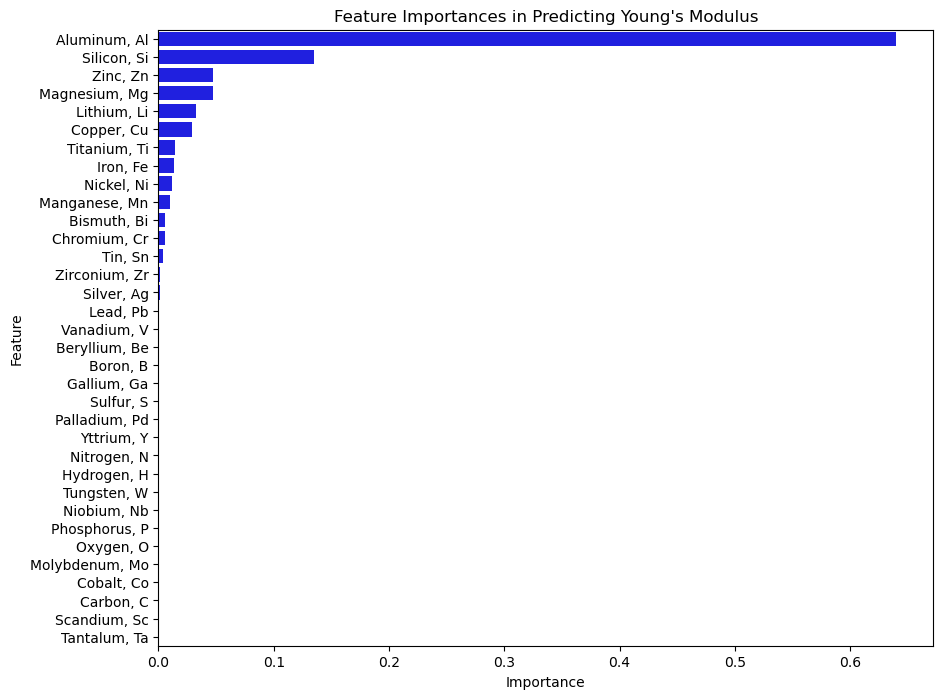

(0.040226073980715996,
            Feature    Importance
 0     Aluminum, Al  6.402052e-01
 6      Silicon, Si  1.353793e-01
 8         Zinc, Zn  4.746069e-02
 4    Magnesium, Mg  4.728964e-02
 20     Lithium, Li  3.288616e-02
 2       Copper, Cu  2.884079e-02
 7     Titanium, Ti  1.442784e-02
 3         Iron, Fe  1.323620e-02
 12      Nickel, Ni  1.147280e-02
 5    Manganese, Mn  9.934670e-03
 16     Bismuth, Bi  5.584677e-03
 1     Chromium, Cr  5.300683e-03
 18         Tin, Sn  3.810935e-03
 9    Zirconium, Zr  1.442303e-03
 21      Silver, Ag  9.970845e-04
 17        Lead, Pb  9.237655e-04
 10     Vanadium, V  7.908834e-04
 15   Beryllium, Be  1.369232e-05
 11        Boron, B  2.226348e-06
 13     Gallium, Ga  3.976887e-07
 27       Sulfur, S  0.000000e+00
 32   Palladium, Pd  0.000000e+00
 31      Yttrium, Y  0.000000e+00
 30     Nitrogen, N  0.000000e+00
 29     Hydrogen, H  0.000000e+00
 28     Tungsten, W  0.000000e+00
 25     Niobium, Nb  0.000000e+00
 26   Phosphorus, P  0.00

In [14]:
output_dir = "Images/Aluminum/Young Modulus"
train_and_evaluate_simple_rf(X_train, y_train, X_test, y_test, output_dir, "Young's Modulus")

#### Combination Neural Network Feature Combination Importance

In [15]:
def needs_analysis(filename, expected_combinations):
    if os.path.exists(filename):
        existing_df = pd.read_csv(filename)
        existing_combos = set(tuple(row) for row in existing_df['Combination'].apply(eval))
        # Convert expected_combinations to a set
        expected_combos_set = set(expected_combinations)
        if existing_combos >= expected_combos_set:
            print("All combinations have already been evaluated.")
            return False
    return True

In [16]:
def process2VariableMLP(data, top_features, fixed_feature, modulus_feature, file_path, plot_dir, metal="Aluminum"):
    """
    Processes alloy data to train a neural network model and visualize the results.
    
    Parameters:
    - data (DataFrame): The dataset containing alloy compositions.
    - top_features (list): List of the alloy elements to consider in combinations.
    - fixed_feature (str): The fixed feature in all combinations.
    - modulus_feature (str): The name of the column for Young's modulus.
    - file_path (str): Path to save or load the MSE results.
    - plot_dir (str): Directory to save plots and LaTeX files.
    """
    # Extract features and target based on provided column names
    X = data[top_features + [fixed_feature]]
    y = data[modulus_feature]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if os.path.exists(file_path):
        print("Loading existing results...")
        results_df = pd.read_csv(file_path)
        results_df['Combination'] = results_df['Combination'].apply(ast.literal_eval)
        best_combination = results_df.loc[results_df['MSE'].idxmin(), 'Combination']
    else:
        print("Processing new combinations...")
        mse_scores = {}
        full_combinations = [combo + (fixed_feature,) for combo in combinations(top_features, 1)]
        for combo in full_combinations:
            print(f'Processing combination: {combo}')
            X_train_sub = X_train[list(combo)]
            X_test_sub = X_test[list(combo)]

            # Define and compile the neural network
            nn_model = Sequential([
                Dense(3, input_dim=len(combo), activation='relu'),
                Dense(3, activation='relu'),
                Dense(3, activation='relu'),
                Dense(1)
            ])
            nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
            nn_model.fit(X_train_sub, y_train, epochs=200, batch_size=10, verbose=0, validation_split=0.2)
            mse = nn_model.evaluate(X_test_sub, y_test, verbose=0)
            mse_scores[combo] = mse

        results_df = pd.DataFrame(list(mse_scores.items()), columns=['Combination', 'MSE'])
        results_df.to_csv(file_path, index=False)
        best_combination = min(mse_scores, key=mse_scores.get)

    # Fit the best combination model for visualization
    nn_model = Sequential([
        Dense(3, input_dim=len(best_combination), activation='relu'),
        Dense(3, activation='relu'),
        Dense(3, activation='relu'),
        Dense(1)
    ])
    nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    nn_model.fit(X_train[list(best_combination)], y_train, epochs=200, batch_size=10, verbose=0, validation_split=0.2)
    y_pred = nn_model.predict(X_test[list(best_combination)]).flatten()

    # Visualization
    element_name = ', '.join(best_combination)
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, color='blue', marker='o', alpha=0.5, label='Predicted Values')  # Predicted values as blue circles
    plt.scatter(y_test, y_test, color='red', marker='x', label='Actual Values')  # Actual values as red x's
    plt.title(f"Actual vs. Predicted {modulus_feature} Values (2 Variables - {element_name})")
    plt.xlabel(f"Actual {modulus_feature}")
    plt.ylabel(f"Predicted {modulus_feature}")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, label='Ideal Prediction Line')  # Ideal prediction line
    plt.legend()  # Add a legend to clarify the plot symbols

    # Ensure directory exists
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    
    plot_path = os.path.join(plot_dir, f'{metal}_{modulus_feature.replace(" ", "_")}_2VariableMLP.png')
    plt.savefig(plot_path)
    plt.show()
    fixed_feature
    
    latex_code = rf"""
    \begin{{figure}}[h]
        \centering
        \includegraphics[width=0.8\textwidth]{{{plot_path}}}
        \caption{{2 Variable Simple MLP for predicting {modulus_feature} (Featuring: {element_name})}}
        \label{{fig:{metal}_{modulus_feature.replace(" ", "_")}_2VariableMLP}}
    \end{{figure}}
    """

    # Write the LaTeX code to a .tex file
    tex_path = os.path.join(plot_dir, f'{metal}_{modulus_feature.replace(" ", "_")}_2VariableMLP.tex')
    with open(tex_path, 'w') as f:
        f.write(latex_code)

    print(f"Best combination including {fixed_feature}: {best_combination}, MSE: {results_df['MSE'].min()}")
    print(f"Graph and LaTeX file saved with element pair in names: {plot_path} and {tex_path}")

In [17]:
def process3VariableMLP(data, top_features, fixed_feature, modulus_feature, file_path, plot_dir, metal="Aluminum"):
    """
    Processes alloy data to train a neural network model and visualize the results.
    
    Parameters:
    - data (DataFrame): The dataset containing alloy compositions.
    - top_features (list): List of the alloy elements to consider in combinations.
    - fixed_feature (str): The fixed feature in all combinations.
    - modulus_feature (str): The name of the column for Young's modulus.
    - file_path (str): Path to save or load the MSE results.
    - plot_dir (str): Directory to save plots and LaTeX files.
    """
    # Extract features and target based on provided column names
    X = data[top_features + [fixed_feature]]
    y = data[modulus_feature]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if os.path.exists(file_path):
        print("Loading existing results...")
        results_df = pd.read_csv(file_path)
        results_df['Combination'] = results_df['Combination'].apply(ast.literal_eval)
        best_combination = results_df.loc[results_df['MSE'].idxmin(), 'Combination']
    else:
        print("Processing new combinations...")
        mse_scores = {}
        full_combinations = [combo + (fixed_feature,) for combo in combinations(top_features, 2)]
        for combo in full_combinations:
            print(f'Processing combination: {combo}')
            X_train_sub = X_train[list(combo)]
            X_test_sub = X_test[list(combo)]

            # Define and compile the neural network
            nn_model = Sequential([
                Dense(3, input_dim=len(combo), activation='relu'),
                Dense(3, activation='relu'),
                Dense(3, activation='relu'),
                Dense(1)
            ])
            nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
            nn_model.fit(X_train_sub, y_train, epochs=200, batch_size=10, verbose=0, validation_split=0.2)
            mse = nn_model.evaluate(X_test_sub, y_test, verbose=0)
            mse_scores[combo] = mse

        results_df = pd.DataFrame(list(mse_scores.items()), columns=['Combination', 'MSE'])
        results_df.to_csv(file_path, index=False)
        best_combination = min(mse_scores, key=mse_scores.get)

    # Fit the best combination model for visualization
    nn_model = Sequential([
        Dense(3, input_dim=len(best_combination), activation='relu'),
        Dense(3, activation='relu'),
        Dense(3, activation='relu'),
        Dense(1)
    ])
    nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    nn_model.fit(X_train[list(best_combination)], y_train, epochs=200, batch_size=10, verbose=0, validation_split=0.2)
    y_pred = nn_model.predict(X_test[list(best_combination)]).flatten()

    # Visualization
    element_name = ', '.join(best_combination)
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, color='blue', marker='o', alpha=0.5, label='Predicted Values')  # Predicted values as blue circles
    plt.scatter(y_test, y_test, color='red', marker='x', label='Actual Values')  # Actual values as red x's
    plt.title(f"Actual vs. Predicted {modulus_feature} Values (3 Variables - {element_name})")
    plt.xlabel(f"Actual {modulus_feature}")
    plt.ylabel(f"Predicted {modulus_feature}")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, label='Ideal Prediction Line')  # Ideal prediction line
    plt.legend()  # Add a legend to clarify the plot symbols

    # Ensure directory exists
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    
    plot_path = os.path.join(plot_dir, f'{metal}_{modulus_feature.replace(" ", "_")}_3VariableMLP.png')
    plt.savefig(plot_path)
    plt.show()
    fixed_feature
    
    latex_code = rf"""
    \begin{{figure}}[h]
        \centering
        \includegraphics[width=0.8\textwidth]{{{plot_path}}}
        \caption{{3 Variable Simple MLP for predicting {modulus_feature} (Featuring: {element_name})}}
        \label{{fig:{metal}_{modulus_feature.replace(" ", "_")}_3VariableMLP}}
    \end{{figure}}
    """

    # Write the LaTeX code to a .tex file
    tex_path = os.path.join(plot_dir, f'{metal}_{modulus_feature.replace(" ", "_")}_3VariableMLP.tex')
    with open(tex_path, 'w') as f:
        f.write(latex_code)

    print(f"Best combination including {fixed_feature}: {best_combination}, MSE: {results_df['MSE'].min()}")
    print(f"Graph and LaTeX file saved with element pair in names: {plot_path} and {tex_path}")

Loading existing results...
4/4 [==============================] - 0s 3ms/step


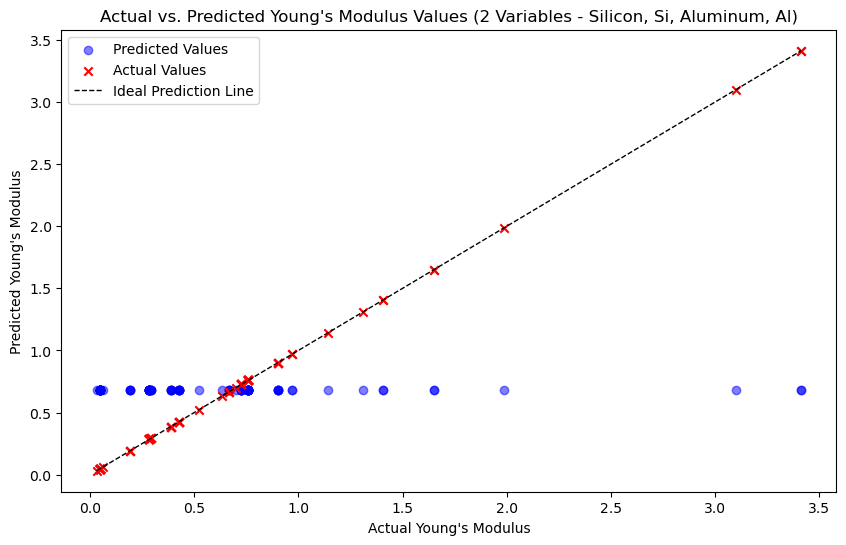

Best combination including Aluminum, Al: ('Silicon, Si', 'Aluminum, Al'), MSE: 0.3665098249912262
Graph and LaTeX file saved with element pair in names: Images/Aluminum/Young Modulus/Aluminum_Young's_Modulus_2VariableMLP.png and Images/Aluminum/Young Modulus/Aluminum_Young's_Modulus_2VariableMLP.tex


In [18]:
top_features = ['Silicon, Si', 'Copper, Cu', 'Iron, Fe', 
                'Magnesium, Mg', 'Zinc, Zn', 'Manganese, Mn', 'Bismuth, Bi', 'Titanium, Ti', 
                'Lithium, Li', 'Nickel, Ni', 'Chromium, Cr', 'Zirconium, Zr', 'Vanadium, V', 
                'Tin, Sn', 'Lead, Pb', 'Scandium, Sc', 'Beryllium, Be', 'Gallium, Ga', 
                'Boron, B', 'Silver, Ag']
fixed_feature = 'Aluminum, Al'
file_path = 'Al_model_data/mse_scores_with_aluminum_2_features_modulus.csv'
plotdir = 'Images/Aluminum/Young Modulus'
process2VariableMLP(metals_and_modulus, top_features, fixed_feature, "Young's Modulus", file_path, plotdir)

Loading existing results...
4/4 [==============================] - 0s 1ms/step


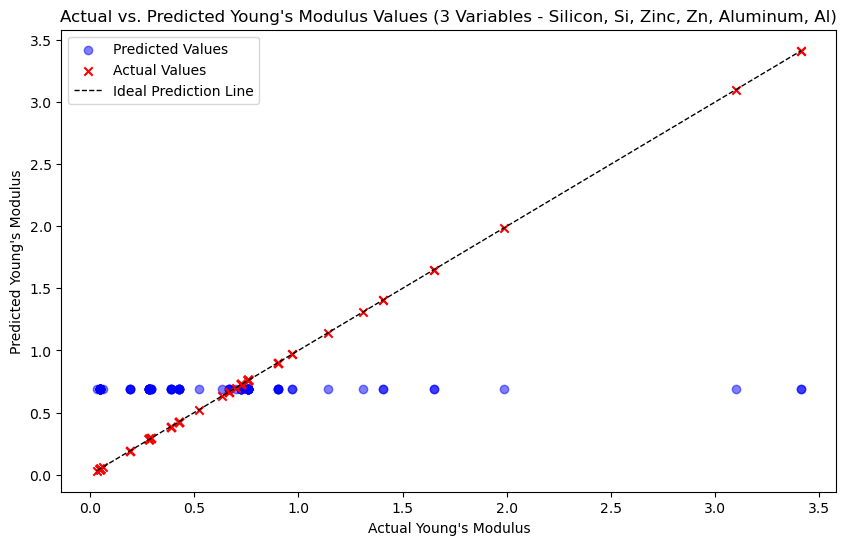

Best combination including Aluminum, Al: ('Silicon, Si', 'Zinc, Zn', 'Aluminum, Al'), MSE: 0.2483554482460022
Graph and LaTeX file saved with element pair in names: Images/Aluminum/Young Modulus/Aluminum_Young's_Modulus_3VariableMLP.png and Images/Aluminum/Young Modulus/Aluminum_Young's_Modulus_3VariableMLP.tex


In [14]:
top_features = ['Silicon, Si', 'Magnesium, Mg', 'Zinc, Zn', 'Lithium, Li', 'Titanium, Ti', 'Nickel, Ni', 'Copper, Cu', 'Iron, Fe', 'Manganese, Mn']
fixed_feature = 'Aluminum, Al'
file_path = 'Al_model_data/mse_scores_with_aluminum_3_features_modulus.csv'
plotdir = 'Images/Aluminum/Young Modulus'
process3VariableMLP(metals_and_modulus, top_features, fixed_feature, "Young's Modulus", file_path, plotdir)

#### Correlation Matrix 

In [14]:
def visualize_correlation(data, target_feature, output_dir, metal="Aluminum"):
    """
    Calculates the correlation matrix for a given dataset and target feature, 
    visualizes the correlation, and generates a LaTeX document for the plot.

    Parameters:
        data (DataFrame): The dataset containing the features and target.
        target_feature (str): The target feature for which to calculate correlations.
        metal (str): The specific metal or alloy being analyzed, used for file naming.
        output_dir (str): The directory to save the plot and LaTeX file.
    """
    # Calculate the correlation matrix
    corr_matrix = data.corr()

    # Isolate the correlation of the target feature with other features
    target_corr = corr_matrix[target_feature].drop(target_feature).sort_values(ascending=False)

    if output_dir is not None:

        # Ensure the output directory exists
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Visualization
        plt.figure(figsize=(10, 8))
        sns.barplot(x=target_corr.index, y=target_corr.values)
        plt.xticks(rotation=90)
        plt.title(f"Correlation with {target_feature}")
        plt.ylabel("Correlation Coefficient")
        plot_path = os.path.join(output_dir, f'{metal}_{target_feature.replace(" ", "_")}_CorrelationMatrix.png')
        plt.savefig(plot_path)
        plt.show()

        # LaTeX code for the figure
        latex_code = rf"""
        \begin{{figure}}[h]
            \centering
            \includegraphics[width=0.8\textwidth]{{{plot_path}}}
            \caption{{Correlation Matrix of {metal} based alloys predicting the {target_feature}}}
            \label{{fig:{metal}_{target_feature.replace(" ", "_")}_CorrelationMatrix}}
        \end{{figure}}
        """
        latex_file_path = os.path.join(output_dir, f'{metal}_{target_feature.replace(" ", "_")}_CorrelationMatrix.tex')
        with open(latex_file_path, 'w') as f:
            f.write(latex_code)

    return target_corr

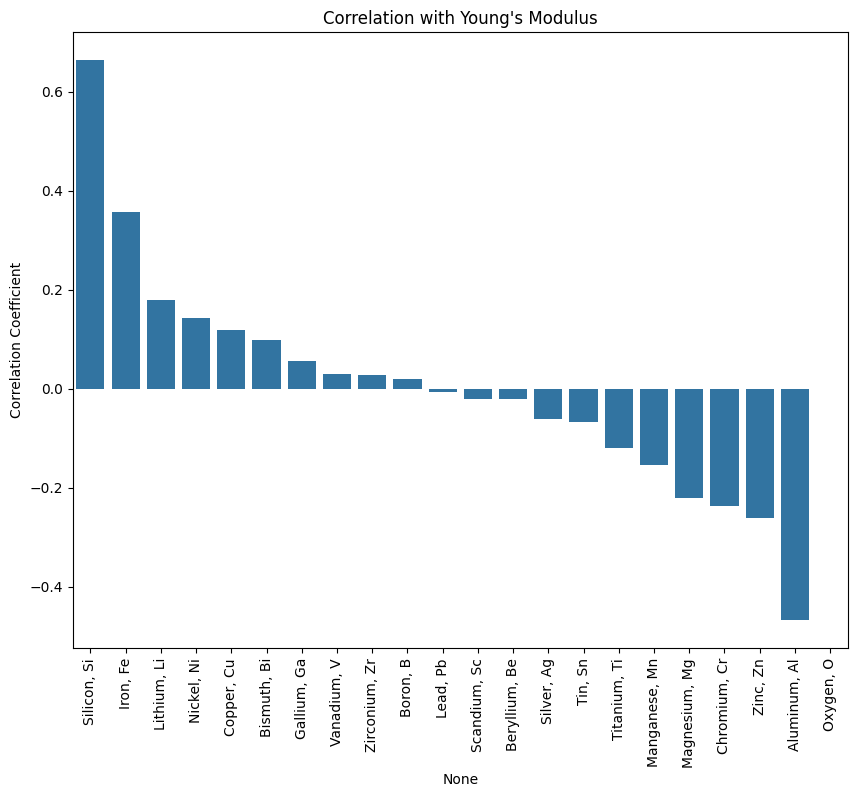

Silicon, Si      0.663766
Iron, Fe         0.357607
Lithium, Li      0.179916
Nickel, Ni       0.141754
Copper, Cu       0.118875
Bismuth, Bi      0.098618
Gallium, Ga      0.055071
Vanadium, V      0.030410
Zirconium, Zr    0.026589
Boron, B         0.019519
Lead, Pb        -0.007079
Scandium, Sc    -0.020698
Beryllium, Be   -0.021030
Silver, Ag      -0.060965
Tin, Sn         -0.068230
Titanium, Ti    -0.119913
Manganese, Mn   -0.153672
Magnesium, Mg   -0.220938
Chromium, Cr    -0.236481
Zinc, Zn        -0.261815
Aluminum, Al    -0.467820
Oxygen, O             NaN
Name: Young's Modulus, dtype: float64

In [16]:
target_feature = "Young's Modulus"
output_dir = "Images/Aluminum/Young Modulus"
visualize_correlation(metals_and_modulus, target_feature, output_dir)

#### Regression

In [17]:
def evaluate_feature(data, feature, target, degree):
    """Evaluate and return a statsmodels regression model."""
    poly = PolynomialFeatures(degree)
    X = data[[feature]].values
    X_poly = poly.fit_transform(X)
    X_poly = sm.add_constant(X_poly)
    y = data[target]
    return sm.OLS(y, X_poly).fit()

def determine_better_model(linear_model, poly_model):
    """Return the better model based on AIC comparison."""
    if linear_model.aic < poly_model.aic:
        return linear_model, 'Linear'
    return poly_model, 'Polynomial'

Positive coefficients indicate an increase in Young's Modulus with an increase in the metal's concentration.

Negative coefficients suggest a decrease in Young's Modulus as the metal's concentration increases.

In [18]:
def evaluate_and_visualize_impact(data, metals, target_feature, plot_dir, threshold=0.1, main_metal="Aluminum"):
    """
    Evaluates the impact of different metals on a target feature, visualizes
    regression models, and generates a LaTeX figure documentation.

    Parameters:
        data (DataFrame): Dataset containing alloy compositions and target feature.
        metals (list): List of metals to consider.
        target_feature (str): Target feature for regression.
        plot_dir (str): Directory to save plots and LaTeX file.
        threshold (float): Minimum content threshold to consider a metal for evaluation.
    """
    models = {}
    linear_vs_poly = {}
    impact_summary = pd.DataFrame(columns=['Metal', 'Coefficient', 'Effect'])

    for metal in metals:
        if data[metal].max() < threshold:
            continue
        
        # Decide on the model type based on metal content
        if data[metal].max() <= 1:
            model = evaluate_feature(data, metal, target_feature, 1)
            linear_vs_poly[metal] = 'Linear'
        else:
            linear_model = evaluate_feature(data, metal, target_feature, 1)
            poly_model = evaluate_feature(data, metal, target_feature, 2)
            model = linear_model if linear_model.aic < poly_model.aic else poly_model
            linear_vs_poly[metal] = 'Linear' if model is linear_model else 'Polynomial'
        
        models[metal] = model
        coeff = model.params[1 if linear_vs_poly[metal] == 'Linear' else 2]
        effect = 'Increases' if coeff > 0 else 'Decreases'
        new_row = pd.DataFrame({'Metal': [metal], 'Coefficient': [coeff], 'Effect': [effect]})
        impact_summary = pd.concat([impact_summary, new_row], ignore_index=True)

    # Visualization
    num_cols = 3
    num_rows = (len(models) + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 4))
    axes = axes.flatten()
    
    for idx, metal in enumerate(models):
        ax = axes[idx]
        model = models[metal]
        X = np.linspace(data[metal].min(), data[metal].max(), 100).reshape(-1, 1)
        preds = model.predict(sm.add_constant(PolynomialFeatures(1 if linear_vs_poly[metal] == 'Linear' else 2).fit_transform(X)))
        ax.plot(X.flatten(), preds, label=f'{metal} {linear_vs_poly[metal]} Regression', color=plt.cm.viridis(np.linspace(0, 1, len(models)))[idx])
        ax.scatter(data[metal], data[target_feature], color='gray', alpha=0.5)
        ax.set(title=f'{metal} - {linear_vs_poly[metal]}', xlabel='Metal Content', ylabel=target_feature)
        ax.legend()

    for i in range(idx + 1, len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plot_path = os.path.join(plot_dir, f'{main_metal}_{target_feature.replace(" ", "_")}_IndividualElementRegression.png')
    plt.savefig(plot_path)
    plt.show()

    # LaTeX documentation
    latex_code = rf"""
    \begin{{figure}}[h]
        \centering
        \includegraphics[width=0.8\textwidth]{{{plot_path}}}
        \caption{{Individual Element Regression of {metal} based alloys predicting the {target_feature}}}
        \label{{fig:{main_metal}_{target_feature.replace(" ", "_")}IndividualElementRegression}}
    \end{{figure}}
    """
    tex_path = os.path.join(plot_dir, f'{main_metal}_{target_feature.replace(" ", "_")}_IndividualElementRegression.tex')
    with open(tex_path, 'w') as f:
        f.write(latex_code)

    return impact_summary, plot_path

# Helper function to evaluate the feature with linear or polynomial regression
def evaluate_feature(data, feature, target, degree):
    X = data[[feature]]
    y = data[target]
    X_poly = PolynomialFeatures(degree=degree).fit_transform(X)
    model = sm.OLS(y, sm.add_constant(X_poly)).fit()
    return model

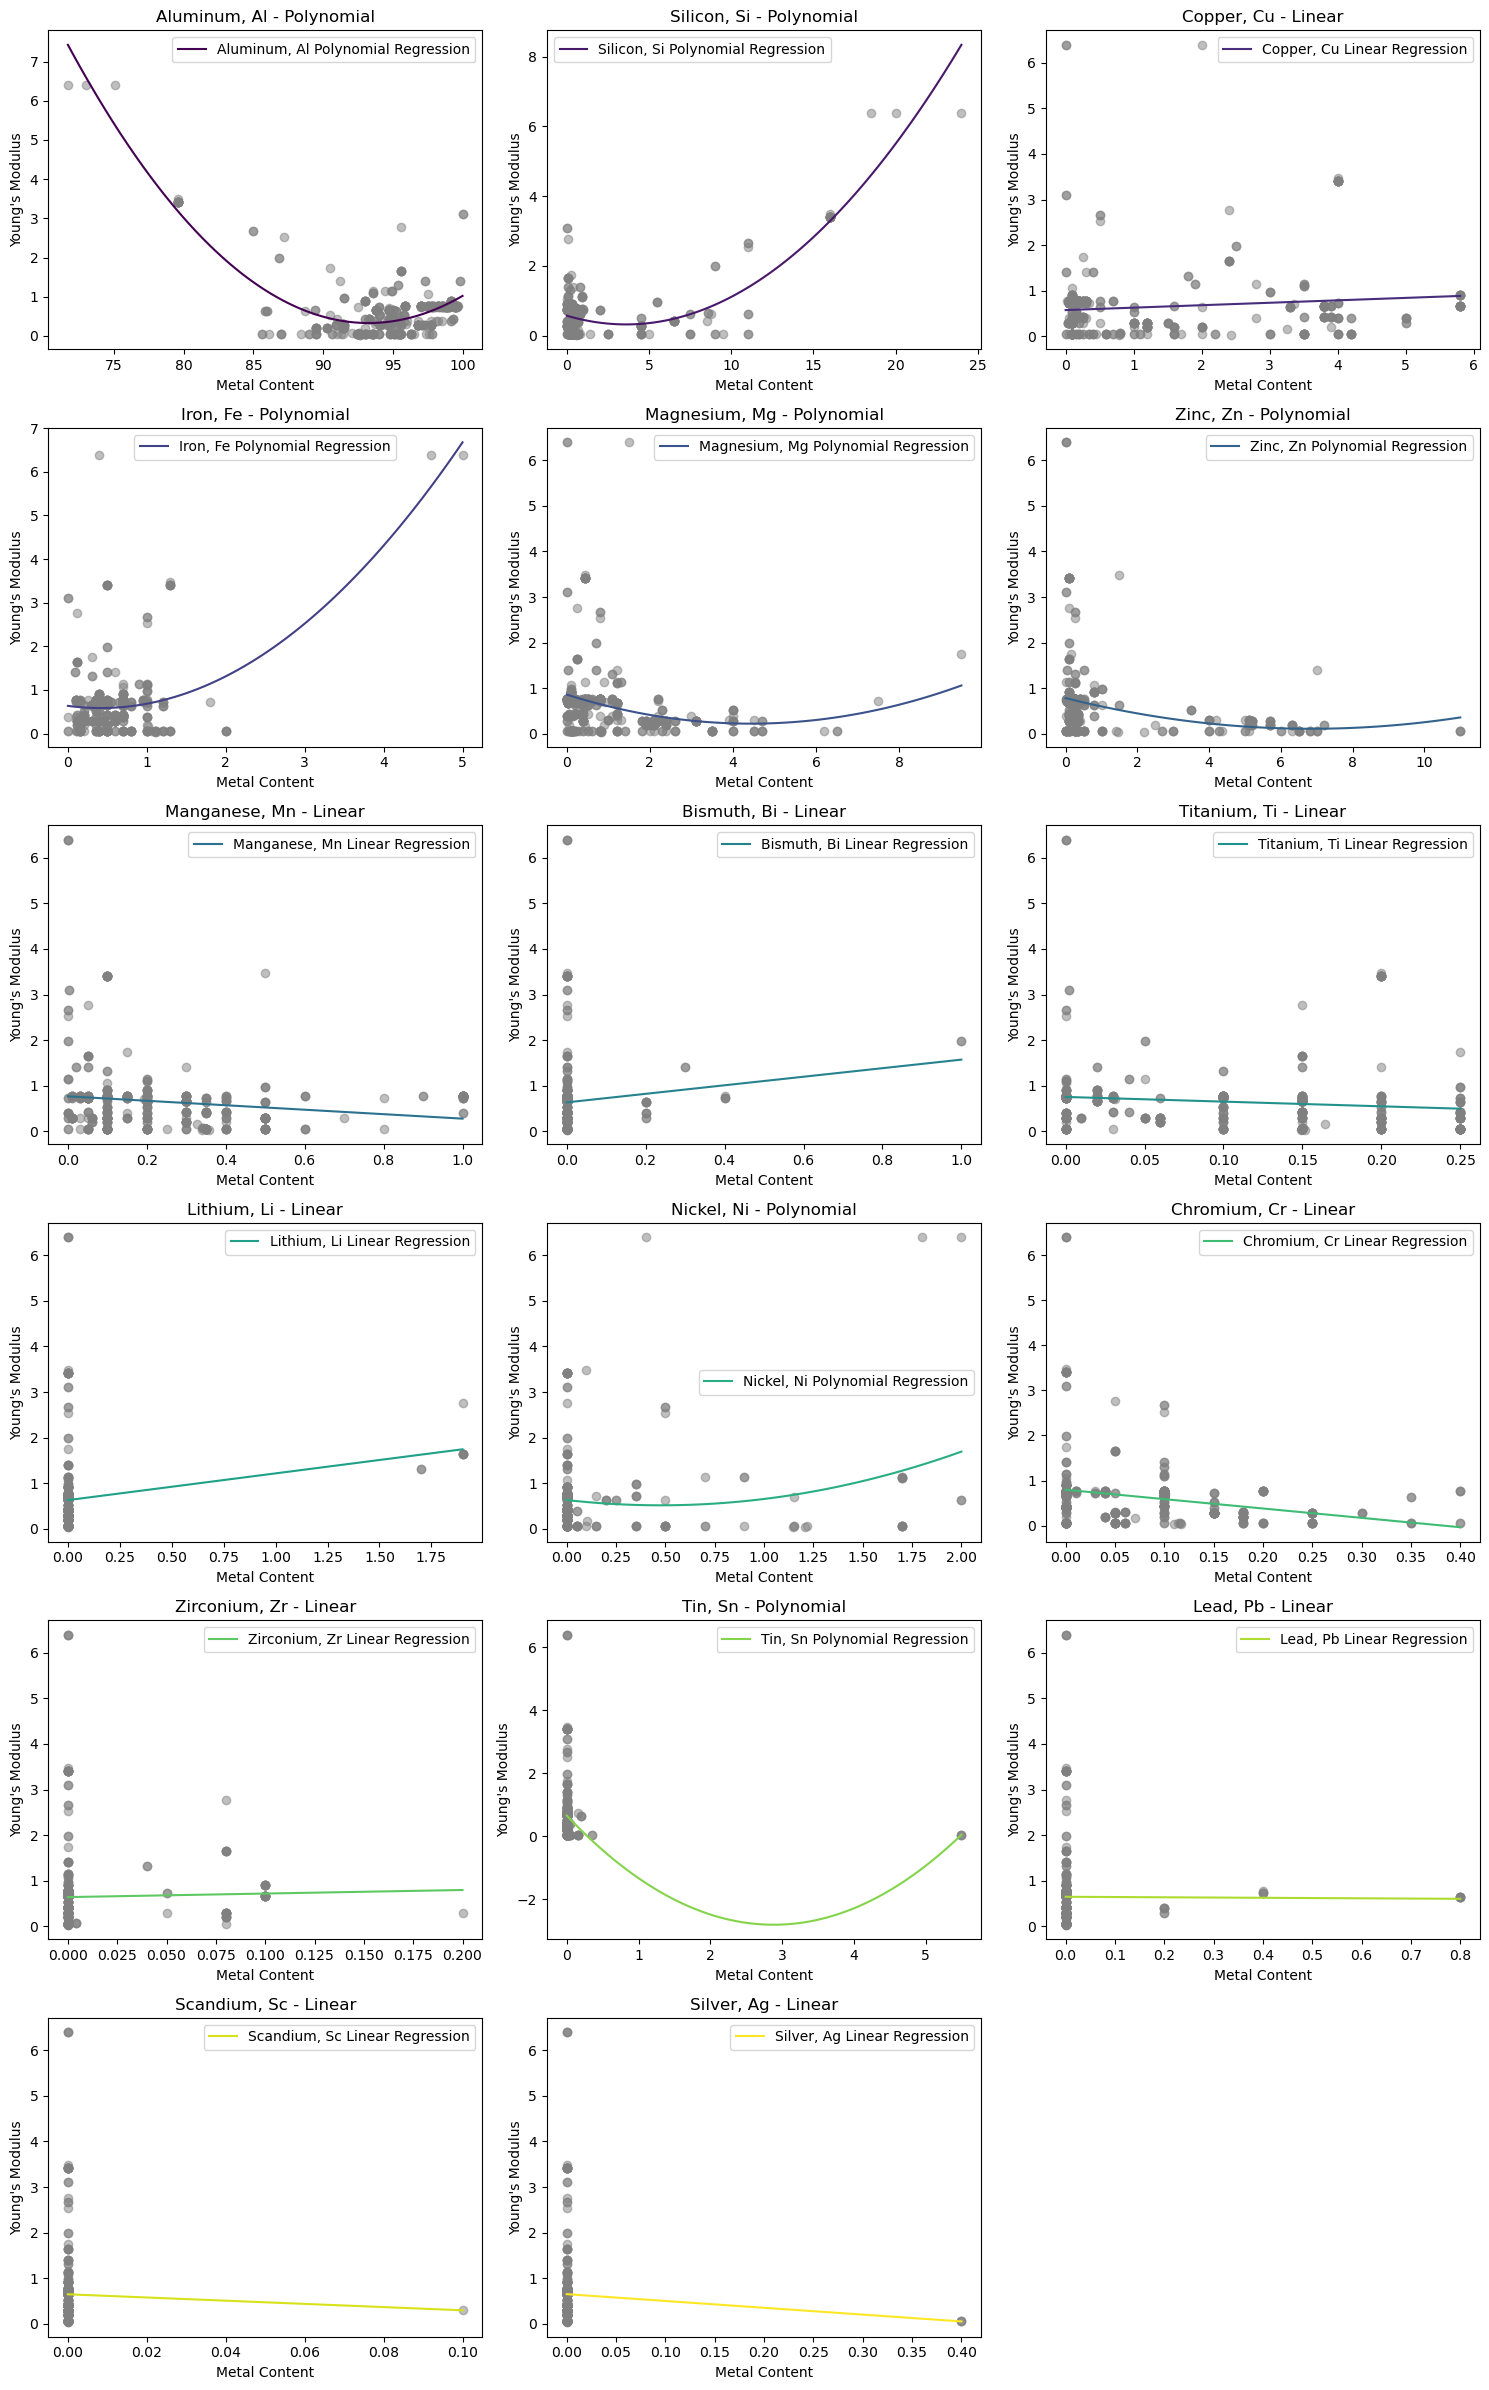

(            Metal  Coefficient     Effect
 0    Aluminum, Al     0.015274  Increases
 1     Silicon, Si     0.019268  Increases
 2      Copper, Cu     0.053602  Increases
 3        Iron, Fe     0.290001  Increases
 4   Magnesium, Mg     0.032567  Increases
 5        Zinc, Zn     0.014384  Increases
 6   Manganese, Mn    -0.490494  Decreases
 7     Bismuth, Bi     0.938825  Increases
 8    Titanium, Ti    -1.030777  Decreases
 9     Lithium, Li     0.587571  Increases
 10     Nickel, Ni     0.507900  Increases
 11   Chromium, Cr    -2.079378  Decreases
 12  Zirconium, Zr     0.780681  Increases
 13        Tin, Sn     0.416859  Increases
 14       Lead, Pb    -0.055984  Decreases
 15   Scandium, Sc    -3.515639  Decreases
 16     Silver, Ag    -1.497704  Decreases,
 "Images/Aluminum/Young Modulus/Aluminum_Young's_Modulus_IndividualElementRegression.png")

In [19]:
metals = ['Aluminum, Al', 'Silicon, Si', 'Copper, Cu', 'Iron, Fe', 
          'Magnesium, Mg', 'Zinc, Zn', 'Manganese, Mn', 'Bismuth, Bi', 'Titanium, Ti', 
          'Lithium, Li', 'Nickel, Ni', 'Chromium, Cr', 'Zirconium, Zr', 'Vanadium, V', 
          'Tin, Sn', 'Lead, Pb', 'Scandium, Sc', 'Beryllium, Be', 'Gallium, Ga', 
          'Boron, B', 'Silver, Ag']
target_feature = "Young's Modulus"
plot_dir = "Images/Aluminum/Young Modulus"
evaluate_and_visualize_impact(metals_and_modulus, metals, target_feature, plot_dir)

In [20]:
## Splitting the DataFrame into positive and negative subsets
#positive_df = impact_summary[impact_summary['Coefficient'] > 0].copy()
#negative_df = impact_summary[impact_summary['Coefficient'] < 0].copy()
#
## Sorting each subset
#positive_df.sort_values(by='Coefficient', ascending=False, inplace=True)
#negative_df.sort_values(by='Coefficient', ascending=False, inplace=True)  # Sort negatives in descending order by value
#
## Concatenating back into a single DataFrame
#sorted_impact_summary = pd.concat([positive_df, negative_df], axis=0)
#
## Define colors based on coefficient sign and set edge colors for better visibility
#colors = ['green' if x > 0 else 'red' for x in sorted_impact_summary['Coefficient']]
#edge_colors = ['darkgreen' if x > 0 else 'darkred' for x in sorted_impact_summary['Coefficient']]
#
## Set up the plot
#plt.figure(figsize=(10, 8))
#bars = plt.barh(sorted_impact_summary['Metal'], sorted_impact_summary['Coefficient'], color=colors, edgecolor=edge_colors)
#plt.xlabel('Coefficient Value')
#plt.title('Impact of Each Metal on Young\'s Modulus')
#
## Invert y-axis to have the largest impact at the top
#plt.gca().invert_yaxis()
#
## Add text labels to bars for exact coefficient values
#for bar, value in zip(bars, sorted_impact_summary['Coefficient']):
#    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{value:.2f}', va='center', 
#             ha='right' if value < 0 else 'left')
#
## Show the plot
#plt.savefig('Images/Aluminum/Young Modulus/IndividualElementImpact.png')
#plt.show()
#
#latex_code = r"""
#\begin{figure}[h]
#    \centering
#    \includegraphics[width=0.8\textwidth]{Images/Aluminum/Young Modulus/IndividualElementImpact.png}
#    \caption{Individual Element Impact of Aluminum based alloys predicting the Young's Modulus}
#    \label{fig:IndividualElementImpact_Al_YM}
#\end{figure}
#"""
#
## Write the LaTeX code to a .tex file
#with open('Images/Aluminum/Young Modulus/IndividualElementImpact.tex', 'w') as f:
#    f.write(latex_code)
#
## Optionally, print the DataFrame for a tabular view
#print(sorted_impact_summary[['Metal', 'Coefficient', 'Effect']])

### <span style="color:lime">Optimizing Youngs Modulus</span>

#### <span style="color:red">Random Forest</span>

In [217]:
def analyze_alloy_strength(data, features, target, al_min=75, al_max=100):
    """
    Analyzes alloy data to find the composition with the highest predicted Young's Modulus,
    focusing on a specified range of Aluminum content.

    Parameters:
        data (DataFrame): The dataset containing alloy compositions.
        features (list): List of feature columns to consider.
        target (str): Target feature column name (Young's Modulus).
        al_min (float): Minimum Aluminum content percentage to filter data.
        al_max (float): Maximum Aluminum content percentage to filter data.

    Returns:
        dict: A dictionary containing MSE, RMSE, maximum Young's Modulus, and the composition of the alloy with the highest modulus.
    """
    # Filter data based on Aluminum content
    filtered_data = data[(data['Aluminum, Al'] >= al_min) & (data['Aluminum, Al'] <= al_max)]

    # Split data into training and testing sets
    X = filtered_data[features]
    y = filtered_data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the Random Forest Regressor
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Predict the Young's Modulus on the test set
    y_pred = rf_model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5

    # Find the index and value of the maximum predicted Young's Modulus
    max_index = y_pred.argmax()
    max_youngs_modulus = y_pred[max_index]
    strongest_composition = X_test.iloc[max_index]

    return {
        'mse': mse,
        'rmse': rmse,
        'max_youngs_modulus': max_youngs_modulus,
        'strongest_composition': strongest_composition,
        'model': rf_model
    }

In [218]:
selected_features = ['Aluminum, Al', 'Silicon, Si', 'Magnesium, Mg', 'Zinc, Zn', 'Lithium, Li', 'Titanium, Ti', 'Nickel, Ni', 'Copper, Cu', 'Iron, Fe', 'Manganese, Mn']
target_variable = 'Young\'s Modulus'
results = analyze_alloy_strength(metals_and_modulus, selected_features, target_variable)
print(results)

{'mse': 0.06000424670049823, 'rmse': 0.24495764266602957, 'max_youngs_modulus': 3.412672507522073, 'strongest_composition': Aluminum, Al     79.60
Silicon, Si      16.00
Magnesium, Mg     0.45
Zinc, Zn          0.10
Lithium, Li       0.00
Titanium, Ti      0.20
Nickel, Ni        0.00
Copper, Cu        4.00
Iron, Fe          1.30
Manganese, Mn     0.10
Name: 15, dtype: float64, 'model': RandomForestRegressor(random_state=42)}


In [219]:
model = results['model']

In [220]:
def generate_and_predict_alloy_strength(model, output_file_path, metals, al_increments, other_increments, target_variable, metal='Aluminum, Al'):
    """
    Generates hypothetical alloy compositions and predicts their specified property using a pre-trained model.
    
    Parameters:
        model (RandomForestRegressor): A pre-trained Random Forest model.
        output_file_path (str): Path to the output CSV file.
        metals (list): List of metals other than Aluminum to include in the combinations.
        al_increments (np.array): Array of percentage increments for Aluminum.
        other_increments (np.array): Array of possible percentage values for other metals.
        target_variable (str): The property to predict, e.g., 'Young's Modulus'.
        metal (str): The primary metal, default 'Aluminum, Al'.
        
    Returns:
        DataFrame: The top 10 combinations with the highest predicted value of the specified property.
    """
    if exists(output_file_path):
        # Load existing results from file
        hypothetical_results = pd.read_csv(output_file_path)
        print("Loaded results from existing file.")
    else:
        # Generate all valid combinations where the total percentage is 100
        valid_combinations = []
        for al_percent in al_increments:
            for combo in product(other_increments, repeat=len(metals)):
                if sum(combo) == (100 - al_percent):  # Ensure the total sum with Aluminum is 100%
                    valid_combinations.append((al_percent,) + combo)
        
        # Convert the list of combinations into a DataFrame
        hypothetical_metals_df = pd.DataFrame(valid_combinations, columns=[metal] + metals)
        
        # Predict the specified property for these hypothetical alloys
        hypothetical_youngs_modulus = model.predict(hypothetical_metals_df)
        
        # Combining the compositions and their predicted property
        hypothetical_results = hypothetical_metals_df.copy()
        hypothetical_results[target_variable] = hypothetical_youngs_modulus
        
        # Save all combinations and their predicted property to a CSV file
        hypothetical_results.to_csv(output_file_path, index=False)
        print("Predictions performed and results saved.")

    # Find the top 10 combinations with the highest predicted property value
    top_10_modulus_combinations = hypothetical_results.nlargest(10, target_variable)
    
    return top_10_modulus_combinations

In [221]:
output_path = "Al_model_data/all_hypothetical_combinations_with_predictions_aluminum_modulus.csv"
metals = ['Silicon, Si', 'Magnesium, Mg', 'Zinc, Zn', 'Lithium, Li', 'Titanium, Ti', 'Nickel, Ni', 'Copper, Cu', 'Iron, Fe', 'Manganese, Mn']
al_increments = np.arange(75, 101, 5)
other_increments = np.arange(0, 26, 5)

top_combinations = generate_and_predict_alloy_strength(model, output_path, metals, al_increments, other_increments, 'Young\'s Modulus')
print("Top 10 Young's Modulus Combinations:")
print(top_combinations.head(10))  # Print only the top 10

Loaded results from existing file.
Top 10 Young's Modulus Combinations:
      Aluminum, Al  Silicon, Si  Magnesium, Mg  Zinc, Zn  Lithium, Li  \
1279            75           20              0         0            0   
1281            75           20              0         0            0   
1249            75           15              0         0            0   
1278            75           20              0         0            0   
1243            75           15              0         0            0   
1283            75           20              0         0            5   
1286            75           25              0         0            0   
1133            75           10              0         0            0   
1244            75           15              0         0            0   
1258            75           15              0         0            5   

      Titanium, Ti  Nickel, Ni  Copper, Cu  Iron, Fe  Manganese, Mn  \
1279             0           0           0         5 

#### <span style="color:red">MLP</span>

In [222]:
def perform_grid_search_nn(data, features, target, layer_configurations, max_iter_options, results_csv_path):
    """
    Performs a grid search to find the best MLPRegressor configuration.
    
    Parameters:
        data (DataFrame): The dataset containing all relevant data.
        features (list): List of feature column names.
        target (str): Name of the target variable.
        layer_configurations (list of tuples): Hidden layer configurations.
        max_iter_options (list of int): Maximum iteration options.
        results_csv_path (str): Path to save the grid search results.
        
    Returns:
        dict: Contains DataFrame of results and train/test splits.
    """
    X = data[features]
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if os.path.exists(results_csv_path):
        results_df = pd.read_csv(results_csv_path)
        print("Loaded existing results from file.")
    else:
        results = []
        best_mse = float('inf')
        best_configuration = None

        for layers in layer_configurations:
            for max_iter in max_iter_options:
                nn_model = MLPRegressor(hidden_layer_sizes=layers, activation='relu', solver='adam', max_iter=max_iter)
                bagging_model = BaggingRegressor(nn_model, n_estimators=10, random_state=42)
                bagging_model.fit(X_train, y_train)

                y_pred = bagging_model.predict(X_test)
                mse = mean_squared_error(y_test, y_pred)
                results.append({'Layers': layers, 'Max_iter': max_iter, 'MSE': mse})

                if mse < best_mse:
                    best_mse = mse
                    best_configuration = (layers, max_iter)

                print(f"Configuration: Layers={layers}, Max_iter={max_iter}, MSE={mse}")

        results_df = pd.DataFrame(results)
        results_df.to_csv(results_csv_path, index=False)
        print("Grid search results saved to:", results_csv_path)
        print(f"Best Configuration: Layers={best_configuration[0]}, Max_iter={best_configuration[1]}, Best MSE={best_mse}")

    return {
        "results_df": results_df,
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test
    }

In [223]:
selected_features = ['Aluminum, Al', 'Silicon, Si', 'Magnesium, Mg', 'Zinc, Zn', 'Lithium, Li', 'Titanium, Ti', 'Nickel, Ni', 'Copper, Cu', 'Iron, Fe', 'Manganese, Mn']
target_variable = "Young's Modulus"
layer_configurations = [
    (30, 3, 1), (40, 2), (10, 10), (3, 10, 2),
    (10,), (20,), (30,), (40,), (50,),
    (8,), (8, 8), (8, 5, 2),
    (5, 5), (10, 10), (20, 5), (5, 20),
    (15, 6), (6, 6), (6, 6, 2),
    (5,), (5, 10, 2), (10, 10), (5, 10),
    (2,), (2,2), (2,2,2), (2,2,2,2)
]
max_iter_options = [4000]
results_path = 'Al_model_data/grid_search_aluminium_modulus_results.csv'

# Call the grid search function
result = perform_grid_search_nn(metals_and_modulus, selected_features, target_variable, layer_configurations, max_iter_options, results_path)
X_train, X_test, y_train, y_test = result['X_train'], result['X_test'], result['y_train'], result['y_test']
grid_search_results = result['results_df']
print("Grid search results DataFrame:")
print(grid_search_results)

# Sort the results DataFrame by the 'MSE' column in ascending order
sorted_results = grid_search_results.sort_values(by='MSE', ascending=True)

# Print the sorted results
print("Sorted Grid Search Results by MSE:")
print(sorted_results)

Loaded existing results from file.
Grid search results DataFrame:
          Layers  Max_iter       MSE
0     (30, 3, 1)      4000  0.301887
1        (40, 2)      4000  0.266316
2       (10, 10)      4000  0.271875
3     (3, 10, 2)      4000  0.319172
4          (10,)      4000  0.229079
5          (20,)      4000  0.225019
6          (30,)      4000  0.237471
7          (40,)      4000  0.221609
8          (50,)      4000  0.496403
9           (8,)      4000  0.267149
10        (8, 8)      4000  0.268667
11     (8, 5, 2)      4000  0.278294
12        (5, 5)      4000  0.225110
13      (10, 10)      4000  0.271875
14       (20, 5)      4000  0.212851
15       (5, 20)      4000  0.298631
16       (15, 6)      4000  0.233840
17        (6, 6)      4000  0.263445
18     (6, 6, 2)      4000  0.267777
19          (5,)      4000  0.288092
20    (5, 10, 2)      4000  0.280162
21      (10, 10)      4000  0.271875
22       (5, 10)      4000  0.256333
23          (2,)      4000  0.285713
24       

In [228]:
def compare_bagging_huber(X_train, y_train, X_test, y_test, best_layers, best_max_iter, output_dir, target_variable, metal="Aluminum"):
    """
    Trains a bagging regressor with an MLP base and a Huber regressor, compares their performance on test data,
    plots the results, and saves the plot and LaTeX code based on the specified target variable.

    Parameters:
        X_train, y_train, X_test, y_test (DataFrame): Training and testing data.
        best_layers (tuple): Best layer configuration for MLP.
        best_max_iter (int): Maximum iterations for MLP training.
        output_dir (str): Directory to save outputs.
        target_variable (str): The target variable to predict and plot.
        metal (str): The type of metal being analyzed, defaults to "Aluminum".

    Returns:
        mse_huber (float): Mean squared error of the Huber regressor.
    """

    # Train the bagging model with the best MLP
    best_base_nn = MLPRegressor(hidden_layer_sizes=best_layers, activation='relu', solver='adam', max_iter=best_max_iter)
    best_bagging_model = BaggingRegressor(estimator=best_base_nn, n_estimators=10, random_state=42)
    best_bagging_model.fit(X_train, y_train)
    best_preds = best_bagging_model.predict(X_test)

    # Initialize and train the Huber regressor
    huber_reg = HuberRegressor()
    huber_reg.fit(X_train, y_train)
    y_pred_huber = huber_reg.predict(X_test)

    # Calculate MSE for Huber Regressor
    mse_huber = mean_squared_error(y_test, y_pred_huber)
    print(f"Mean Squared Error - Huber Regressor: {mse_huber}")

    # Plot results
    plt.figure(figsize=(10, 6))
    
    # Scatter plots
    plt.scatter(y_test, best_preds, alpha=0.5, label='Bagging MLP')
    plt.scatter(y_test, y_pred_huber, alpha=0.5, label='Huber Regressor')
    
    # Identity line
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    
    # Regression line for best_preds
    z = np.polyfit(y_test, best_preds, 1)
    p = np.poly1d(z)
    plt.plot(y_test, p(y_test), "r--", label='Regression line - Bagging MLP', color='blue' )
    
    # Regression line for y_pred_huber
    z_huber = np.polyfit(y_test, y_pred_huber, 1)
    p_huber = np.poly1d(z_huber)
    plt.plot(y_test, p_huber(y_test), "b--", label='Regression line - Huber Regressor', color='orange')
    
    # Adding titles and labels
    plt.title(f'Actual vs. Predicted {target_variable} - Best Model with Bagging vs. Huber Regressor')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    
    # Legend
    plt.legend()
    
    # Saving and showing the plot
    plot_path = f"{output_dir}/{metal}_{target_variable.replace(' ', '_')}_BaggingvsHuberRegressor"
    plt.savefig(plot_path)
    plt.show()
    # Generate LaTeX code
    latex_code = rf"""
    \begin{{figure}}[h]
        \centering
        \includegraphics[width=0.8\textwidth]{{{plot_path}}}
        \caption{{Comparison of Bagging and Huber Regressor on {metal} predicting {target_variable}}}
        \label{{fig:{metal}_{target_variable.replace(' ', '_')}_BaggingvsHuberRegressor}}
    \end{{figure}}
    """

    # Save LaTeX code to a file
    tex_path = f"{output_dir}/{metal}_{target_variable.replace(' ', '_')}_BaggingvsHuberRegressor.tex"
    with open(tex_path, 'w') as f:
        f.write(latex_code)

    return {
        'actual': y_test,
        'predbag': best_preds,
        'predhuber': y_pred_huber,
        'mse_huber': mse_huber,
        'model': best_bagging_model
    }

/Users/lukerickard/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/var/folders/23/prfh1l6n7pxb55snfqs3862m0000gn/T/ipykernel_32615/3112782909.py:46: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(y_test, p(y_test), "r--", label='Regression line - Bagging MLP', color='blue' )
/var/folders/23/prfh1l6n7pxb55snfqs3862m0000gn/T/ipykernel_32615/3112782909.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  plt.plot(y_te

Mean Squared Error - Huber Regressor: 0.40446410878145245


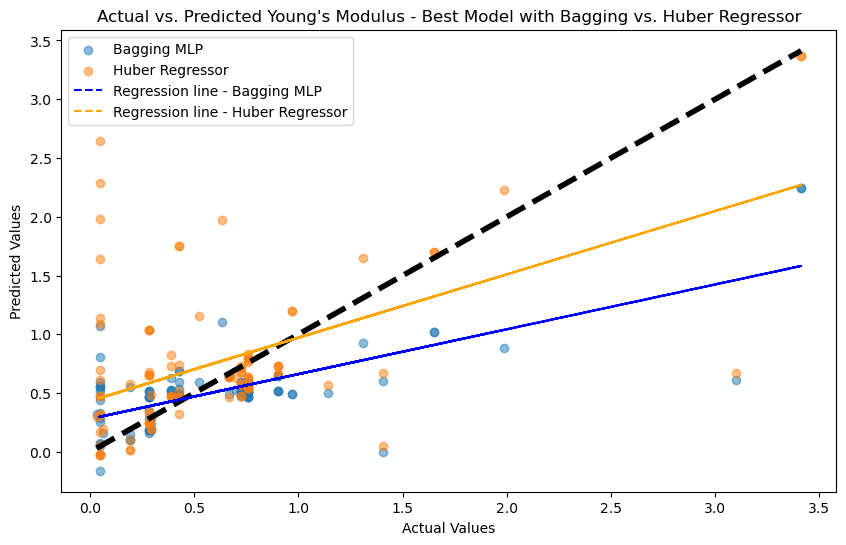

MSE for Huber Regressor: 0.40446410878145245


In [229]:
best_layers = (20, 5)
best_max_iter = 4000
output_dir = 'Images/Aluminum/Young Modulus'
target_variable = "Young's Modulus"
results = compare_bagging_huber(X_train, y_train, X_test, y_test, best_layers, best_max_iter, output_dir, target_variable)
mse_huber = results['mse_huber']
actual = results['actual']
predbag = results['predbag']
predhuber = results['predhuber']
best_model = results['model']
print("MSE for Huber Regressor:", mse_huber)

In [30]:
def evaluate_rank_correlation(actuals, preds):
    """
    Computes the Spearman's rank correlation coefficient between actual and predicted values.

    Parameters:
    - actuals (np.array): Array of actual values.
    - preds (np.array): Array of predicted values.

    Returns:
    - float: Spearman's rank correlation coefficient.
    """
    # Calculate Spearman's rank correlation
    correlation, p_value = spearmanr(actuals, preds)

    print("Spearman's rank correlation coefficient:", correlation)
    print("P-value of the correlation coefficient:", p_value)

    return correlation

In [31]:
def plot_rank_correlation(actuals, preds, save_path=None):
    """
    Plots a scatter plot of actual vs. predicted values and calculates Spearman's rank correlation.
    Optionally saves the plot to a file.

    Parameters:
    - actuals (np.array): Array of actual values.
    - preds (np.array): Array of predicted values.
    - save_path (str, optional): Path to save the plot image file. If None, the plot is not saved.
    """
    # Calculate Spearman's rank correlation
    correlation, _ = spearmanr(actuals, preds)
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=actuals, y=preds, color='blue', edgecolor='w', s=100, alpha=0.7)

    # Plot a 45-degree line
    max_val = max(actuals.max(), preds.max())
    min_val = min(actuals.min(), preds.min())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Perfect Prediction Line')

    # Optional: add a regression line
    sns.regplot(x=actuals, y=preds, scatter=False, color='red', label='Regression Line')
    
    plt.title(f'Scatter Plot of Actual vs. Predicted with Spearman Correlation: {correlation:.2f}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.grid(True)

    if save_path:
        plt.savefig(save_path, format='png', dpi=300)  # Adjust format and dpi as needed
        print(f"Plot saved to {save_path}")
    plt.show()

In [32]:
def show_correlation(model_type, file_path, actuals, preds, target_variable, metal="Aluminum"):
    """General function to evaluate correlation, generate plot, and write LaTeX documentation."""
    rank_correlation = evaluate_rank_correlation(actuals, preds)
    plot_filename = f"{file_path}/{metal}_{target_variable.replace(' ', '_')}_{model_type}MLP.png"
    plot_rank_correlation(actuals, preds, plot_filename)

    latex_code = rf"""
    \begin{{figure}}[h]
        \centering
        \includegraphics[width=0.8\textwidth]{{{plot_filename}}}
        \caption{{Correlation of {model_type} MLP model for {metal} predicting {target_variable}, Spearman Correlation: {rank_correlation:.2f}}}
        \label{{fig:{metal}_{target_variable.replace(' ', '_')}_{model_type}MLP}}
    \end{{figure}}
    """

    # Save the LaTeX code to a file
    tex_filename = plot_filename.replace('.png', '.tex')
    with open(tex_filename, 'w') as f:
        f.write(latex_code)

    return rank_correlation

Spearman's rank correlation coefficient: 0.48016198093199025
P-value of the correlation coefficient: 4.920983576782559e-07
Plot saved to Images/Aluminum/Young Modulus/Aluminum_Young's_Modulus_BaggingMLP.png


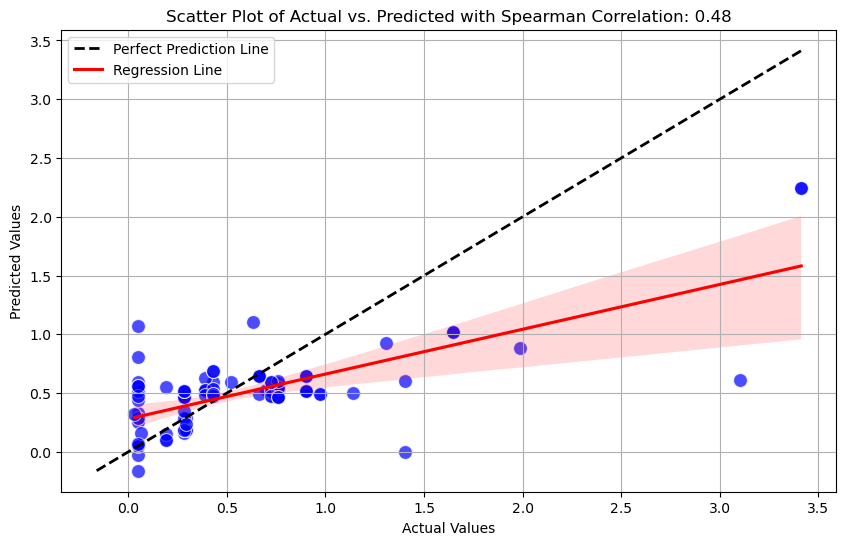

Spearman's rank correlation coefficient: 0.3785151763266541
P-value of the correlation coefficient: 0.00011195071356095266
Plot saved to Images/Aluminum/Young Modulus/Aluminum_Young's_Modulus_HuberMLP.png


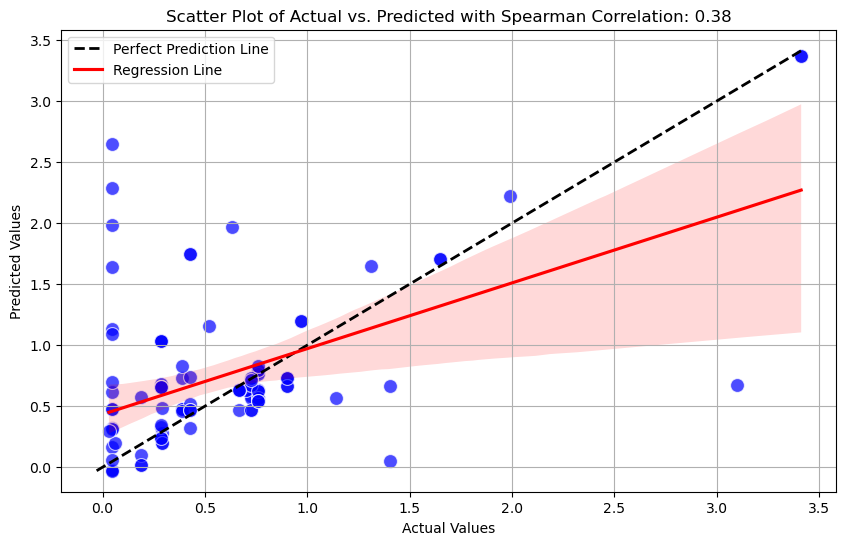

Bagging Model Spearman Correlation: 0.48016198093199025
Huber Model Spearman Correlation: 0.3785151763266541


In [33]:
# Example usage of the generalized function
output_dir = 'Images/Aluminum/Young Modulus'
actuals = actual  # Example actual values from your test set
preds_bagging = predbag  # Example prediction values from the Bagging model
preds_huber = predhuber  # Example prediction values from the Huber model

# For Bagging MLP
correlation_bagging = show_correlation("Bagging", output_dir, actuals, preds_bagging, "Young's Modulus")

# For Huber MLP
correlation_huber = show_correlation("Huber", output_dir, actuals, preds_huber, "Young's Modulus")

print("Bagging Model Spearman Correlation:", correlation_bagging)
print("Huber Model Spearman Correlation:", correlation_huber)

In [34]:
def objective_function(composition):
    # Convert the composition list to a DataFrame with appropriate column names
    composition_df = pd.DataFrame([composition], columns=X_train.columns)
    
    # Predict the Young's modulus for the given composition
    predicted_modulus = best_model.predict(composition_df).flatten()[0]
    
    # Calculate the diversity penalty as the variance of component proportions, excluding the first
    diversity_penalty = np.sum((np.array(composition[1:]) - np.mean(composition[1:]))**2)
    
    # Calculate the final adjusted score (negative for maximization in minimize function)
    adjusted_score = predicted_modulus

    # Return the negated adjusted score
    return -adjusted_score

In [35]:
def optimize_alloy_composition(X_train, output_dir,target_property , metal="Aluminum"):
    """
    Optimizes the composition of an alloy for the best performance based on an objective function.
    
    Parameters:
        X_train (DataFrame): Training data features used for generating initial guesses.
        output_dir (str): Directory to save outputs.
        metal (str): Type of metal being analyzed.
        target_property (str): The property being optimized, e.g., "Young's Modulus".
    
    Returns:
        tuple: Best composition and its score.
    """
    # Setting constraints and bounds
    bounds = [(75, 100)] + [(0, 100) for _ in range(len(X_train.columns) - 1)]
    cons = {'type': 'eq', 'fun': lambda x: 100 - np.sum(x)}

    results = []
    best_score = -np.inf
    best_composition = None

    # Perform optimization multiple times
    for i in range(25):
        initial_composition = [75] + [np.random.rand() * 25 for _ in range(len(X_train.columns) - 1)]
        initial_composition = np.array(initial_composition)
        initial_composition *= 100 / np.sum(initial_composition)

        result = minimize(
            objective_function,
            initial_composition,
            method='SLSQP',
            bounds=bounds,
            constraints=cons,
            options={'disp': False, 'maxiter': 1000}
        )

        if result.success:
            adjusted_score = -result.fun  # Assume maximization
            results.append((result.x, adjusted_score))
            if adjusted_score > best_score:
                best_score = adjusted_score
                best_composition = result.x

    # Save results
    results_path = f'Al_model_data/modulus_optimization_results.csv'
    os.makedirs(os.path.dirname(results_path), exist_ok=True)
    with open(results_path, 'w') as f:
        for idx, (composition, score) in enumerate(results):
            f.write(f"Alloy {idx+1}: Composition = {composition}, Score = {score}\n")

    # Plot the best alloy composition
    plt.figure(figsize=(10, 6))
    bars = plt.bar(X_train.columns, best_composition, color='blue')
    plt.xlabel('Element')
    plt.ylabel('Percentage')
    plt.title(f'Best Alloy Composition - Score: {best_score:.4f}')
    plt.xticks(rotation=45)
    for bar, percentage in zip(bars, best_composition):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{percentage:.2f}', va='bottom')
    plt.tight_layout()
    plot_path = f"{output_dir}/{metal}_{target_property.replace(' ', '_')}_BestAlloyComposition.png"
    plt.savefig(plot_path)
    plt.show()

    # LaTeX figure
    latex_code = rf"""
    \begin{{figure}}[h]
        \centering
        \includegraphics[width=0.8\textwidth]{{{plot_path}}}
        \caption{{Best Alloy Composition of {metal} based alloys predicting the {target_property}}}
        \label{{fig:{metal}_{target_property.replace(' ', '_')}_BestAlloyComposition}}
    \end{{figure}}
    """
    tex_path = f"{output_dir}/{metal}_{target_property.replace(' ', '_')}_BestAlloyComposition.tex"
    with open(tex_path, 'w') as f:
        f.write(latex_code)

    return best_composition, best_score

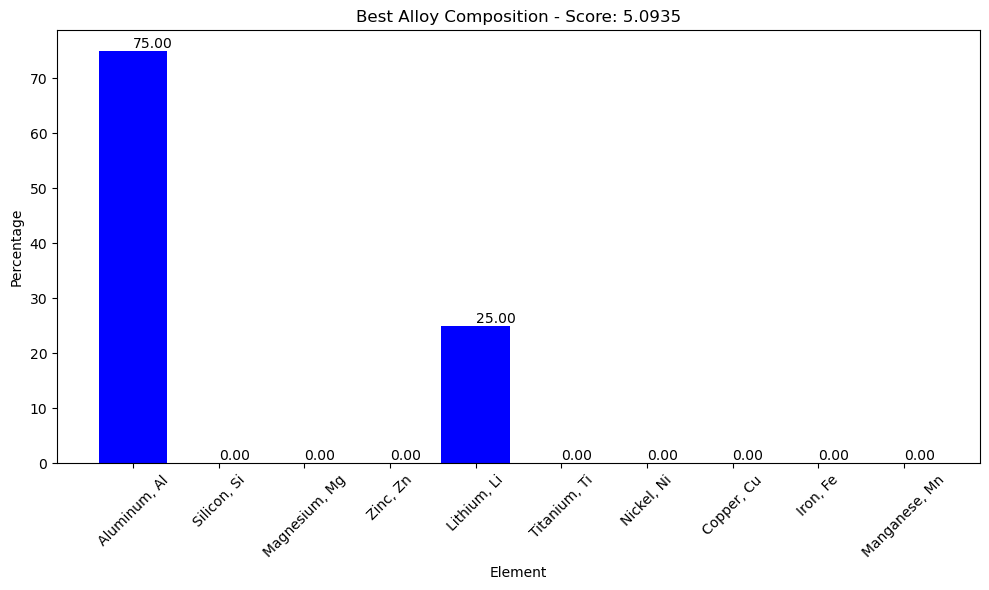

Best Composition: [75.  0.  0.  0. 25.  0.  0.  0.  0.  0.]
Best Score: 5.093507801756473


In [36]:
output_dir = 'Images/Aluminum/Young Modulus'
metal = "Aluminum"
target_property = "Young's Modulus"
best_composition, best_score = optimize_alloy_composition(X_train, output_dir, target_property, metal)
print("Best Composition:", best_composition)
print("Best Score:", best_score)

## Yield Strength

### Data Preperation

In [37]:
# Assuming df is your DataFrame and it contains the columns 'Yield Strength' and 'Density'
df['Yield Strength'] = df['Yield Strength'].apply(extract_numeric)

# List all columns to keep (metal percentages and Yield Strength)
columns_to_keep = ['Yield Strength'] + [col for col in df.columns if ',' in col]

# Create a new dataframe with only these columns
metals_and_yield = df[columns_to_keep]

# Check for missing values in the new dataset
missing_values_metals = metals_and_yield.isnull().sum()
missing_values_metals[missing_values_metals > 0], metals_and_yield.head()

(Series([], dtype: int64),
    Yield Strength  Aluminum, Al  Chromium, Cr  Copper, Cu  Iron, Fe  \
 0        1.984999          91.4          0.18        1.20       0.2   
 1        0.738788          95.9          0.20        0.30       0.7   
 2        0.100160          97.7          0.15        0.04       0.4   
 3        0.753909          97.7          0.15        0.10       0.4   
 4        1.131198          94.7          0.06        0.10       0.4   
 
    Magnesium, Mg  Manganese, Mn  Silicon, Si  Titanium, Ti  Zinc, Zn  ...  \
 0            2.1           0.10         0.15          0.10       5.1  ...   
 1            0.2           0.30         0.60          0.10       0.4  ...   
 2            2.2           0.01         0.00          0.00       0.1  ...   
 3            2.2           0.10         0.25          0.00       0.1  ...   
 4            1.0           0.20         0.35          0.01       4.0  ...   
 
    Nickel, Ni  Gallium, Ga  Oxygen, O  Beryllium, Be  Bismuth, Bi  L

In [38]:
# Splitting the dataset into features and target variable
X = metals_and_yield.drop('Yield Strength', axis=1)
y = metals_and_yield['Yield Strength']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.head(), y_train.head()

(     Aluminum, Al  Chromium, Cr  Copper, Cu  Iron, Fe  Magnesium, Mg  \
 438          97.0          0.00        0.15      0.80           0.40   
 56           97.0          0.00        0.15      0.80           0.40   
 351          97.3          0.10        0.40      0.50           0.70   
 222          97.8          0.04        0.15      0.70           0.80   
 362          99.6          0.00        0.05      0.35           0.03   
 
      Manganese, Mn  Silicon, Si  Titanium, Ti  Zinc, Zn  Zirconium, Zr  ...  \
 438           0.10         0.20          0.00      0.20            0.0  ...   
 56            0.10         0.20          0.00      0.20            0.0  ...   
 351           0.05         0.80          0.15      0.50            0.0  ...   
 222           0.15         0.40          0.15      0.25            0.0  ...   
 362           0.03         0.25          0.03      0.05            0.0  ...   
 
      Nickel, Ni  Gallium, Ga  Oxygen, O  Beryllium, Be  Bismuth, Bi  Lead, Pb

### Feature Selection

#### Random Forest Feature Importance

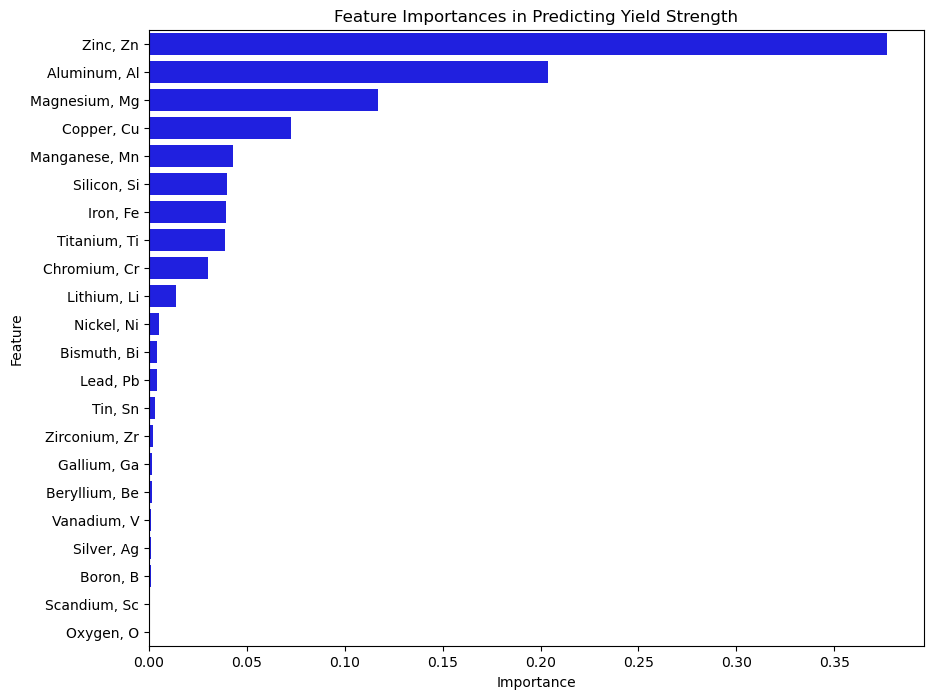

(0.2518325345886015,
           Feature  Importance
 8        Zinc, Zn    0.376922
 0    Aluminum, Al    0.203804
 4   Magnesium, Mg    0.117094
 2      Copper, Cu    0.072421
 5   Manganese, Mn    0.043015
 6     Silicon, Si    0.039771
 3        Iron, Fe    0.039568
 7    Titanium, Ti    0.038811
 1    Chromium, Cr    0.030139
 20    Lithium, Li    0.014021
 12     Nickel, Ni    0.005180
 16    Bismuth, Bi    0.004200
 17       Lead, Pb    0.004019
 18        Tin, Sn    0.002970
 9   Zirconium, Zr    0.002015
 13    Gallium, Ga    0.001737
 15  Beryllium, Be    0.001433
 10    Vanadium, V    0.001147
 21     Silver, Ag    0.000875
 11       Boron, B    0.000857
 19   Scandium, Sc    0.000000
 14      Oxygen, O    0.000000)

In [39]:
output_dir = "Images/Aluminum/Yield Strength"
train_and_evaluate_simple_rf(X_train, y_train, X_test, y_test, output_dir, "Yield Strength")

#### Combination Neural Network Feature Combination Importance

Loading existing results...
4/4 [==============================] - 0s 1ms/step


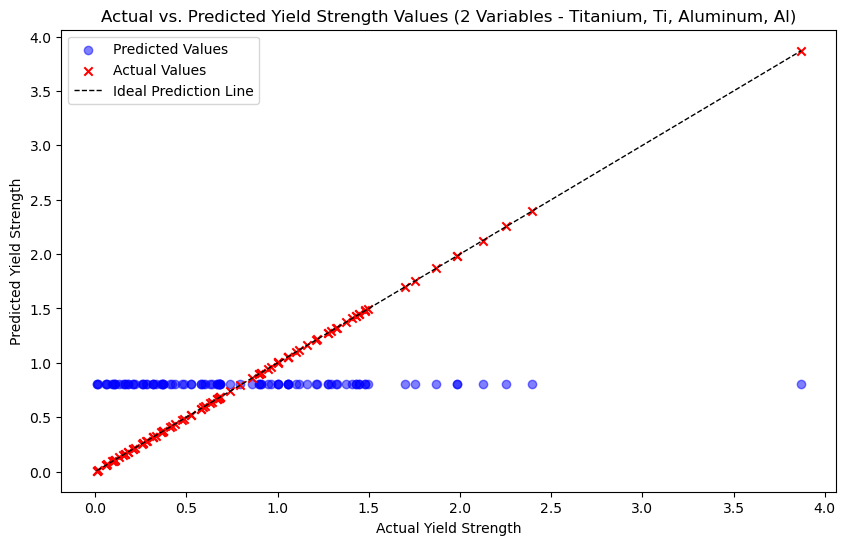

Best combination including Aluminum, Al: ('Titanium, Ti', 'Aluminum, Al'), MSE: 0.4089514315128326
Graph and LaTeX file saved with element pair in names: Images/Aluminum/Yield Strength/Aluminum_Yield_Strength_2VariableMLP.png and Images/Aluminum/Yield Strength/Aluminum_Yield_Strength_2VariableMLP.tex


In [40]:
top_features = ['Silicon, Si', 'Copper, Cu', 'Iron, Fe', 
                'Magnesium, Mg', 'Zinc, Zn', 'Manganese, Mn', 'Bismuth, Bi', 'Titanium, Ti', 
                'Lithium, Li', 'Nickel, Ni', 'Chromium, Cr', 'Zirconium, Zr', 'Vanadium, V', 
                'Tin, Sn', 'Lead, Pb', 'Scandium, Sc', 'Beryllium, Be', 'Gallium, Ga', 
                'Boron, B', 'Silver, Ag']
fixed_feature = 'Aluminum, Al'
file_path = 'Al_model_data/mse_scores_with_aluminum_2_features_yield.csv'
plotdir = 'Images/Aluminum/Yield Strength'
process2VariableMLP(metals_and_yield, top_features, fixed_feature, "Yield Strength", file_path, plotdir)

Loading existing results...
4/4 [==============================] - 0s 1ms/step


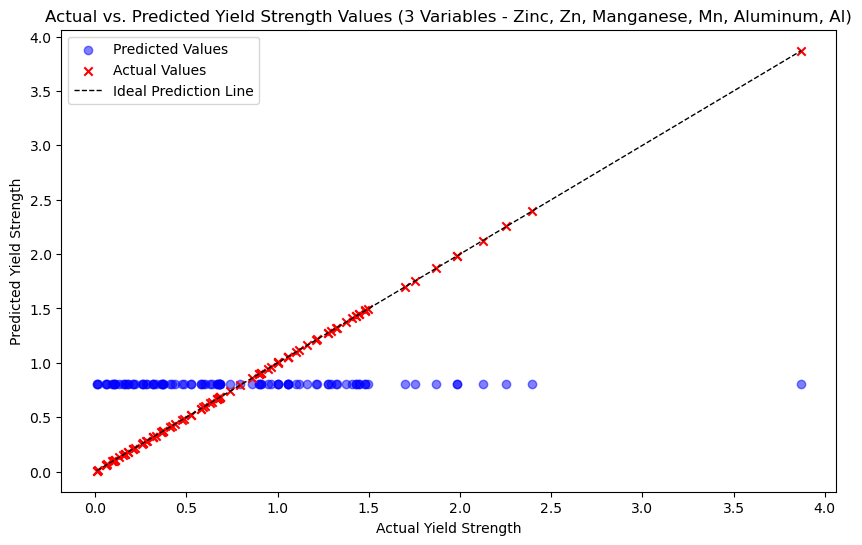

Best combination including Aluminum, Al: ('Zinc, Zn', 'Manganese, Mn', 'Aluminum, Al'), MSE: 0.3049044907093048
Graph and LaTeX file saved with element pair in names: Images/Aluminum/Yield Strength/Aluminum_Yield_Strength_3VariableMLP.png and Images/Aluminum/Yield Strength/Aluminum_Yield_Strength_3VariableMLP.tex


In [41]:
top_features = ['Zinc, Zn', 'Magnesium, Mg', 'Copper, Cu', 'Manganese, Mn', 'Silicon, Si', 'Iron, Fe', 'Titanium, Ti', 'Chromium, Cr', 'Lithium, Li', 'Nickel, Ni']
fixed_feature = 'Aluminum, Al'
file_path = 'Al_model_data/mse_scores_with_aluminum_3_features_yield.csv'
plotdir = 'Images/Aluminum/Yield Strength'
process3VariableMLP(metals_and_yield, top_features, fixed_feature, "Yield Strength", file_path, plotdir)

#### Correlation Matrix

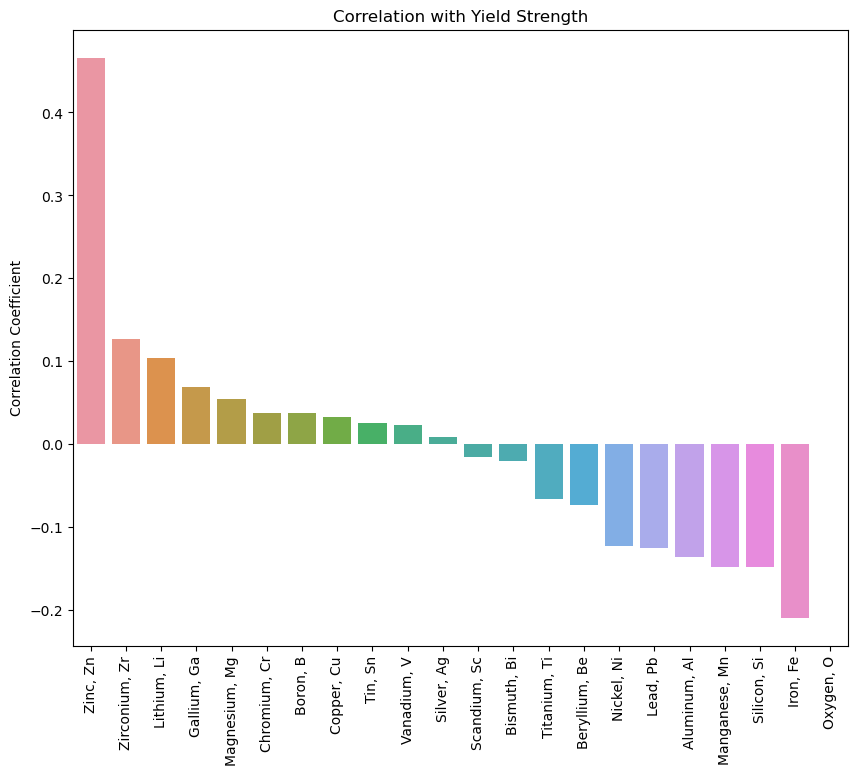

Zinc, Zn         0.465978
Zirconium, Zr    0.127217
Lithium, Li      0.103528
Gallium, Ga      0.068728
Magnesium, Mg    0.053910
Chromium, Cr     0.038155
Boron, B         0.037343
Copper, Cu       0.032956
Tin, Sn          0.025065
Vanadium, V      0.022732
Silver, Ag       0.008760
Scandium, Sc    -0.015093
Bismuth, Bi     -0.020770
Titanium, Ti    -0.066277
Beryllium, Be   -0.073391
Nickel, Ni      -0.122191
Lead, Pb        -0.125178
Aluminum, Al    -0.136337
Manganese, Mn   -0.147416
Silicon, Si     -0.148483
Iron, Fe        -0.209077
Oxygen, O             NaN
Name: Yield Strength, dtype: float64

In [42]:
target_feature = "Yield Strength"
output_dir = "Images/Aluminum/Yield Strength"
visualize_correlation(metals_and_yield, target_feature, output_dir)

#### Regression

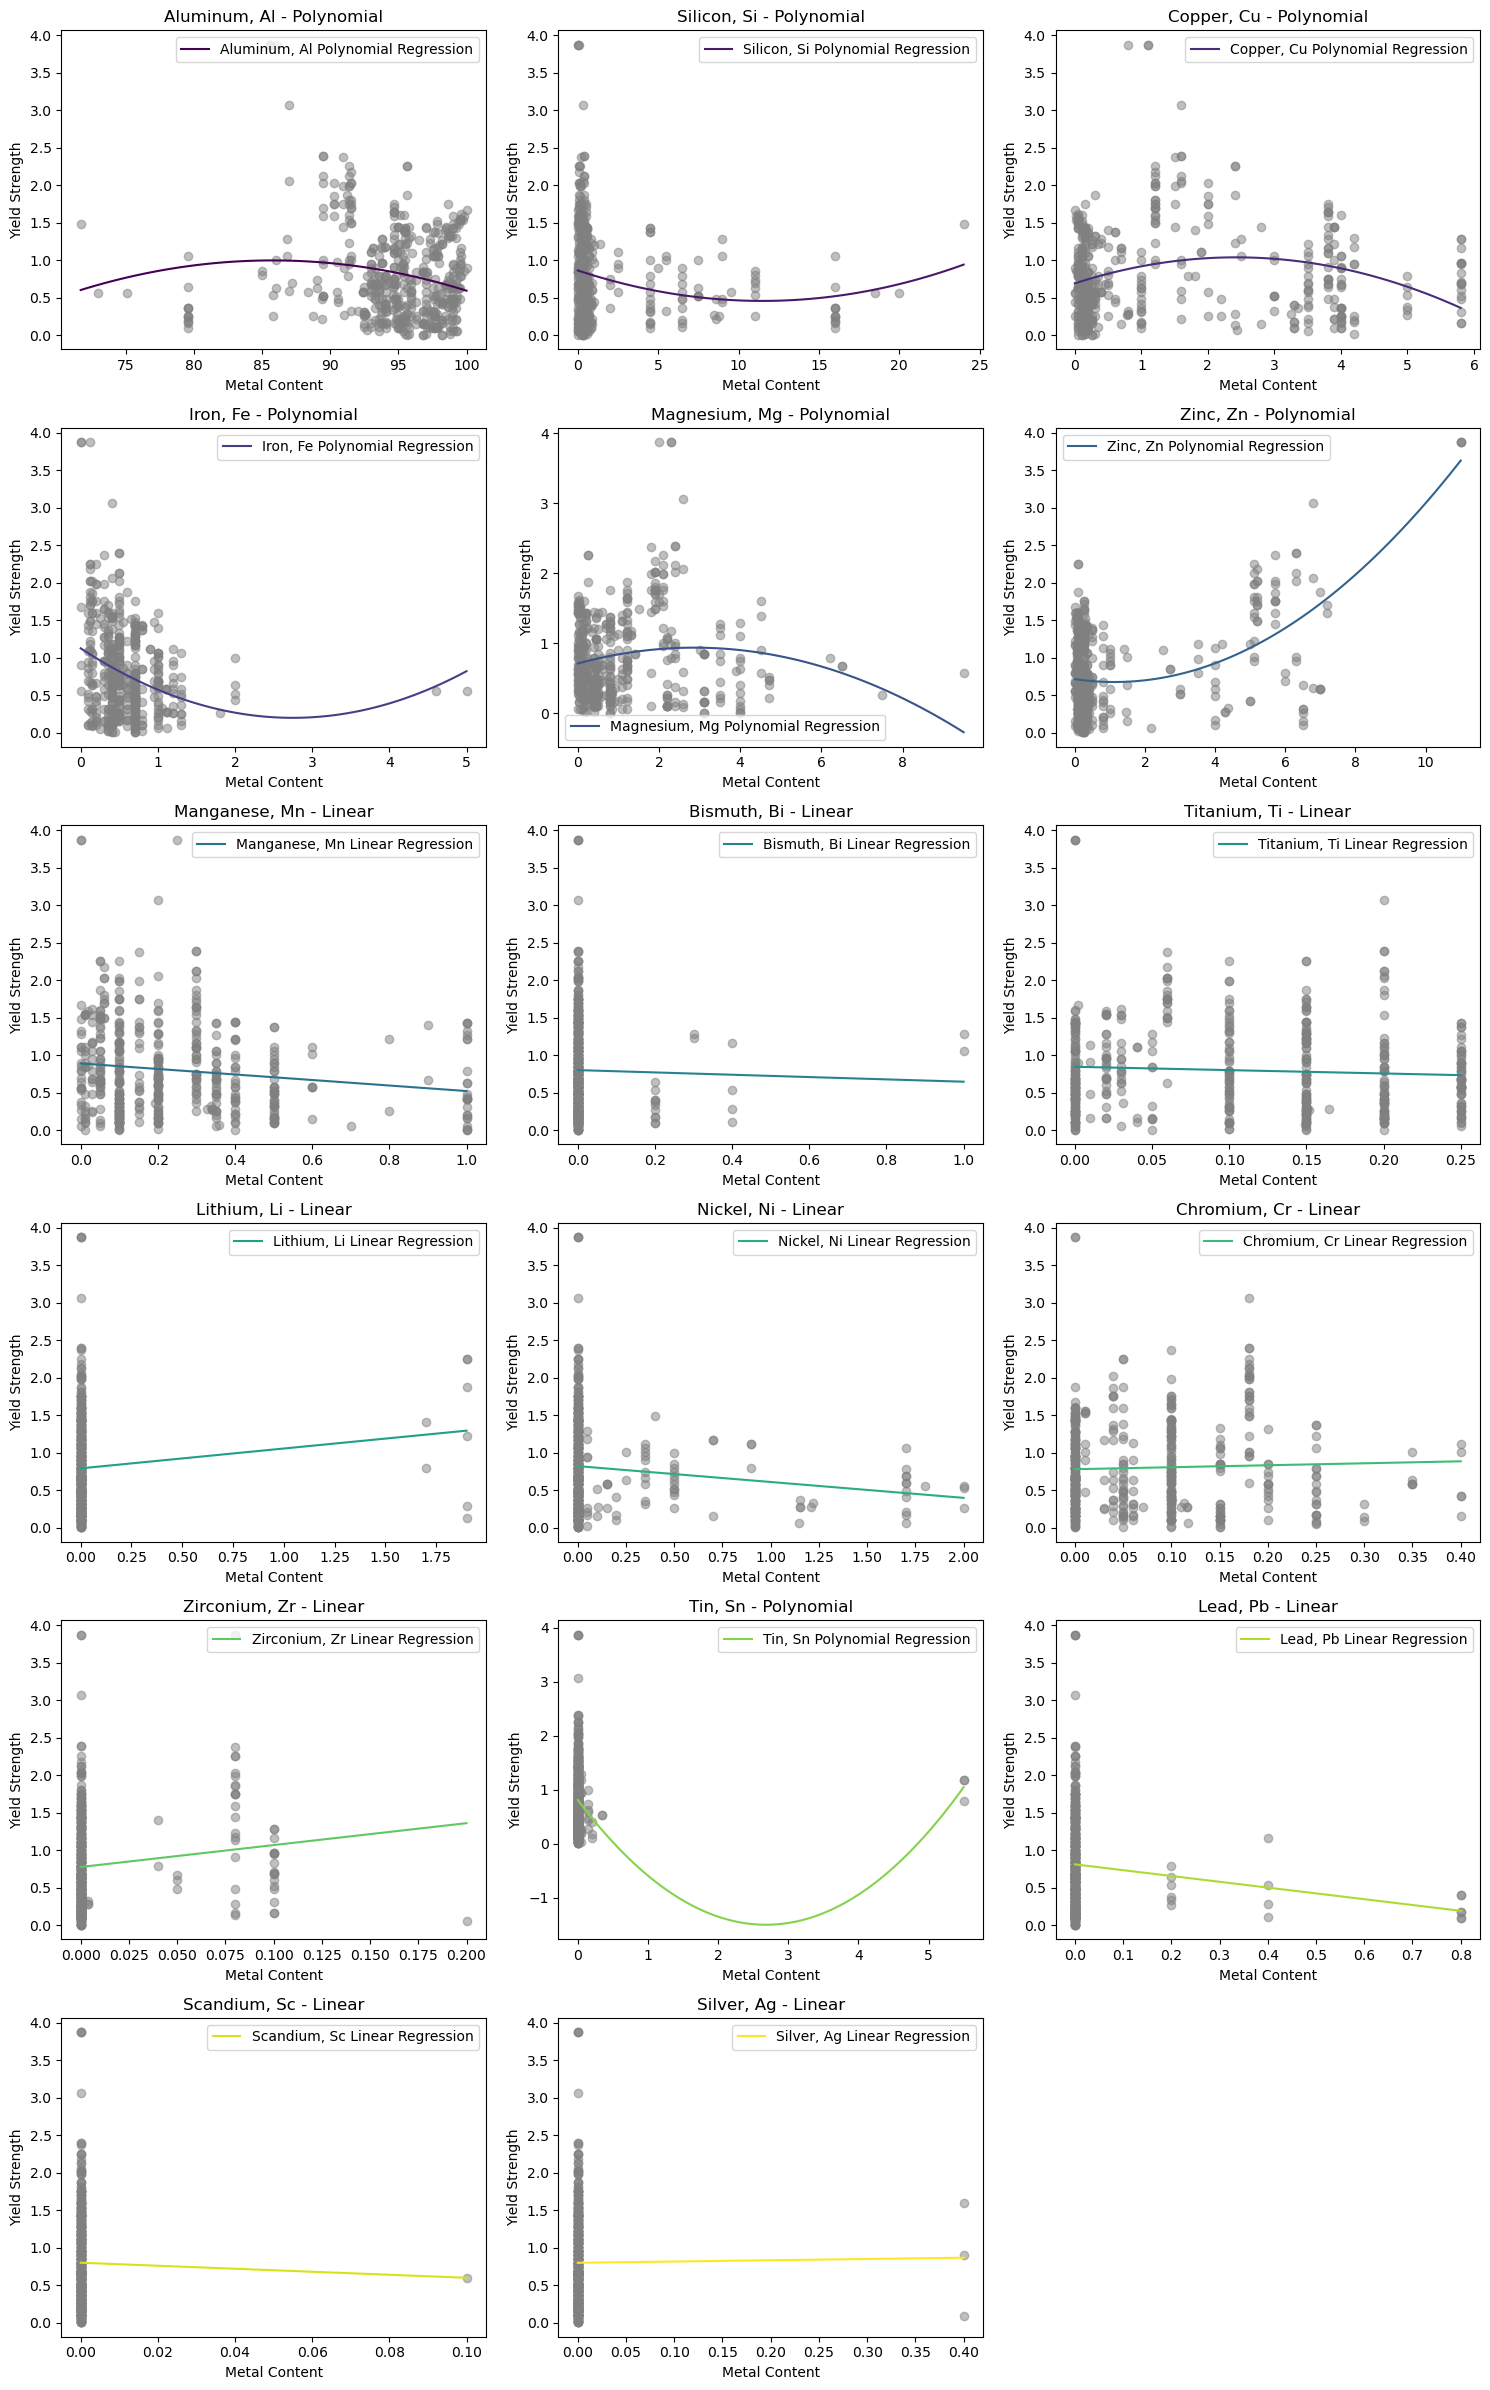

(            Metal  Coefficient     Effect
 0    Aluminum, Al    -0.001993  Decreases
 1     Silicon, Si     0.003084  Increases
 2      Copper, Cu    -0.059032  Decreases
 3        Iron, Fe     0.122579  Increases
 4   Magnesium, Mg    -0.027504  Decreases
 5        Zinc, Zn     0.030260  Increases
 6   Manganese, Mn    -0.367732  Decreases
 7     Bismuth, Bi    -0.154527  Decreases
 8    Titanium, Ti    -0.445256  Decreases
 9     Lithium, Li     0.264238  Increases
 10     Nickel, Ni    -0.211399  Decreases
 11   Chromium, Cr     0.262205  Increases
 12  Zirconium, Zr     2.919177  Increases
 13        Tin, Sn     0.321281  Increases
 14       Lead, Pb    -0.773738  Decreases
 15   Scandium, Sc    -2.003616  Decreases
 16     Silver, Ag     0.168195  Increases,
 'Images/Aluminum/Yield Strength/Aluminum_Yield_Strength_IndividualElementRegression.png')

In [43]:
metals = ['Aluminum, Al', 'Silicon, Si', 'Copper, Cu', 'Iron, Fe', 
          'Magnesium, Mg', 'Zinc, Zn', 'Manganese, Mn', 'Bismuth, Bi', 'Titanium, Ti', 
          'Lithium, Li', 'Nickel, Ni', 'Chromium, Cr', 'Zirconium, Zr', 'Vanadium, V', 
          'Tin, Sn', 'Lead, Pb', 'Scandium, Sc', 'Beryllium, Be', 'Gallium, Ga', 
          'Boron, B', 'Silver, Ag']
target_feature = "Yield Strength"
plot_dir = "Images/Aluminum/Yield Strength"
evaluate_and_visualize_impact(metals_and_yield, metals, target_feature, plot_dir)

In [44]:
## Splitting the DataFrame into positive and negative subsets
#positive_df = impact_summary[impact_summary['Coefficient'] > 0].copy()
#negative_df = impact_summary[impact_summary['Coefficient'] < 0].copy()
#
## Sorting each subset
#positive_df.sort_values(by='Coefficient', ascending=False, inplace=True)
#negative_df.sort_values(by='Coefficient', ascending=False, inplace=True)  # Sort negatives in descending order by value
#
## Concatenating back into a single DataFrame
#sorted_impact_summary = pd.concat([positive_df, negative_df], axis=0)
#
## Define colors based on coefficient sign and set edge colors for better visibility
#colors = ['green' if x > 0 else 'red' for x in sorted_impact_summary['Coefficient']]
#edge_colors = ['darkgreen' if x > 0 else 'darkred' for x in sorted_impact_summary['Coefficient']]
#
## Set up the plot
#plt.figure(figsize=(10, 8))
#bars = plt.barh(sorted_impact_summary['Metal'], sorted_impact_summary['Coefficient'], color=colors, edgecolor=edge_colors)
#plt.xlabel('Coefficient Value')
#plt.title('Impact of Each Metal on Yield Strength')
#
## Invert y-axis to have the largest impact at the top
#plt.gca().invert_yaxis()
#
## Add text labels to bars for exact coefficient values
#for bar, value in zip(bars, sorted_impact_summary['Coefficient']):
#    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{value:.2f}', va='center', 
#             ha='right' if value < 0 else 'left')
#
## Show the plot
#plt.savefig('Images/Aluminum/Yield Strength/IndividualElementImpact.png')
#plt.show()
#
#latex_code = r"""
#\begin{figure}[h]
#    \centering
#    \includegraphics[width=0.8\textwidth]{Images/Aluminum/Yield Strength/IndividualElementImpact.png}
#    \caption{Individual Element Impact of Aluminum based alloys predicting the Yield Strength}
#    \label{fig:IndividualElementImpact_Al_YS}
#\end{figure}
#"""
#
## Write the LaTeX code to a .tex file
#with open('Images/Aluminum/Yield Strength/IndividualElementImpact.tex', 'w') as f:
#    f.write(latex_code)
#
## Optionally, print the DataFrame for a tabular view
#print(sorted_impact_summary[['Metal', 'Coefficient', 'Effect']])

### <span style="color:lime">Optimizing Yield Strength</span>

#### <span style="color:red">Random Forest</span>

In [45]:
selected_features = ['Aluminum, Al', 'Zinc, Zn', 'Magnesium, Mg', 'Copper, Cu', 'Manganese, Mn', 'Silicon, Si', 'Iron, Fe', 'Titanium, Ti', 'Chromium, Cr', 'Lithium, Li', 'Nickel, Ni']
target_variable = 'Yield Strength'
results = analyze_alloy_strength(metals_and_yield, selected_features, target_variable)
print(results)
model = results['model']

{'mse': 0.2483398603372864, 'rmse': 0.4983370950845285, 'max_youngs_modulus': 3.5126672179825396, 'strongest_composition': Aluminum, Al     85.6
Zinc, Zn         11.0
Magnesium, Mg     2.3
Copper, Cu        1.1
Manganese, Mn     0.0
Silicon, Si       0.0
Iron, Fe          0.0
Titanium, Ti      0.0
Chromium, Cr      0.0
Lithium, Li       0.0
Nickel, Ni        0.0
Name: 384, dtype: float64, 'model': RandomForestRegressor(random_state=42)}


In [46]:
output_path = "Al_model_data/all_hypothetical_combinations_with_predictions_aluminum_yield.csv"
metals = ['Zinc, Zn', 'Magnesium, Mg', 'Copper, Cu', 'Manganese, Mn', 'Silicon, Si', 'Iron, Fe', 'Titanium, Ti', 'Chromium, Cr', 'Lithium, Li', 'Nickel, Ni']
al_increments = np.arange(75, 101, 5)
other_increments = np.arange(0, 26, 5)

top_combinations = generate_and_predict_alloy_strength(model, output_path, metals, al_increments, other_increments, 'Yield Strength')
print("Top 10 Yield Strength Combinations:")
print(top_combinations.head(10))  # Print only the top 10

Loaded results from existing file.
Top 10 Yield Strength Combinations:
      Aluminum, Al  Zinc, Zn  Magnesium, Mg  Copper, Cu  Manganese, Mn  \
1930            75        10              5           5              0   
1931            75        10              5           5              0   
1937            75        10              5          10              0   
1945            75        10             10           5              0   
1990            75        15              5           5              0   
2705            80        10              5           5              0   
1932            75        10              5           5              0   
1936            75        10              5           5              5   
1935            75        10              5           5              0   
1934            75        10              5           5              0   

      Silicon, Si  Iron, Fe  Titanium, Ti  Chromium, Cr  Lithium, Li  \
1930            0         0             0 

#### <span style="color:red">MLP</span>

In [47]:
selected_features = ['Aluminum, Al', 'Zinc, Zn', 'Magnesium, Mg', 'Copper, Cu', 'Manganese, Mn', 'Silicon, Si', 'Iron, Fe', 'Titanium, Ti', 'Chromium, Cr', 'Lithium, Li', 'Nickel, Ni']
target_variable = "Yield Strength"
layer_configurations = [
    (30, 3, 1), (40, 2), (10, 10), (3, 10, 2),
    (10,), (20,), (30,), (40,), (50,),
    (8,), (8, 8), (8, 5, 2),
    (5, 5), (10, 10), (20, 5), (5, 20),
    (15, 6), (6, 6), (6, 6, 2),
    (5,), (5, 10, 2), (10, 10), (5, 10),
    (2,), (2,2), (2,2,2), (2,2,2,2)
]
max_iter_options = [4000]
results_path = 'Al_model_data/grid_search_aluminium_yield_results.csv'

# Call the grid search function
result = perform_grid_search_nn(metals_and_yield, selected_features, target_variable, layer_configurations, max_iter_options, results_path)
X_train, X_test, y_train, y_test = result['X_train'], result['X_test'], result['y_train'], result['y_test']
grid_search_results = result['results_df']
print("Grid search results DataFrame:")
print(grid_search_results)

# Sort the results DataFrame by the 'MSE' column in ascending order
sorted_results = grid_search_results.sort_values(by='MSE', ascending=True)

# Print the sorted results
print("Sorted Grid Search Results by MSE:")
print(sorted_results)

Loaded existing results from file.
Grid search results DataFrame:
          Layers  Max_iter       MSE
0     (30, 3, 1)      4000  0.377810
1        (40, 2)      4000  0.394338
2       (10, 10)      4000  0.357095
3     (3, 10, 2)      4000  0.385388
4          (10,)      4000  0.282690
5          (20,)      4000  0.260801
6          (30,)      4000  0.272335
7          (40,)      4000  0.389734
8          (50,)      4000  0.440261
9           (8,)      4000  0.287340
10        (8, 8)      4000  0.315229
11     (8, 5, 2)      4000  0.387622
12        (5, 5)      4000  0.311404
13      (10, 10)      4000  0.357095
14       (20, 5)      4000  0.291571
15       (5, 20)      4000  0.330083
16       (15, 6)      4000  0.346498
17        (6, 6)      4000  0.308415
18     (6, 6, 2)      4000  0.359090
19          (5,)      4000  0.308914
20    (5, 10, 2)      4000  0.354070
21      (10, 10)      4000  0.357095
22       (5, 10)      4000  0.366575
23          (2,)      4000  0.395109
24       

/Users/lukerickard/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Mean Squared Error - Huber Regressor: 0.2859947613196358


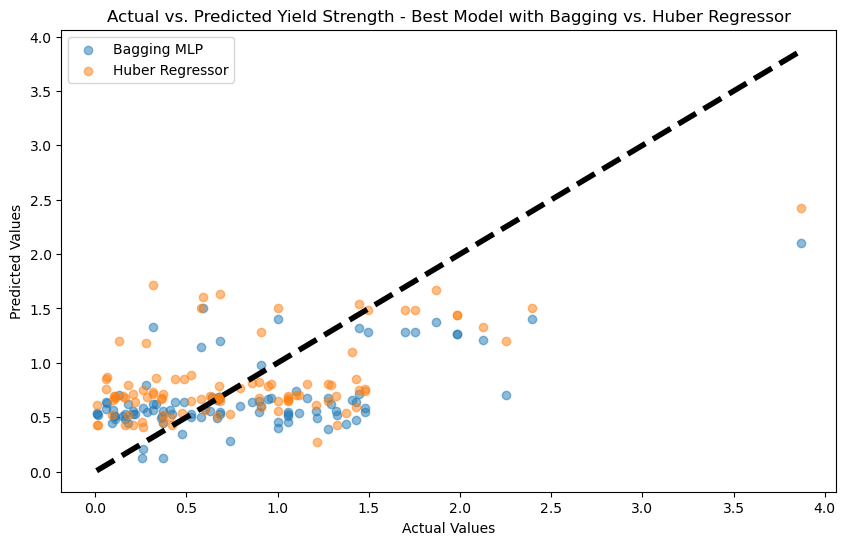

MSE for Huber Regressor: 0.2859947613196358


In [48]:
best_layers = (20, 5)
best_max_iter = 4000
output_dir = 'Images/Aluminum/Yield Strength'
target_variable = "Yield Strength"
results = compare_bagging_huber(X_train, y_train, X_test, y_test, best_layers, best_max_iter, output_dir, target_variable)
mse_huber = results['mse_huber']
actual = results['actual']
predbag = results['predbag']
predhuber = results['predhuber']
best_model = results['model']
print("MSE for Huber Regressor:", mse_huber)

Spearman's rank correlation coefficient: 0.3862323237194051
P-value of the correlation coefficient: 7.863615059330693e-05
Plot saved to Images/Aluminum/Yield Strength/Aluminum_Yield_Strength_BaggingMLP.png


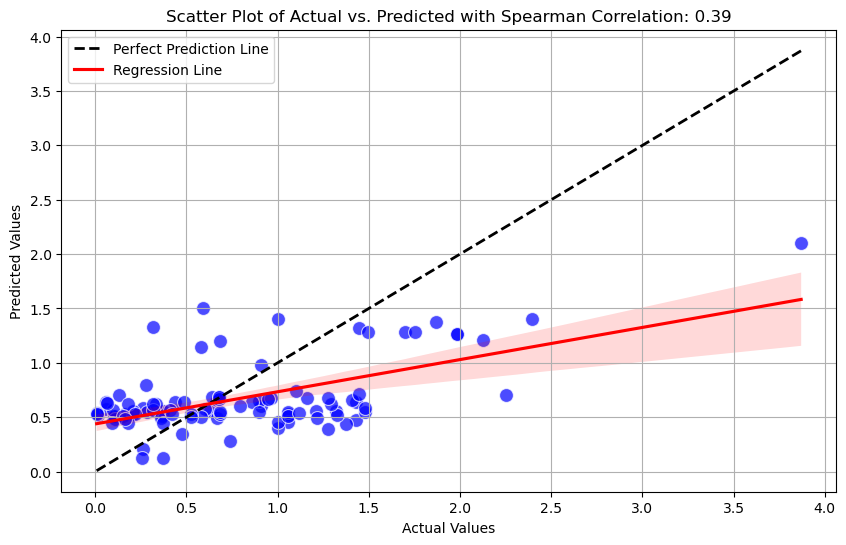

Spearman's rank correlation coefficient: 0.354046296742788
P-value of the correlation coefficient: 0.0003241926592859856
Plot saved to Images/Aluminum/Yield Strength/Aluminum_Yield_Strength_HuberMLP.png


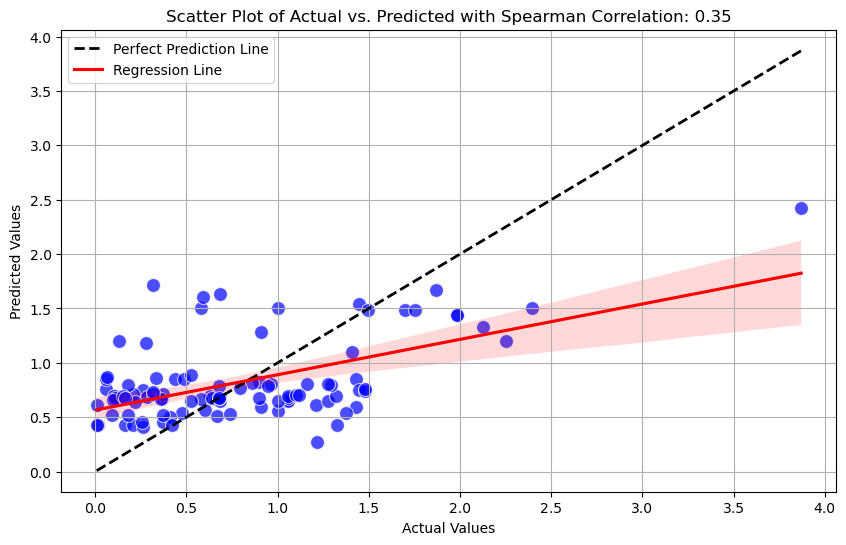

Bagging Model Spearman Correlation: 0.3862323237194051
Huber Model Spearman Correlation: 0.354046296742788


In [49]:
# Example usage of the generalized function
output_dir = 'Images/Aluminum/Yield Strength'
actuals = actual  # Example actual values from your test set
preds_bagging = predbag  # Example prediction values from the Bagging model
preds_huber = predhuber  # Example prediction values from the Huber model

# For Bagging MLP
correlation_bagging = show_correlation("Bagging", output_dir, actuals, preds_bagging, "Yield Strength")

# For Huber MLP
correlation_huber = show_correlation("Huber", output_dir, actuals, preds_huber, "Yield Strength")

print("Bagging Model Spearman Correlation:", correlation_bagging)
print("Huber Model Spearman Correlation:", correlation_huber)

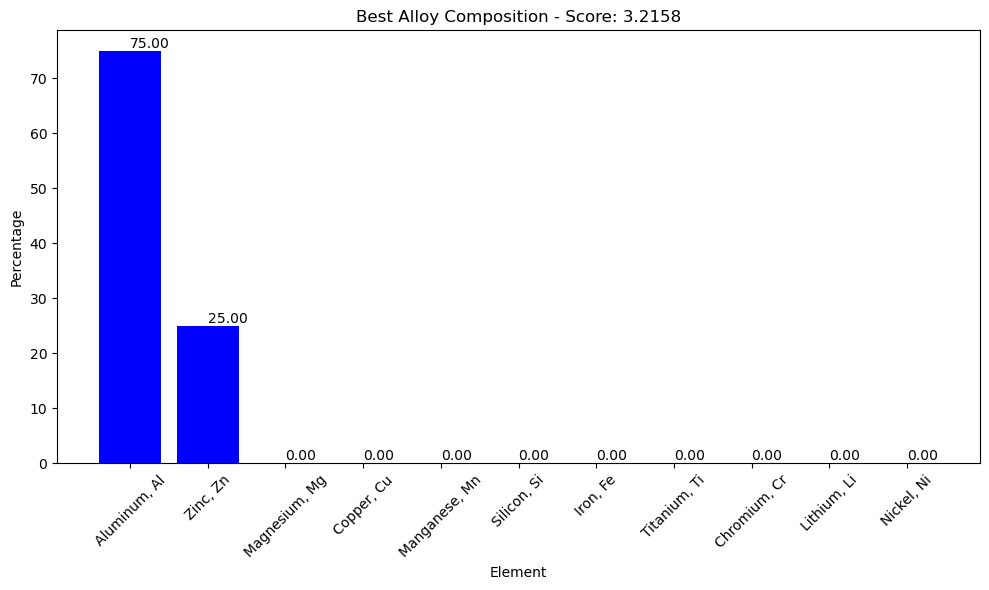

Best Composition: [7.50000000e+01 2.50000000e+01 7.02369816e-12 0.00000000e+00
 0.00000000e+00 1.76954980e-12 2.76389492e-13 6.59119095e-13
 0.00000000e+00 0.00000000e+00 0.00000000e+00]
Best Score: 3.2158387303301454


In [50]:
output_dir = 'Images/Aluminum/Yield Strength'
target_property = "Yield Strength"
best_composition, best_score = optimize_alloy_composition(X_train, output_dir, target_property, metal)
print("Best Composition:", best_composition)
print("Best Score:", best_score)

## Tensile Strength

### Data Preperation

In [51]:
# Assuming df1 is your DataFrame and it contains the columns 'Tensile Strength'
df['Tensile Strength'] = df['Tensile Strength'].apply(extract_numeric)

# List all columns to keep (metal percentages and Tensile Strength)
columns_to_keep = ['Tensile Strength'] + [col for col in df.columns if ',' in col]

# Create a new dataframe with only these columns
metals_and_tensile = df[columns_to_keep]

# Check for missing values in the new dataset
missing_values_metals = metals_and_tensile.isnull().sum()
missing_values_metals[missing_values_metals > 0], metals_and_tensile.head()

(Series([], dtype: int64),
    Tensile Strength  Aluminum, Al  Chromium, Cr  Copper, Cu  Iron, Fe  \
 0          1.931287          91.4          0.18        1.20       0.2   
 1          1.055390          95.9          0.20        0.30       0.7   
 2          0.229927          97.7          0.15        0.04       0.4   
 3          0.280360          97.7          0.15        0.10       0.4   
 4          0.732709          94.7          0.06        0.10       0.4   
 
    Magnesium, Mg  Manganese, Mn  Silicon, Si  Titanium, Ti  Zinc, Zn  ...  \
 0            2.1           0.10         0.15          0.10       5.1  ...   
 1            0.2           0.30         0.60          0.10       0.4  ...   
 2            2.2           0.01         0.00          0.00       0.1  ...   
 3            2.2           0.10         0.25          0.00       0.1  ...   
 4            1.0           0.20         0.35          0.01       4.0  ...   
 
    Nickel, Ni  Gallium, Ga  Oxygen, O  Beryllium, Be  Bi

In [52]:
# Splitting the dataset into features and target variable
X = metals_and_tensile.drop('Tensile Strength', axis=1)
y = metals_and_tensile['Tensile Strength']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.head(), y_train.head()

(     Aluminum, Al  Chromium, Cr  Copper, Cu  Iron, Fe  Magnesium, Mg  \
 438          97.0          0.00        0.15      0.80           0.40   
 56           97.0          0.00        0.15      0.80           0.40   
 351          97.3          0.10        0.40      0.50           0.70   
 222          97.8          0.04        0.15      0.70           0.80   
 362          99.6          0.00        0.05      0.35           0.03   
 
      Manganese, Mn  Silicon, Si  Titanium, Ti  Zinc, Zn  Zirconium, Zr  ...  \
 438           0.10         0.20          0.00      0.20            0.0  ...   
 56            0.10         0.20          0.00      0.20            0.0  ...   
 351           0.05         0.80          0.15      0.50            0.0  ...   
 222           0.15         0.40          0.15      0.25            0.0  ...   
 362           0.03         0.25          0.03      0.05            0.0  ...   
 
      Nickel, Ni  Gallium, Ga  Oxygen, O  Beryllium, Be  Bismuth, Bi  Lead, Pb

### Feature Selection

#### Random Forest Feature Importance

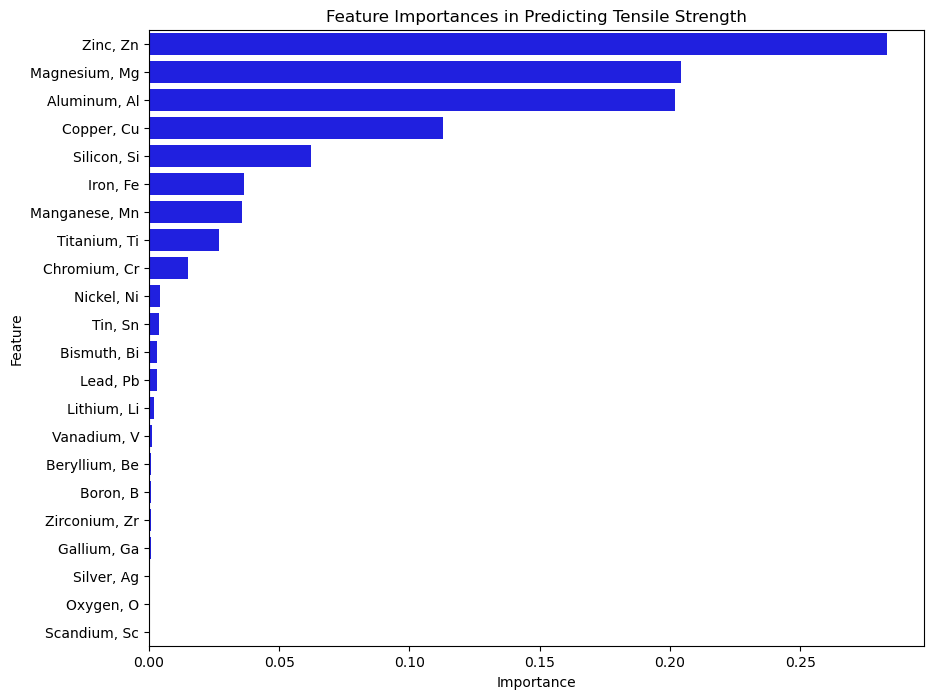

(0.19935471526596182,
           Feature  Importance
 8        Zinc, Zn    0.283314
 4   Magnesium, Mg    0.204378
 0    Aluminum, Al    0.201815
 2      Copper, Cu    0.112846
 6     Silicon, Si    0.062378
 3        Iron, Fe    0.036605
 5   Manganese, Mn    0.035694
 7    Titanium, Ti    0.026740
 1    Chromium, Cr    0.014940
 12     Nickel, Ni    0.004219
 18        Tin, Sn    0.004008
 16    Bismuth, Bi    0.003172
 17       Lead, Pb    0.003138
 20    Lithium, Li    0.002020
 10    Vanadium, V    0.001359
 15  Beryllium, Be    0.000966
 11       Boron, B    0.000821
 9   Zirconium, Zr    0.000785
 13    Gallium, Ga    0.000646
 21     Silver, Ag    0.000156
 14      Oxygen, O    0.000000
 19   Scandium, Sc    0.000000)

In [53]:
output_dir = "Images/Aluminum/Tensile Strength"
train_and_evaluate_simple_rf(X_train, y_train, X_test, y_test, output_dir, "Tensile Strength")

#### Combination Neural Network Feature Combination Importance

Loading existing results...
4/4 [==============================] - 0s 1ms/step


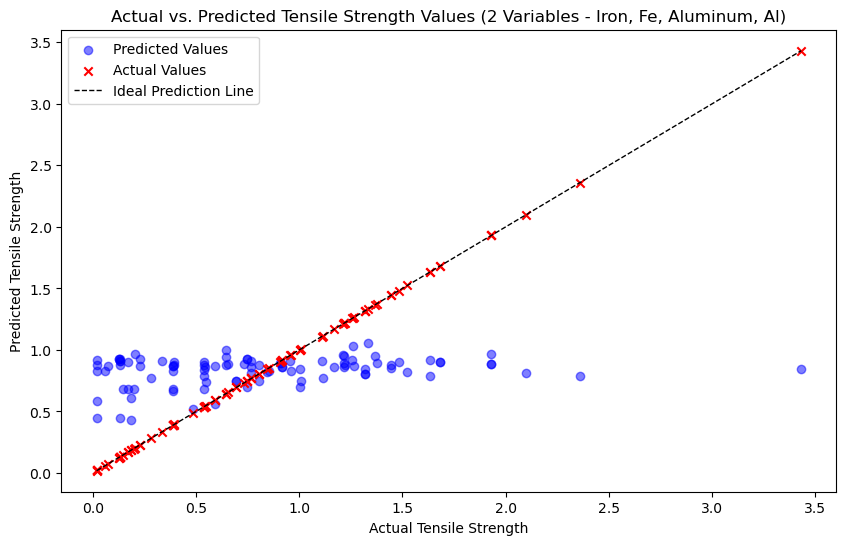

Best combination including Aluminum, Al: ('Iron, Fe', 'Aluminum, Al'), MSE: 0.3689557611942291
Graph and LaTeX file saved with element pair in names: Images/Aluminum/Tensile Strength/Aluminum_Tensile_Strength_2VariableMLP.png and Images/Aluminum/Tensile Strength/Aluminum_Tensile_Strength_2VariableMLP.tex


In [54]:
top_features = ['Silicon, Si', 'Copper, Cu', 'Iron, Fe', 
                'Magnesium, Mg', 'Zinc, Zn', 'Manganese, Mn', 'Bismuth, Bi', 'Titanium, Ti', 
                'Lithium, Li', 'Nickel, Ni', 'Chromium, Cr', 'Zirconium, Zr', 'Vanadium, V', 
                'Tin, Sn', 'Lead, Pb', 'Scandium, Sc', 'Beryllium, Be', 'Gallium, Ga', 
                'Boron, B', 'Silver, Ag']
fixed_feature = 'Aluminum, Al'
file_path = 'Al_model_data/mse_scores_with_aluminum_2_features_tensile.csv'
plotdir = 'Images/Aluminum/Tensile Strength'
process2VariableMLP(metals_and_tensile, top_features, fixed_feature, "Tensile Strength", file_path, plotdir)

Loading existing results...
4/4 [==============================] - 0s 1ms/step


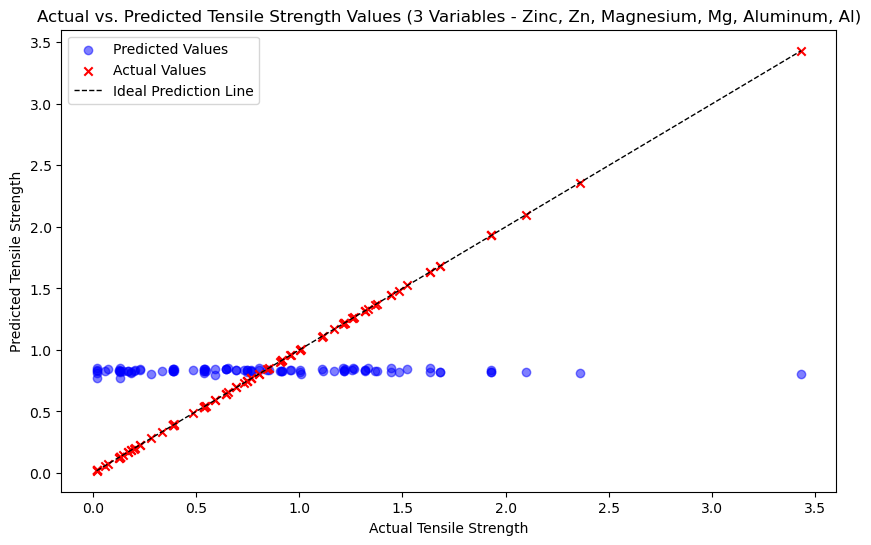

Best combination including Aluminum, Al: ('Zinc, Zn', 'Magnesium, Mg', 'Aluminum, Al'), MSE: 0.2640982270240783
Graph and LaTeX file saved with element pair in names: Images/Aluminum/Tensile Strength/Aluminum_Tensile_Strength_3VariableMLP.png and Images/Aluminum/Tensile Strength/Aluminum_Tensile_Strength_3VariableMLP.tex


In [55]:
top_features = ['Zinc, Zn', 'Magnesium, Mg', 'Copper, Cu', 'Silicon, Si', 'Iron, Fe', 'Manganese, Mn', 'Titanium, Ti', 'Chromium, Cr', 'Nickel, Ni']
fixed_feature = 'Aluminum, Al'
file_path = 'Al_model_data/mse_scores_with_aluminum_3_features_tensile.csv'
plotdir = 'Images/Aluminum/Tensile Strength'
process3VariableMLP(metals_and_tensile, top_features, fixed_feature, "Tensile Strength", file_path, plotdir)

#### Correlation Matrix 

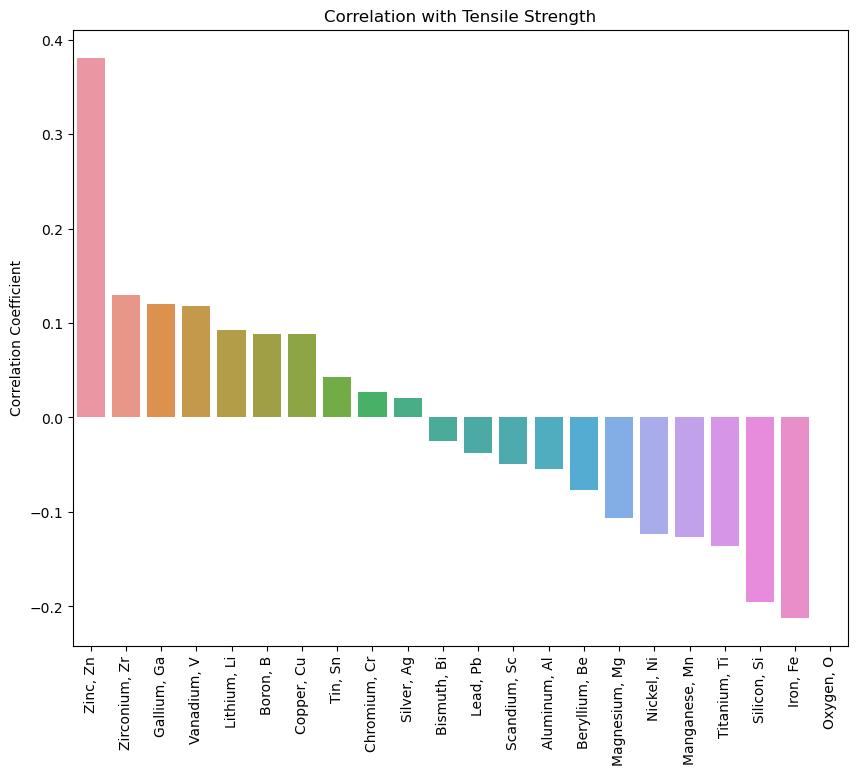

Zinc, Zn         0.380983
Zirconium, Zr    0.129501
Gallium, Ga      0.119724
Vanadium, V      0.117918
Lithium, Li      0.092521
Boron, B         0.088695
Copper, Cu       0.088114
Tin, Sn          0.042394
Chromium, Cr     0.026876
Silver, Ag       0.021027
Bismuth, Bi     -0.024557
Lead, Pb        -0.037454
Scandium, Sc    -0.049184
Aluminum, Al    -0.054796
Beryllium, Be   -0.076822
Magnesium, Mg   -0.106573
Nickel, Ni      -0.123852
Manganese, Mn   -0.126892
Titanium, Ti    -0.135568
Silicon, Si     -0.195835
Iron, Fe        -0.211965
Oxygen, O             NaN
Name: Tensile Strength, dtype: float64

In [56]:
target_feature = "Tensile Strength"
output_dir = "Images/Aluminum/Tensile Strength"
visualize_correlation(metals_and_tensile, target_feature, output_dir)

#### Regression

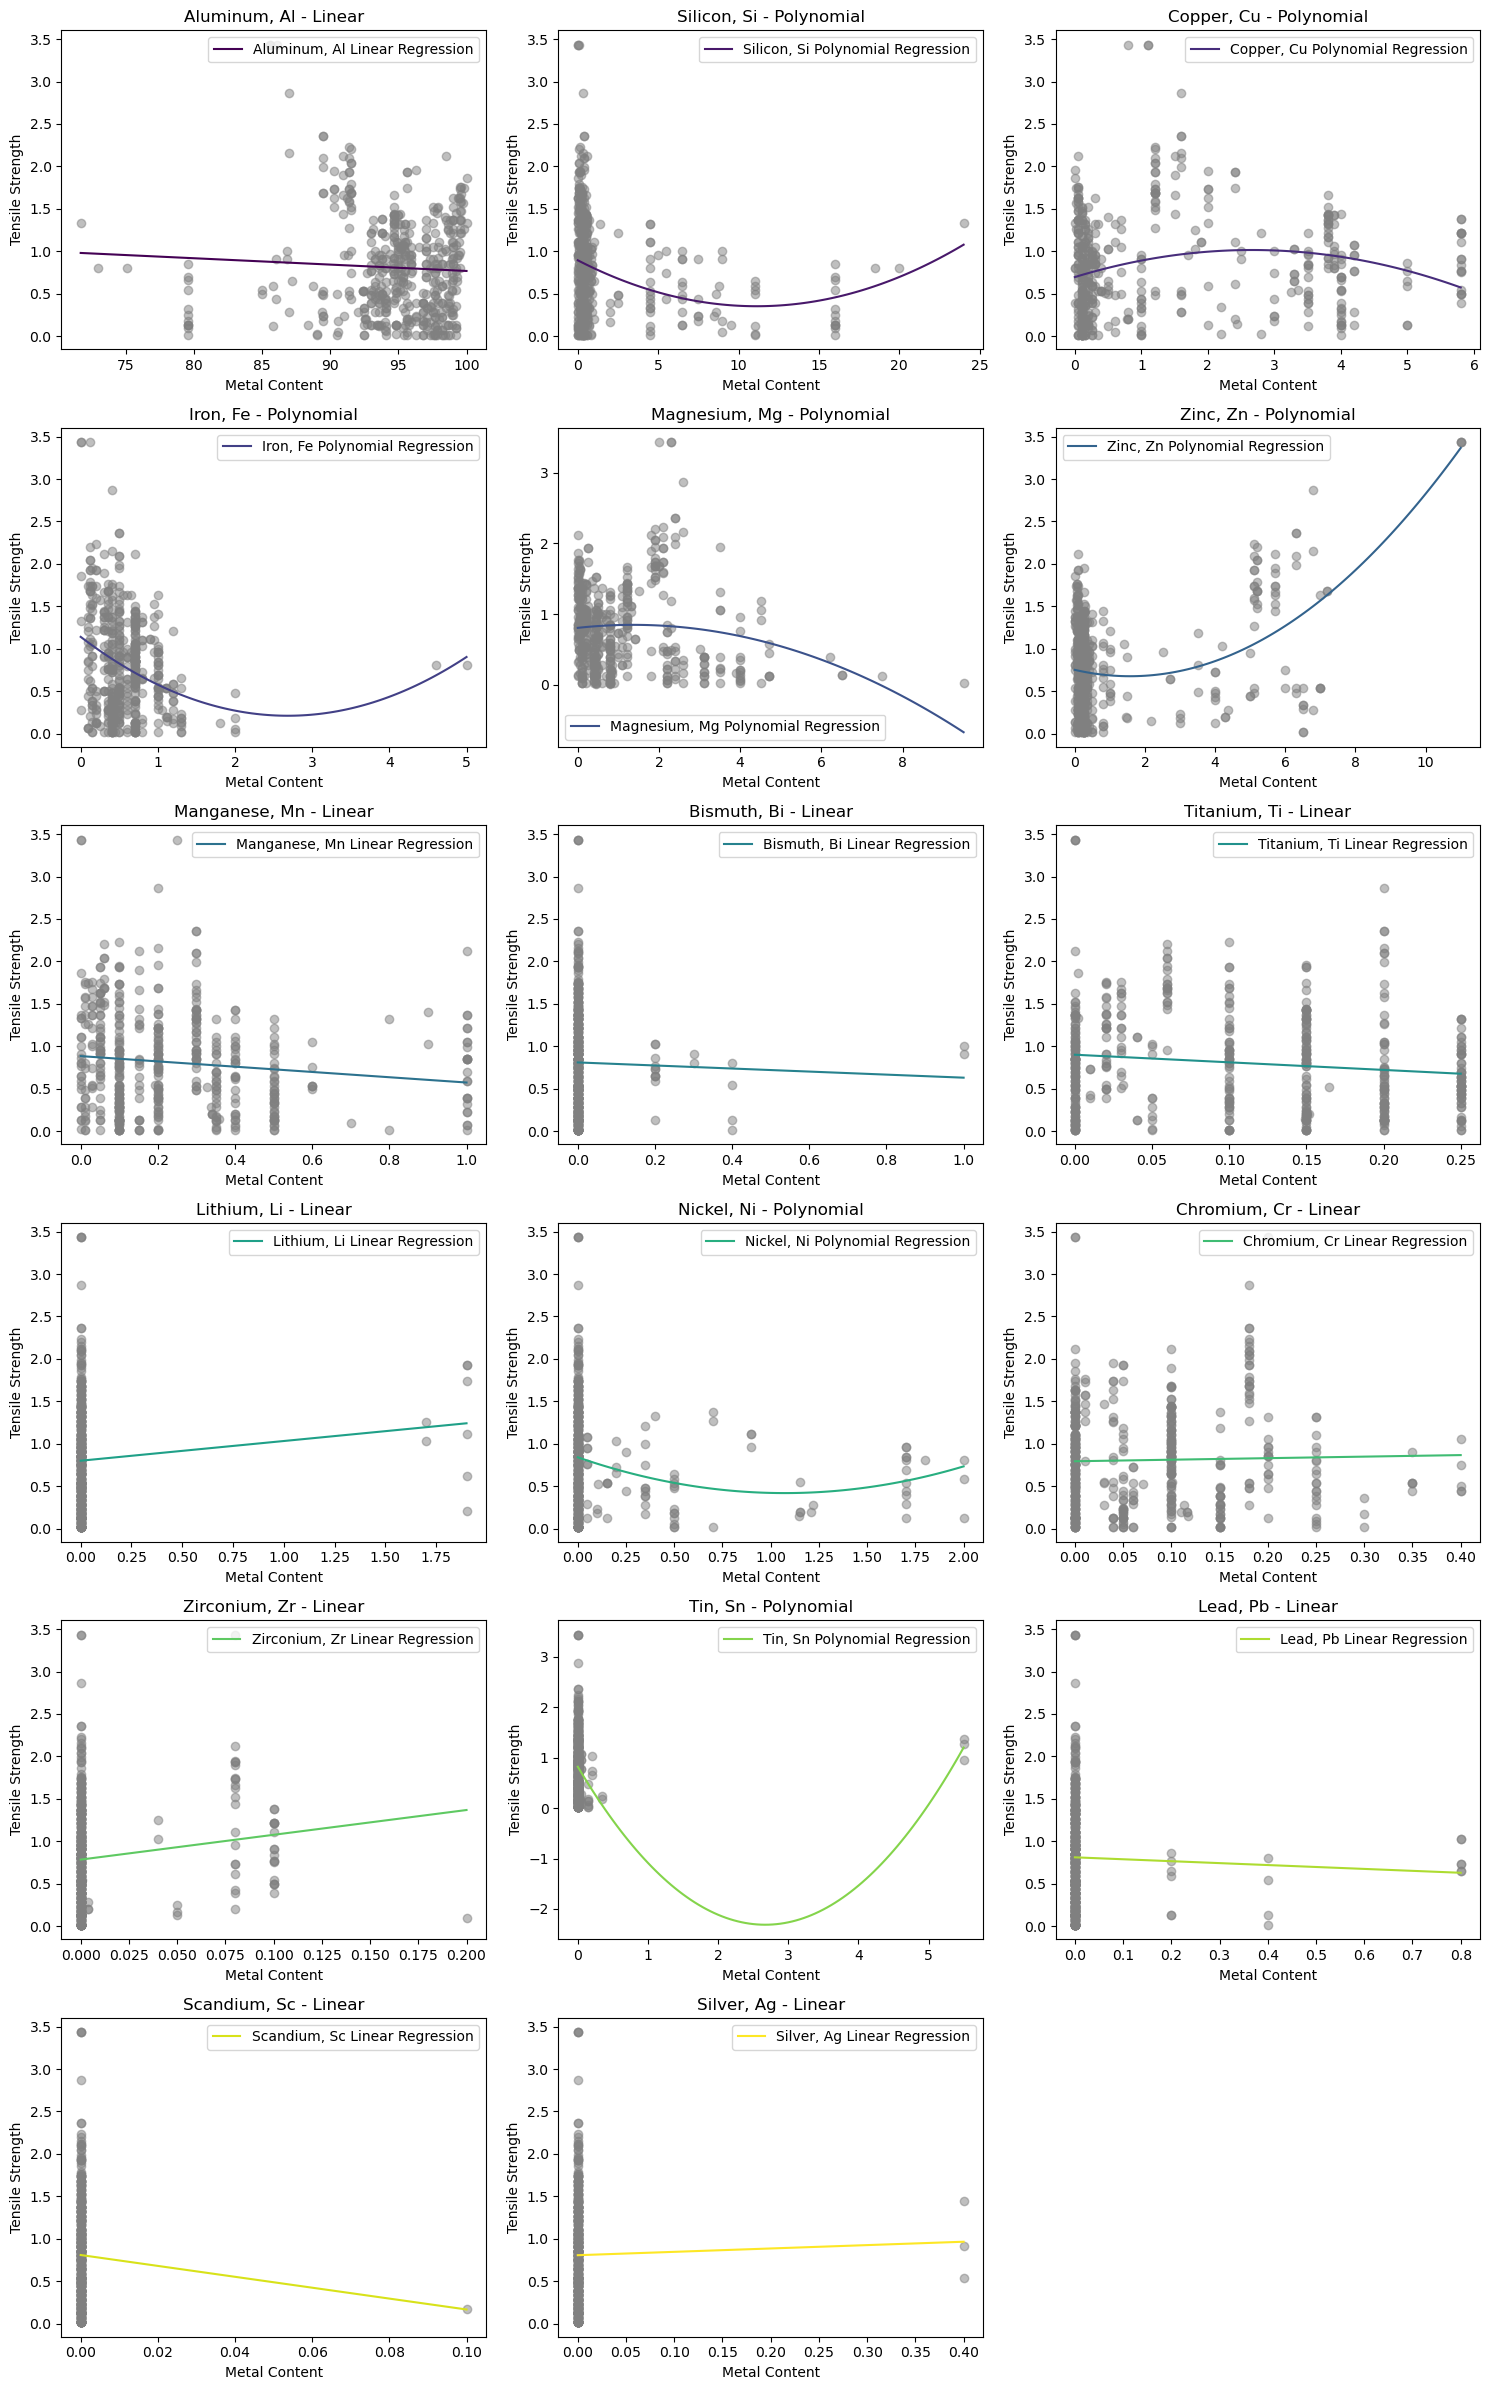

(            Metal  Coefficient     Effect
 0    Aluminum, Al    -0.007497  Decreases
 1     Silicon, Si     0.004372  Increases
 2      Copper, Cu    -0.044877  Decreases
 3        Iron, Fe     0.128991  Increases
 4   Magnesium, Mg    -0.022952  Decreases
 5        Zinc, Zn     0.030245  Increases
 6   Manganese, Mn    -0.311021  Decreases
 7     Bismuth, Bi    -0.179526  Decreases
 8    Titanium, Ti    -0.894891  Decreases
 9     Lithium, Li     0.232031  Increases
 10     Nickel, Ni     0.365976  Increases
 11   Chromium, Cr     0.181477  Increases
 12  Zirconium, Zr     2.919822  Increases
 13        Tin, Sn     0.438678  Increases
 14       Lead, Pb    -0.227472  Decreases
 15   Scandium, Sc    -6.415373  Decreases
 16     Silver, Ag     0.396683  Increases,
 'Images/Aluminum/Tensile Strength/Aluminum_Tensile_Strength_IndividualElementRegression.png')

In [57]:
metals = ['Aluminum, Al', 'Silicon, Si', 'Copper, Cu', 'Iron, Fe', 
          'Magnesium, Mg', 'Zinc, Zn', 'Manganese, Mn', 'Bismuth, Bi', 'Titanium, Ti', 
          'Lithium, Li', 'Nickel, Ni', 'Chromium, Cr', 'Zirconium, Zr', 'Vanadium, V', 
          'Tin, Sn', 'Lead, Pb', 'Scandium, Sc', 'Beryllium, Be', 'Gallium, Ga', 
          'Boron, B', 'Silver, Ag']
target_feature = "Tensile Strength"
plot_dir = "Images/Aluminum/Tensile Strength"
evaluate_and_visualize_impact(metals_and_tensile, metals, target_feature, plot_dir)

In [58]:
## Splitting the DataFrame into positive and negative subsets
#positive_df = impact_summary[impact_summary['Coefficient'] > 0].copy()
#negative_df = impact_summary[impact_summary['Coefficient'] < 0].copy()
#
## Sorting each subset
#positive_df.sort_values(by='Coefficient', ascending=False, inplace=True)
#negative_df.sort_values(by='Coefficient', ascending=False, inplace=True)  # Sort negatives in descending order by value
#
## Concatenating back into a single DataFrame
#sorted_impact_summary = pd.concat([positive_df, negative_df], axis=0)
#
## Define colors based on coefficient sign and set edge colors for better visibility
#colors = ['green' if x > 0 else 'red' for x in sorted_impact_summary['Coefficient']]
#edge_colors = ['darkgreen' if x > 0 else 'darkred' for x in sorted_impact_summary['Coefficient']]
#
## Set up the plot
#plt.figure(figsize=(10, 8))
#bars = plt.barh(sorted_impact_summary['Metal'], sorted_impact_summary['Coefficient'], color=colors, edgecolor=edge_colors)
#plt.xlabel('Coefficient Value')
#plt.title('Impact of Each Metal on Tensile Strength')
#
## Invert y-axis to have the largest impact at the top
#plt.gca().invert_yaxis()
#
## Add text labels to bars for exact coefficient values
#for bar, value in zip(bars, sorted_impact_summary['Coefficient']):
#    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{value:.2f}', va='center', 
#             ha='right' if value < 0 else 'left')
#
## Show the plot
#plt.savefig('Images/Aluminum/Tensile Strength/IndividualElementImpact.png')
#plt.show()
#
#latex_code = r"""
#\begin{figure}[h]
#    \centering
#    \includegraphics[width=0.8\textwidth]{Images/Aluminum/Tensile Strength/IndividualElementImpact.png}
#    \caption{Individual Element Impact of Aluminum based alloys predicting the Tensile Strength}
#    \label{fig:IndividualElementImpact_Al_TS}
#\end{figure}
#"""
#
## Write the LaTeX code to a .tex file
#with open('Images/Aluminum/Tensile Strength/IndividualElementImpact.tex', 'w') as f:
#    f.write(latex_code)
#
## Optionally, print the DataFrame for a tabular view
#print(sorted_impact_summary[['Metal', 'Coefficient', 'Effect']])

### <span style="color:lime">Optimizing Tensile Strength</span>

#### <span style="color:red">Random Forest</span>

In [59]:
selected_features = ['Aluminum, Al', 'Zinc, Zn', 'Magnesium, Mg', 'Copper, Cu', 'Silicon, Si', 'Iron, Fe', 'Manganese, Mn', 'Titanium, Ti', 'Chromium, Cr', 'Nickel, Ni']
target_variable = 'Tensile Strength'
results = analyze_alloy_strength(metals_and_tensile, selected_features, target_variable)
print(results)
model = results['model']

{'mse': 0.19210454130658597, 'rmse': 0.43829732067009713, 'max_youngs_modulus': 3.1535338280664114, 'strongest_composition': Aluminum, Al     85.6
Zinc, Zn         11.0
Magnesium, Mg     2.3
Copper, Cu        1.1
Silicon, Si       0.0
Iron, Fe          0.0
Manganese, Mn     0.0
Titanium, Ti      0.0
Chromium, Cr      0.0
Nickel, Ni        0.0
Name: 384, dtype: float64, 'model': RandomForestRegressor(random_state=42)}


In [60]:
output_path = "Al_model_data/all_hypothetical_combinations_with_predictions_aluminum_tensile.csv"
metals = ['Zinc, Zn', 'Magnesium, Mg', 'Copper, Cu', 'Silicon, Si', 'Iron, Fe', 'Manganese, Mn', 'Titanium, Ti', 'Chromium, Cr', 'Nickel, Ni']
al_increments = np.arange(75, 101, 5)
other_increments = np.arange(0, 26, 5)

top_combinations = generate_and_predict_alloy_strength(model, output_path, metals, al_increments, other_increments, 'Tensile Strength')
print("Top 10 Tensile Strength Combinations:")
print(top_combinations.head(10))  # Print only the top 10

Loaded results from existing file.
Top 10 Tensile Strength Combinations:
      Aluminum, Al  Zinc, Zn  Magnesium, Mg  Copper, Cu  Silicon, Si  \
1228            75        10              5           5            0   
1227            75        10              5           5            0   
1233            75        10              5          10            0   
1240            75        10             10           5            0   
1276            75        15              5           5            0   
1771            80        10              5           5            0   
1231            75        10              5           5            0   
1230            75        10              5           5            0   
1229            75        10              5           5            0   
1232            75        10              5           5            5   

      Iron, Fe  Manganese, Mn  Titanium, Ti  Chromium, Cr  Nickel, Ni  \
1228         0              0             0             5    

#### <span style="color:red">MLP</span>

In [61]:
selected_features = ['Aluminum, Al', 'Zinc, Zn', 'Magnesium, Mg', 'Copper, Cu', 'Silicon, Si', 'Iron, Fe', 'Manganese, Mn', 'Titanium, Ti', 'Chromium, Cr', 'Nickel, Ni']
target_variable = "Tensile Strength"
layer_configurations = [
    (30, 3, 1), (40, 2), (10, 10), (3, 10, 2),
    (10,), (20,), (30,), (40,), (50,),
    (8,), (8, 8), (8, 5, 2),
    (5, 5), (10, 10), (20, 5), (5, 20),
    (15, 6), (6, 6), (6, 6, 2),
    (5,), (5, 10, 2), (10, 10), (5, 10),
    (2,), (2,2), (2,2,2), (2,2,2,2)
]
max_iter_options = [4000]
results_path = 'Al_model_data/grid_search_aluminium_tensile_results.csv'

# Call the grid search function
result = perform_grid_search_nn(metals_and_tensile, selected_features, target_variable, layer_configurations, max_iter_options, results_path)
X_train, X_test, y_train, y_test = result['X_train'], result['X_test'], result['y_train'], result['y_test']
grid_search_results = result['results_df']
print("Grid search results DataFrame:")
print(grid_search_results)

# Sort the results DataFrame by the 'MSE' column in ascending order
sorted_results = grid_search_results.sort_values(by='MSE', ascending=True)

# Print the sorted results
print("Sorted Grid Search Results by MSE:")
print(sorted_results)

Loaded existing results from file.
Grid search results DataFrame:
          Layers  Max_iter       MSE
0     (30, 3, 1)      4000  0.316907
1        (40, 2)      4000  0.281688
2       (10, 10)      4000  0.280162
3     (3, 10, 2)      4000  0.349126
4          (10,)      4000  0.233400
5          (20,)      4000  0.299731
6          (30,)      4000  0.251483
7          (40,)      4000  0.271560
8          (50,)      4000  0.528266
9           (8,)      4000  0.271948
10        (8, 8)      4000  0.286319
11     (8, 5, 2)      4000  0.337799
12        (5, 5)      4000  0.270912
13      (10, 10)      4000  0.280162
14       (20, 5)      4000  0.282112
15       (5, 20)      4000  0.344441
16       (15, 6)      4000  0.328537
17        (6, 6)      4000  0.257600
18     (6, 6, 2)      4000  0.300224
19          (5,)      4000  0.274810
20    (5, 10, 2)      4000  0.304307
21      (10, 10)      4000  0.280162
22       (5, 10)      4000  0.317129
23          (2,)      4000  0.302196
24       

/Users/lukerickard/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Mean Squared Error - Huber Regressor: 0.26741108911580386


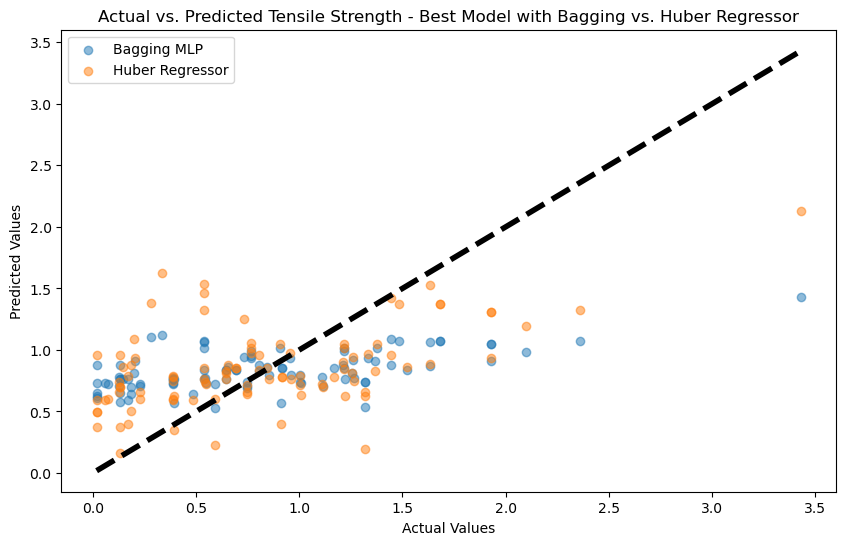

MSE for Huber Regressor: 0.26741108911580386


In [62]:
best_layers = (20, 5)
best_max_iter = 4000
output_dir = 'Images/Aluminum/Tensile Strength'
target_variable = "Tensile Strength"
results = compare_bagging_huber(X_train, y_train, X_test, y_test, best_layers, best_max_iter, output_dir, target_variable)
mse_huber = results['mse_huber']
actual = results['actual']
predbag = results['predbag']
predhuber = results['predhuber']
best_model = results['model']
print("MSE for Huber Regressor:", mse_huber)

Spearman's rank correlation coefficient: 0.5256280598403815
P-value of the correlation coefficient: 2.3171795137559902e-08
Plot saved to Images/Aluminum/Tensile Strength/Aluminum_Tensile_Strength_BaggingMLP.png


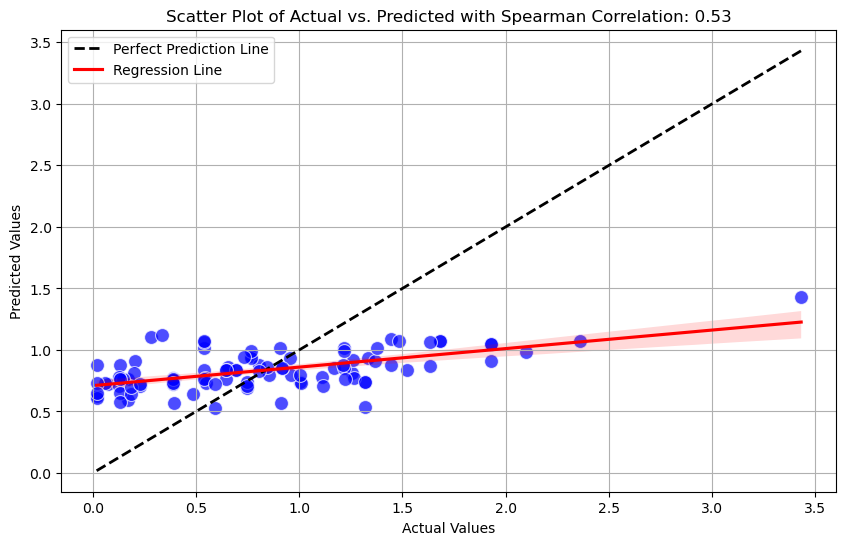

Spearman's rank correlation coefficient: 0.45750930636694687
P-value of the correlation coefficient: 1.927344567588645e-06
Plot saved to Images/Aluminum/Tensile Strength/Aluminum_Tensile_Strength_HuberMLP.png


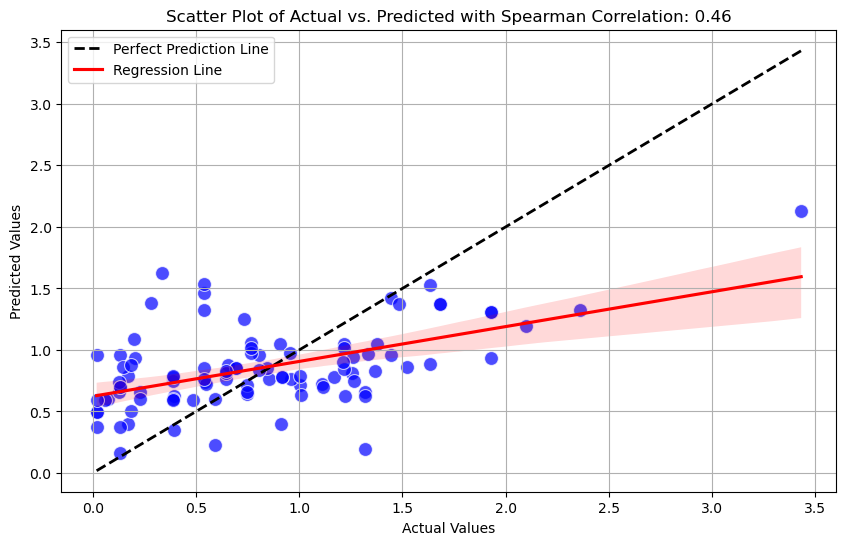

Bagging Model Spearman Correlation: 0.5256280598403815
Huber Model Spearman Correlation: 0.45750930636694687


In [63]:
# Example usage of the generalized function
output_dir = 'Images/Aluminum/Tensile Strength'
actuals = actual  # Example actual values from your test set
preds_bagging = predbag  # Example prediction values from the Bagging model
preds_huber = predhuber  # Example prediction values from the Huber model

# For Bagging MLP
correlation_bagging = show_correlation("Bagging", output_dir, actuals, preds_bagging, "Tensile Strength")

# For Huber MLP
correlation_huber = show_correlation("Huber", output_dir, actuals, preds_huber, "Tensile Strength")

print("Bagging Model Spearman Correlation:", correlation_bagging)
print("Huber Model Spearman Correlation:", correlation_huber)

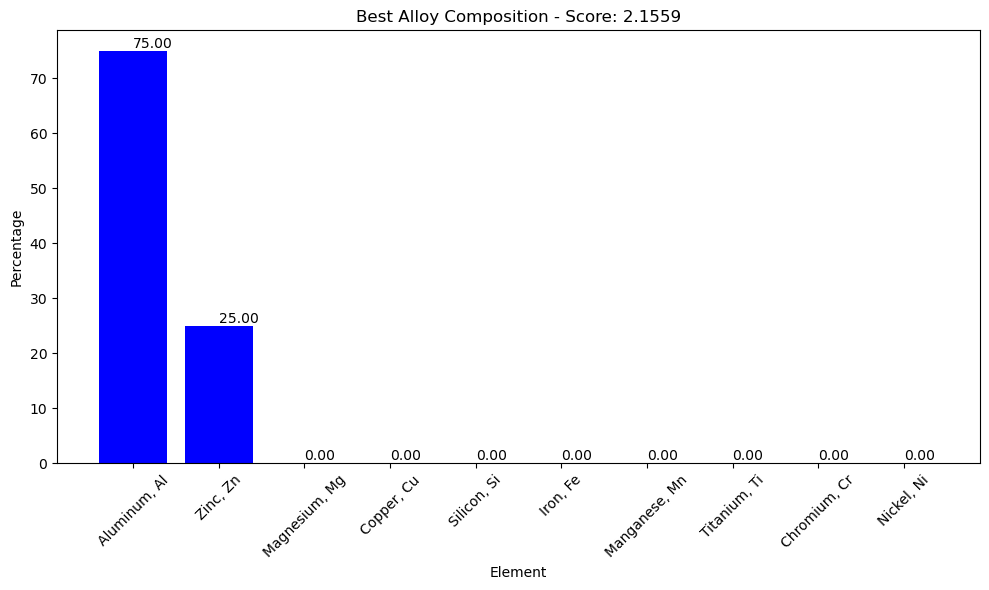

Best Composition: [7.50000000e+01 2.50000000e+01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.95208958e-15 2.79445879e-12 0.00000000e+00
 0.00000000e+00 2.22264816e-12]
Best Score: 2.1559314307506035


In [64]:
output_dir = 'Images/Aluminum/Tensile Strength'
target_property = "Tensile Strength"
best_composition, best_score = optimize_alloy_composition(X_train, output_dir, target_property, metal)
print("Best Composition:", best_composition)
print("Best Score:", best_score)

## Specific Heat

### Data Preperation

In [65]:
# Assuming df1 is your DataFrame and it contains the columns 'Specific Heat' 
df['Specific Heat'] = df['Specific Heat'].apply(extract_numeric)

# List all columns to keep (metal percentages and Specific Heat)
columns_to_keep = ['Specific Heat'] + [col for col in df.columns if ',' in col]

# Create a new dataframe with only these columns
metals_and_heat = df[columns_to_keep]

# Check for missing values in the new dataset
missing_values_metals = metals_and_heat.isnull().sum()
missing_values_metals[missing_values_metals > 0], metals_and_heat.head()

(Series([], dtype: int64),
    Specific Heat  Aluminum, Al  Chromium, Cr  Copper, Cu  Iron, Fe  \
 0       0.984663          91.4          0.18        1.20       0.2   
 1       0.288575          95.9          0.20        0.30       0.7   
 2       0.225294          97.7          0.15        0.04       0.4   
 3       0.647166          97.7          0.15        0.10       0.4   
 4       0.752633          94.7          0.06        0.10       0.4   
 
    Magnesium, Mg  Manganese, Mn  Silicon, Si  Titanium, Ti  Zinc, Zn  ...  \
 0            2.1           0.10         0.15          0.10       5.1  ...   
 1            0.2           0.30         0.60          0.10       0.4  ...   
 2            2.2           0.01         0.00          0.00       0.1  ...   
 3            2.2           0.10         0.25          0.00       0.1  ...   
 4            1.0           0.20         0.35          0.01       4.0  ...   
 
    Nickel, Ni  Gallium, Ga  Oxygen, O  Beryllium, Be  Bismuth, Bi  Lead, P

In [66]:
# Splitting the dataset into features and target variable
X = metals_and_heat.drop('Specific Heat', axis=1)
y = metals_and_heat['Specific Heat']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.head(), y_train.head()

(     Aluminum, Al  Chromium, Cr  Copper, Cu  Iron, Fe  Magnesium, Mg  \
 438          97.0          0.00        0.15      0.80           0.40   
 56           97.0          0.00        0.15      0.80           0.40   
 351          97.3          0.10        0.40      0.50           0.70   
 222          97.8          0.04        0.15      0.70           0.80   
 362          99.6          0.00        0.05      0.35           0.03   
 
      Manganese, Mn  Silicon, Si  Titanium, Ti  Zinc, Zn  Zirconium, Zr  ...  \
 438           0.10         0.20          0.00      0.20            0.0  ...   
 56            0.10         0.20          0.00      0.20            0.0  ...   
 351           0.05         0.80          0.15      0.50            0.0  ...   
 222           0.15         0.40          0.15      0.25            0.0  ...   
 362           0.03         0.25          0.03      0.05            0.0  ...   
 
      Nickel, Ni  Gallium, Ga  Oxygen, O  Beryllium, Be  Bismuth, Bi  Lead, Pb

### Feature Selection

#### Random Forest Feature Importance

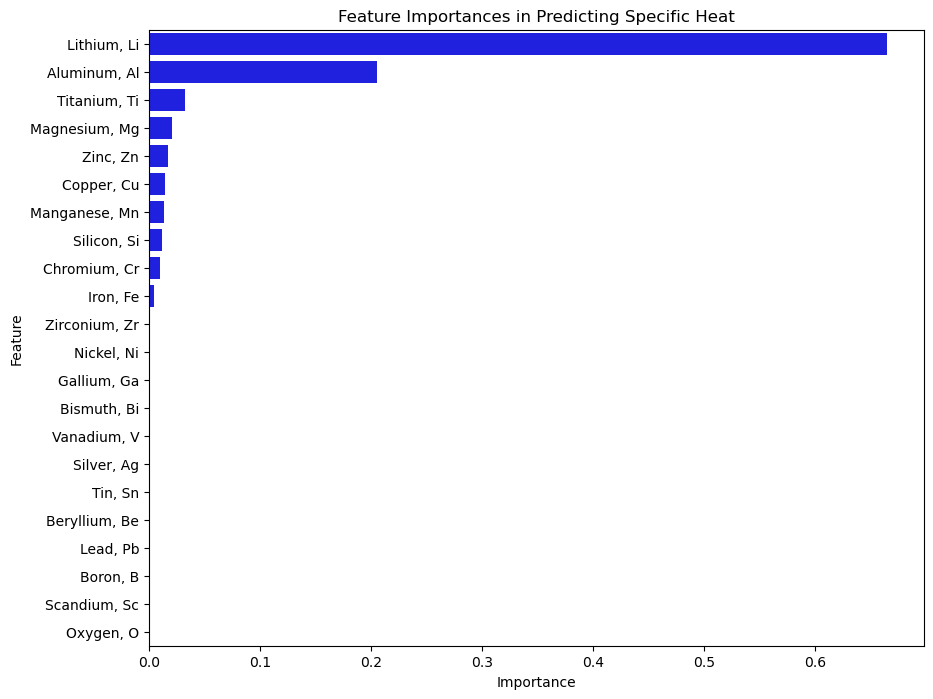

(0.05692902393415025,
           Feature  Importance
 20    Lithium, Li    0.664580
 0    Aluminum, Al    0.205471
 7    Titanium, Ti    0.032398
 4   Magnesium, Mg    0.020640
 8        Zinc, Zn    0.016933
 2      Copper, Cu    0.014095
 5   Manganese, Mn    0.013672
 6     Silicon, Si    0.011775
 1    Chromium, Cr    0.010267
 3        Iron, Fe    0.004915
 9   Zirconium, Zr    0.001001
 12     Nickel, Ni    0.000886
 13    Gallium, Ga    0.000663
 16    Bismuth, Bi    0.000645
 10    Vanadium, V    0.000620
 21     Silver, Ag    0.000593
 18        Tin, Sn    0.000404
 15  Beryllium, Be    0.000238
 17       Lead, Pb    0.000114
 11       Boron, B    0.000091
 19   Scandium, Sc    0.000000
 14      Oxygen, O    0.000000)

In [67]:
output_dir = "Images/Aluminum/Specific Heat"
train_and_evaluate_simple_rf(X_train, y_train, X_test, y_test, output_dir, "Specific Heat")

#### Combination Neural Network Feature Combination Importance

Loading existing results...
4/4 [==============================] - 0s 1ms/step


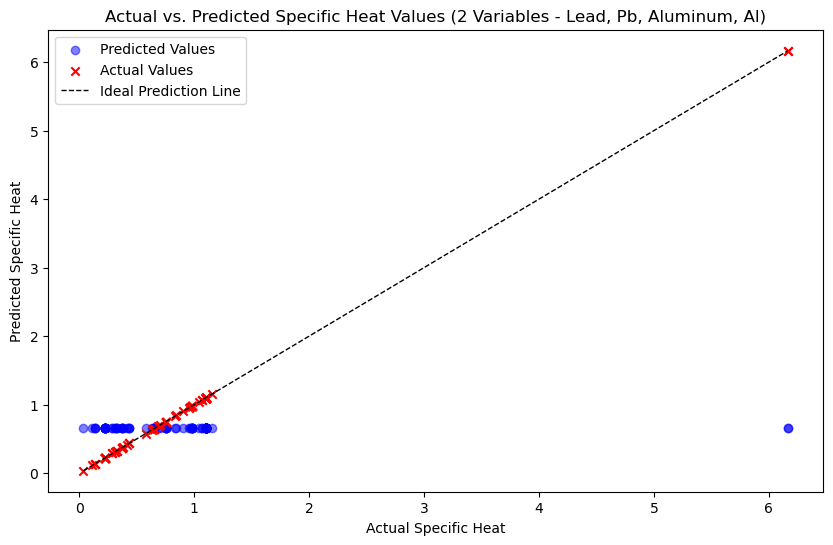

Best combination including Aluminum, Al: ('Lead, Pb', 'Aluminum, Al'), MSE: 0.719780683517456
Graph and LaTeX file saved with element pair in names: Images/Aluminum/Specific Heat/Aluminum_Specific_Heat_2VariableMLP.png and Images/Aluminum/Specific Heat/Aluminum_Specific_Heat_2VariableMLP.tex


In [68]:
top_features = ['Silicon, Si', 'Copper, Cu', 'Iron, Fe', 
                'Magnesium, Mg', 'Zinc, Zn', 'Manganese, Mn', 'Bismuth, Bi', 'Titanium, Ti', 
                'Lithium, Li', 'Nickel, Ni', 'Chromium, Cr', 'Zirconium, Zr', 'Vanadium, V', 
                'Tin, Sn', 'Lead, Pb', 'Scandium, Sc', 'Beryllium, Be', 'Gallium, Ga', 
                'Boron, B', 'Silver, Ag']
fixed_feature = 'Aluminum, Al'
file_path = 'Al_model_data/mse_scores_with_aluminum_2_features_heat.csv'
plotdir = 'Images/Aluminum/Specific Heat'
process2VariableMLP(metals_and_heat, top_features, fixed_feature, "Specific Heat", file_path, plotdir)

Loading existing results...
4/4 [==============================] - 0s 1ms/step


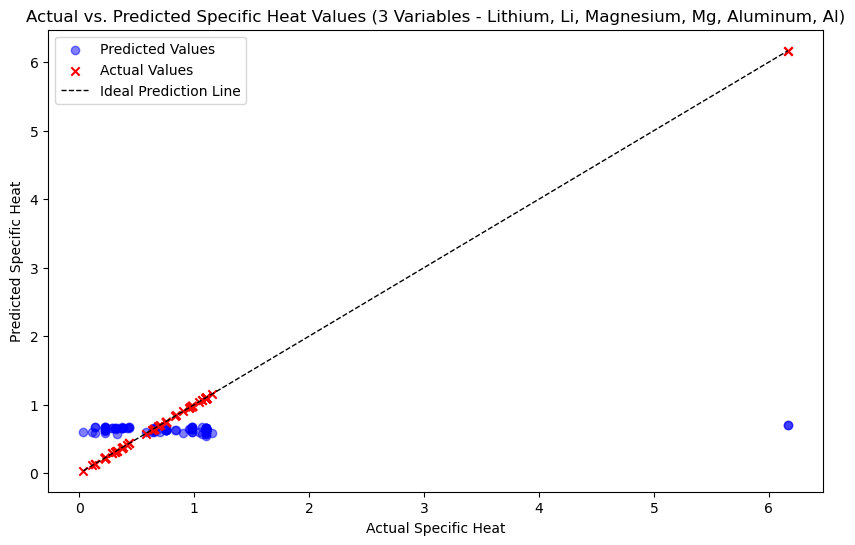

Best combination including Aluminum, Al: ('Lithium, Li', 'Magnesium, Mg', 'Aluminum, Al'), MSE: 0.3449238538742065
Graph and LaTeX file saved with element pair in names: Images/Aluminum/Specific Heat/Aluminum_Specific_Heat_3VariableMLP.png and Images/Aluminum/Specific Heat/Aluminum_Specific_Heat_3VariableMLP.tex


In [69]:
top_features = ['Lithium, Li', 'Titanium, Ti', 'Magnesium, Mg', 'Zinc, Zn', 'Copper, Cu', 'Manganese, Mn', 'Silicon, Si', 'Chromium, Cr', 'Iron, Fe']
fixed_feature = 'Aluminum, Al'
file_path = 'Al_model_data/mse_scores_with_aluminum_3_features_heat.csv'
plotdir = 'Images/Aluminum/Specific Heat'
process3VariableMLP(metals_and_heat, top_features, fixed_feature, "Specific Heat", file_path, plotdir)

#### Correlation Matrix 

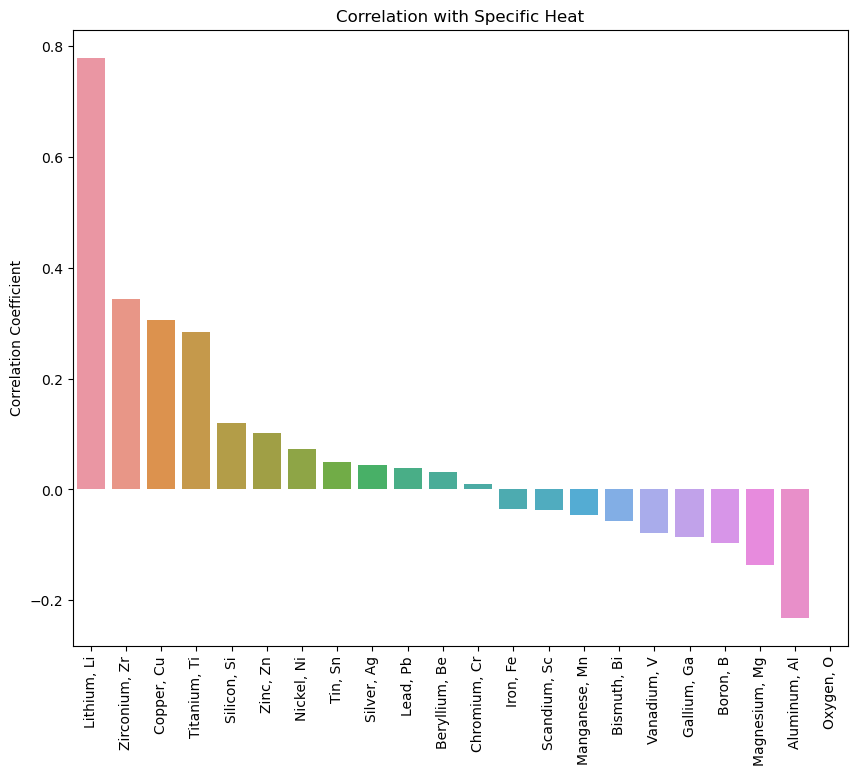

Lithium, Li      0.779377
Zirconium, Zr    0.344078
Copper, Cu       0.306411
Titanium, Ti     0.284078
Silicon, Si      0.120038
Zinc, Zn         0.101418
Nickel, Ni       0.072874
Tin, Sn          0.050210
Silver, Ag       0.043714
Lead, Pb         0.037716
Beryllium, Be    0.031218
Chromium, Cr     0.010323
Iron, Fe        -0.035921
Scandium, Sc    -0.038090
Manganese, Mn   -0.046461
Bismuth, Bi     -0.057573
Vanadium, V     -0.079629
Gallium, Ga     -0.086141
Boron, B        -0.096320
Magnesium, Mg   -0.136814
Aluminum, Al    -0.231583
Oxygen, O             NaN
Name: Specific Heat, dtype: float64

In [70]:
target_feature = "Specific Heat"
output_dir = "Images/Aluminum/Specific Heat"
visualize_correlation(metals_and_heat, target_feature, output_dir)

#### Regression

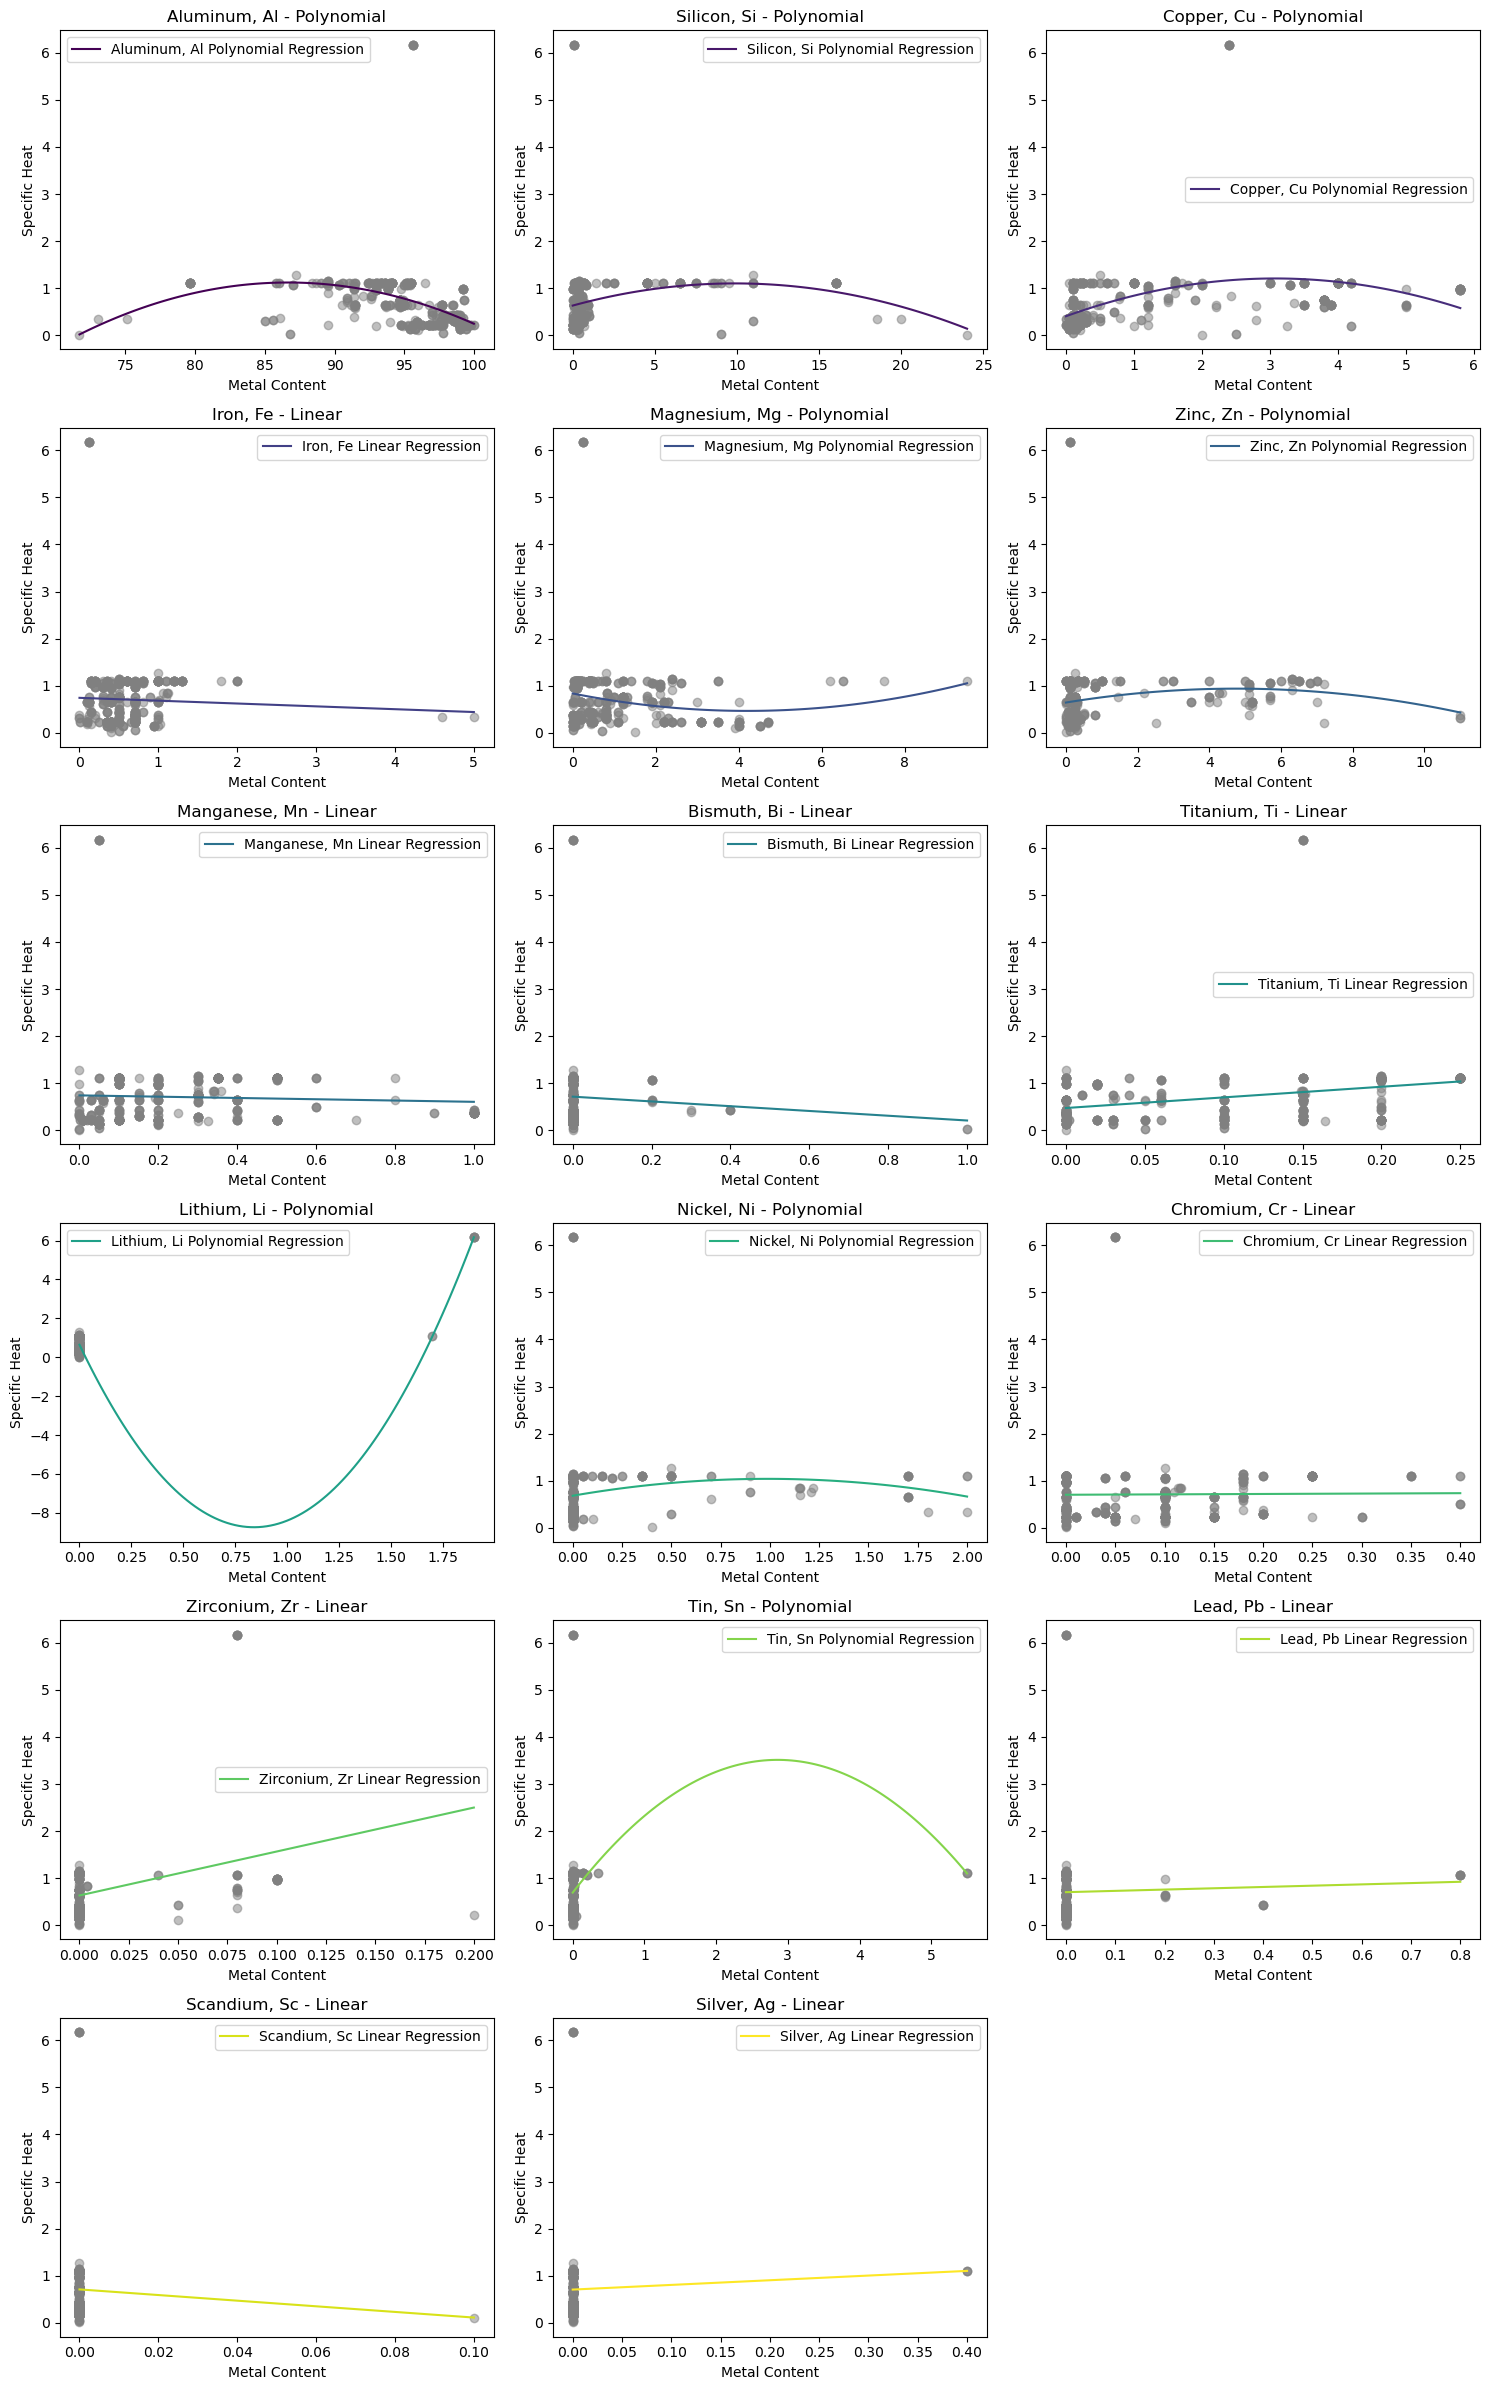

(            Metal  Coefficient     Effect
 0    Aluminum, Al    -0.004923  Decreases
 1     Silicon, Si    -0.004819  Decreases
 2      Copper, Cu    -0.084695  Decreases
 3        Iron, Fe    -0.060273  Decreases
 4   Magnesium, Mg     0.020912  Increases
 5        Zinc, Zn    -0.013015  Decreases
 6   Manganese, Mn    -0.136886  Decreases
 7     Bismuth, Bi    -0.505915  Decreases
 8    Titanium, Ti     2.254063  Increases
 9     Lithium, Li    13.280588  Increases
 10     Nickel, Ni    -0.366865  Decreases
 11   Chromium, Cr     0.083789  Increases
 12  Zirconium, Zr     9.325151  Increases
 13        Tin, Sn    -0.345014  Decreases
 14       Lead, Pb     0.275347  Increases
 15   Scandium, Sc    -5.972061  Decreases
 16     Silver, Ag     0.991285  Increases,
 'Images/Aluminum/Specific Heat/Aluminum_Specific_Heat_IndividualElementRegression.png')

In [71]:
metals = ['Aluminum, Al', 'Silicon, Si', 'Copper, Cu', 'Iron, Fe', 
          'Magnesium, Mg', 'Zinc, Zn', 'Manganese, Mn', 'Bismuth, Bi', 'Titanium, Ti', 
          'Lithium, Li', 'Nickel, Ni', 'Chromium, Cr', 'Zirconium, Zr', 'Vanadium, V', 
          'Tin, Sn', 'Lead, Pb', 'Scandium, Sc', 'Beryllium, Be', 'Gallium, Ga', 
          'Boron, B', 'Silver, Ag']
target_feature = "Specific Heat"
plot_dir = "Images/Aluminum/Specific Heat"
evaluate_and_visualize_impact(metals_and_heat, metals, target_feature, plot_dir)

In [72]:
## Splitting the DataFrame into positive and negative subsets
#positive_df = impact_summary[impact_summary['Coefficient'] > 0].copy()
#negative_df = impact_summary[impact_summary['Coefficient'] < 0].copy()
#
## Sorting each subset
#positive_df.sort_values(by='Coefficient', ascending=False, inplace=True)
#negative_df.sort_values(by='Coefficient', ascending=False, inplace=True)  # Sort negatives in descending order by value
#
## Concatenating back into a single DataFrame
#sorted_impact_summary = pd.concat([positive_df, negative_df], axis=0)
#
## Define colors based on coefficient sign and set edge colors for better visibility
#colors = ['green' if x > 0 else 'red' for x in sorted_impact_summary['Coefficient']]
#edge_colors = ['darkgreen' if x > 0 else 'darkred' for x in sorted_impact_summary['Coefficient']]
#
## Set up the plot
#plt.figure(figsize=(10, 8))
#bars = plt.barh(sorted_impact_summary['Metal'], sorted_impact_summary['Coefficient'], color=colors, edgecolor=edge_colors)
#plt.xlabel('Coefficient Value')
#plt.title('Impact of Each Metal on Specific Heat')
#
## Invert y-axis to have the largest impact at the top
#plt.gca().invert_yaxis()
#
## Add text labels to bars for exact coefficient values
#for bar, value in zip(bars, sorted_impact_summary['Coefficient']):
#    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{value:.2f}', va='center', 
#             ha='right' if value < 0 else 'left')
#
#plt.savefig('Images/Aluminum/Specific Heat/IndividualElementImpact.png')
#plt.show()
#
#latex_code = r"""
#\begin{figure}[h]
#    \centering
#    \includegraphics[width=0.8\textwidth]{Images/Aluminum/Specific Heat/IndividualElementImpact.png}
#    \caption{Individual Element Impact of Aluminum based alloys predicting the Specific Heat}
#    \label{fig:IndividualElementImpact_Al_SH}
#\end{figure}
#"""
#
## Write the LaTeX code to a .tex file
#with open('Images/Aluminum/Specific Heat/IndividualElementImpact.tex', 'w') as f:
#    f.write(latex_code)
#
## Optionally, print the DataFrame for a tabular view
#print(sorted_impact_summary[['Metal', 'Coefficient', 'Effect']])

### <span style="color:lime">Optmizing Specific Heat</span>

#### <span style="color:red">Random Forest</span>

In [73]:
selected_features = ['Aluminum, Al', 'Lithium, Li', 'Titanium, Ti', 'Magnesium, Mg', 'Zinc, Zn', 'Copper, Cu', 'Manganese, Mn', 'Silicon, Si', 'Chromium, Cr', 'Iron, Fe']
target_variable = 'Specific Heat'
results = analyze_alloy_strength(metals_and_heat, selected_features, target_variable)
print(results)
model = results['model']

{'mse': 0.04757331574334538, 'rmse': 0.21811308017481523, 'max_youngs_modulus': 6.109393498923785, 'strongest_composition': Aluminum, Al     95.60
Lithium, Li       1.90
Titanium, Ti      0.15
Magnesium, Mg     0.25
Zinc, Zn          0.10
Copper, Cu        2.40
Manganese, Mn     0.05
Silicon, Si       0.10
Chromium, Cr      0.05
Iron, Fe          0.12
Name: 449, dtype: float64, 'model': RandomForestRegressor(random_state=42)}


In [74]:
output_path = "Al_model_data/all_hypothetical_combinations_with_predictions_aluminum_heat.csv"
metals = ['Lithium, Li', 'Titanium, Ti', 'Magnesium, Mg', 'Zinc, Zn', 'Copper, Cu', 'Manganese, Mn', 'Silicon, Si', 'Chromium, Cr', 'Iron, Fe']
al_increments = np.arange(75, 101, 5)
other_increments = np.arange(0, 26, 5)

top_combinations = generate_and_predict_alloy_strength(model, output_path, metals, al_increments, other_increments, 'Specific Heat')
print("Top 10 Yield Strength Combinations:")
print(top_combinations.head(10))  # Print only the top 10

Loaded results from existing file.
Top 10 Yield Strength Combinations:
      Aluminum, Al  Lithium, Li  Titanium, Ti  Magnesium, Mg  Zinc, Zn  \
1002            75            5             5              0         0   
1003            75            5             5              0         0   
1004            75            5             5              0         0   
1005            75            5             5              0         0   
1006            75            5             5              0         0   
1007            75            5             5              0         0   
1008            75            5             5              0         0   
1009            75            5             5              0         0   
1010            75            5             5              0         0   
1011            75            5             5              0         0   

      Copper, Cu  Manganese, Mn  Silicon, Si  Chromium, Cr  Iron, Fe  \
1002           0              0           

#### <span style="color:red">MLP</span>

In [75]:
selected_features = ['Aluminum, Al', 'Lithium, Li', 'Titanium, Ti', 'Magnesium, Mg', 'Zinc, Zn', 'Copper, Cu', 'Manganese, Mn', 'Silicon, Si', 'Chromium, Cr', 'Iron, Fe']
target_variable = 'Specific Heat'
layer_configurations = [
    (30, 3, 1), (40, 2), (10, 10), (3, 10, 2),
    (10,), (20,), (30,), (40,), (50,),
    (8,), (8, 8), (8, 5, 2),
    (5, 5), (10, 10), (20, 5), (5, 20),
    (15, 6), (6, 6), (6, 6, 2),
    (5,), (5, 10, 2), (10, 10), (5, 10),
    (2,), (2,2), (2,2,2), (2,2,2,2)
]
max_iter_options = [4000]
results_path = 'Al_model_data/grid_search_aluminium_heat_results.csv'

# Call the grid search function
result = perform_grid_search_nn(metals_and_heat, selected_features, target_variable, layer_configurations, max_iter_options, results_path)
X_train, X_test, y_train, y_test = result['X_train'], result['X_test'], result['y_train'], result['y_test']
grid_search_results = result['results_df']
print("Grid search results DataFrame:")
print(grid_search_results)

# Sort the results DataFrame by the 'MSE' column in ascending order
sorted_results = grid_search_results.sort_values(by='MSE', ascending=True)

# Print the sorted results
print("Sorted Grid Search Results by MSE:")
print(sorted_results)

Loaded existing results from file.
Grid search results DataFrame:
          Layers  Max_iter       MSE
0     (30, 3, 1)      4000  0.727124
1        (40, 2)      4000  0.513412
2       (10, 10)      4000  0.336834
3     (3, 10, 2)      4000  0.630714
4          (10,)      4000  0.240582
5          (20,)      4000  0.310346
6          (30,)      4000  0.552638
7          (40,)      4000  0.432946
8          (50,)      4000  0.490202
9           (8,)      4000  0.250686
10        (8, 8)      4000  0.331920
11     (8, 5, 2)      4000  0.573128
12        (5, 5)      4000  0.351791
13      (10, 10)      4000  0.336834
14       (20, 5)      4000  0.278487
15       (5, 20)      4000  0.536640
16       (15, 6)      4000  0.329008
17        (6, 6)      4000  0.256982
18     (6, 6, 2)      4000  0.537473
19          (5,)      4000  0.337395
20    (5, 10, 2)      4000  0.523220
21      (10, 10)      4000  0.336834
22       (5, 10)      4000  0.468477
23          (2,)      4000  0.674146
24       

/Users/lukerickard/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Mean Squared Error - Huber Regressor: 0.2727431750440049


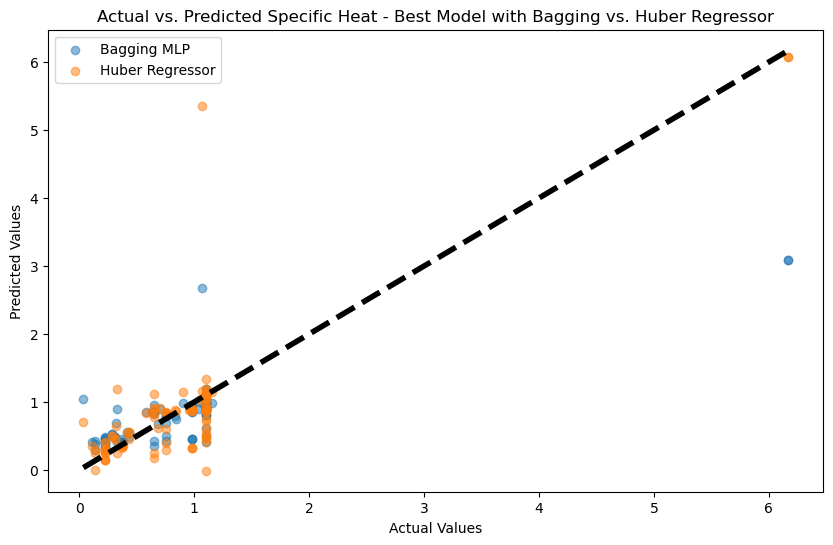

MSE for Huber Regressor: 0.2727431750440049


In [76]:
best_layers = (20, 5)
best_max_iter = 4000
output_dir = 'Images/Aluminum/Specific Heat'
target_variable = "Specific Heat"
results = compare_bagging_huber(X_train, y_train, X_test, y_test, best_layers, best_max_iter, output_dir, target_variable)
mse_huber = results['mse_huber']
actual = results['actual']
predbag = results['predbag']
predhuber = results['predhuber']
best_model = results['model']
print("MSE for Huber Regressor:", mse_huber)

Spearman's rank correlation coefficient: 0.722799369842067
P-value of the correlation coefficient: 3.001900535617297e-17
Plot saved to Images/Aluminum/Specific Heat/Aluminum_Specific_Heat_BaggingMLP.png


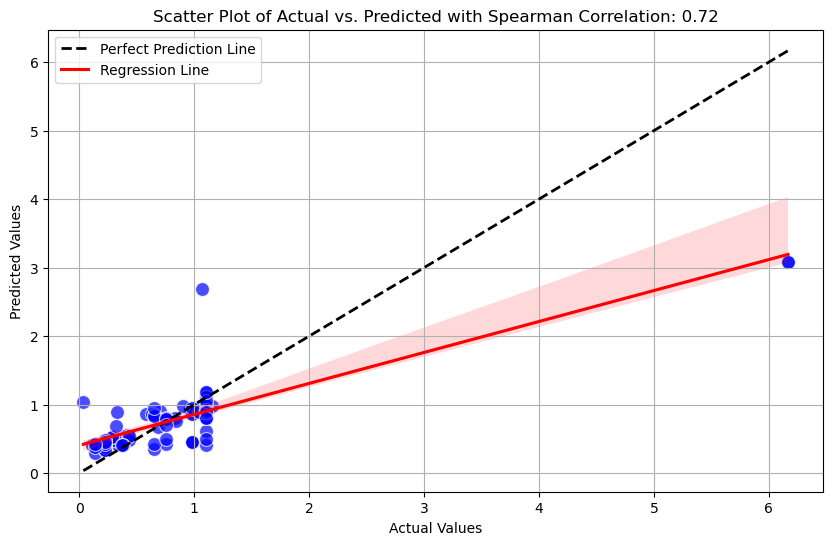

Spearman's rank correlation coefficient: 0.6592738030165306
P-value of the correlation coefficient: 1.1763301577040713e-13
Plot saved to Images/Aluminum/Specific Heat/Aluminum_Specific_Heat_HuberMLP.png


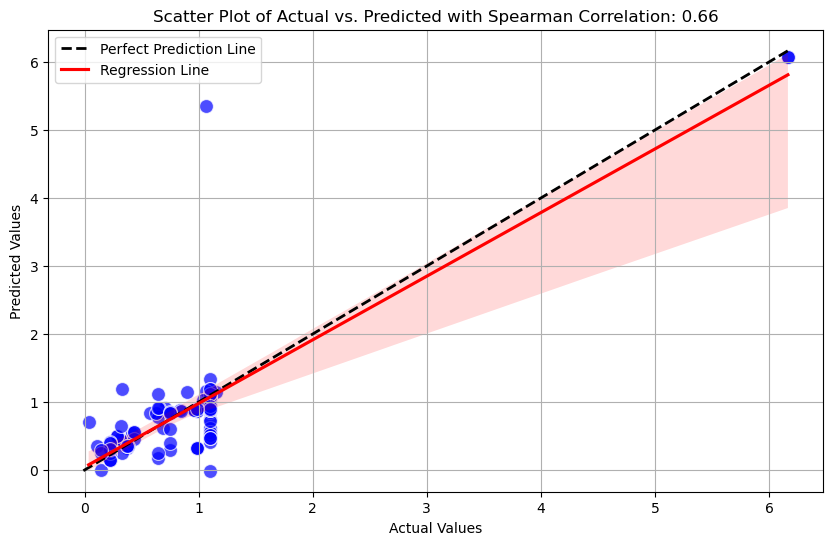

Bagging Model Spearman Correlation: 0.722799369842067
Huber Model Spearman Correlation: 0.6592738030165306


In [77]:
# Example usage of the generalized function
output_dir = 'Images/Aluminum/Specific Heat'
actuals = actual  # Example actual values from your test set
preds_bagging = predbag  # Example prediction values from the Bagging model
preds_huber = predhuber  # Example prediction values from the Huber model

# For Bagging MLP
correlation_bagging = show_correlation("Bagging", output_dir, actuals, preds_bagging, "Specific Heat")

# For Huber MLP
correlation_huber = show_correlation("Huber", output_dir, actuals, preds_huber, "Specific Heat")

print("Bagging Model Spearman Correlation:", correlation_bagging)
print("Huber Model Spearman Correlation:", correlation_huber)

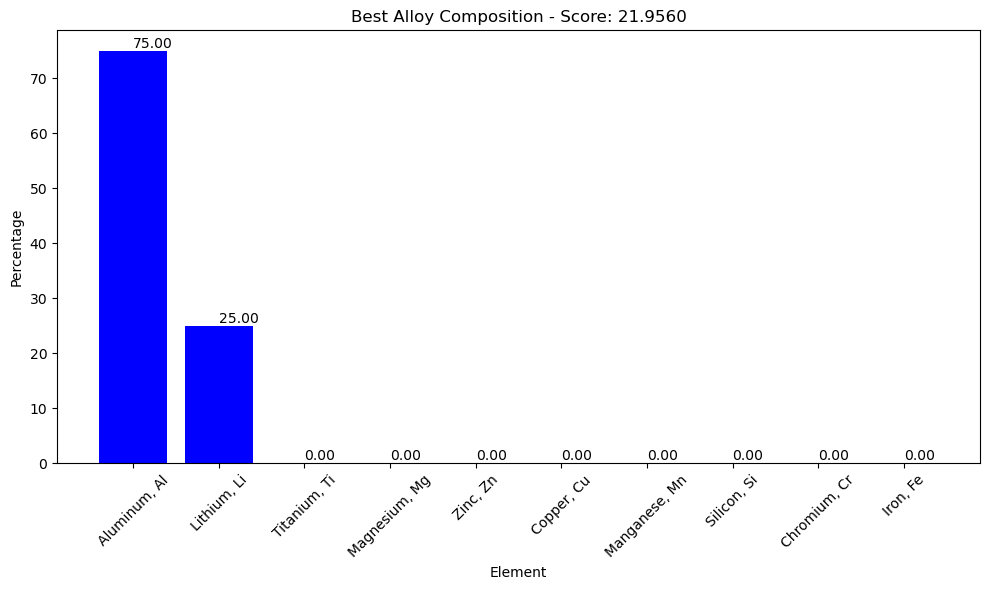

Best Composition: [7.50000000e+01 2.50000000e+01 0.00000000e+00 0.00000000e+00
 1.57211097e-15 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
Best Score: 21.955959430636362


In [78]:
output_dir = 'Images/Aluminum/Specific Heat'
target_property = "Specific Heat"
best_composition, best_score = optimize_alloy_composition(X_train, output_dir, target_property, metal)
print("Best Composition:", best_composition)
print("Best Score:", best_score)

## Coefficient of Thermal Expansion

### Data Preperation

In [79]:
# Assuming df1 is your DataFrame and it contains the columns 'Coefficient of Thermal Expansion''
df['Coefficient of Thermal Expansion'] = df['Coefficient of Thermal Expansion'].apply(extract_numeric)

# List all columns to keep (metal percentages and Coefficient of Thermal Expansion)
columns_to_keep = ['Coefficient of Thermal Expansion'] + [col for col in df.columns if ',' in col]

# Create a new dataframe with only these columns
metals_and_thermalE = df[columns_to_keep]

# Check for missing values in the new dataset
missing_values_metals = metals_and_thermalE.isnull().sum()
missing_values_metals[missing_values_metals > 0], metals_and_thermalE.head()

(Series([], dtype: int64),
    Coefficient of Thermal Expansion  Aluminum, Al  Chromium, Cr  Copper, Cu  \
 0                          0.304406          91.4          0.18        1.20   
 1                          0.448191          95.9          0.20        0.30   
 2                          0.591976          97.7          0.15        0.04   
 3                          0.591976          97.7          0.15        0.10   
 4                          0.448191          94.7          0.06        0.10   
 
    Iron, Fe  Magnesium, Mg  Manganese, Mn  Silicon, Si  Titanium, Ti  \
 0       0.2            2.1           0.10         0.15          0.10   
 1       0.7            0.2           0.30         0.60          0.10   
 2       0.4            2.2           0.01         0.00          0.00   
 3       0.4            2.2           0.10         0.25          0.00   
 4       0.4            1.0           0.20         0.35          0.01   
 
    Zinc, Zn  ...  Nickel, Ni  Gallium, Ga  Oxygen,

In [80]:
# Splitting the dataset into features and target variable
X = metals_and_thermalE.drop('Coefficient of Thermal Expansion', axis=1)
y = metals_and_thermalE['Coefficient of Thermal Expansion']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.head(), y_train.head()

(     Aluminum, Al  Chromium, Cr  Copper, Cu  Iron, Fe  Magnesium, Mg  \
 438          97.0          0.00        0.15      0.80           0.40   
 56           97.0          0.00        0.15      0.80           0.40   
 351          97.3          0.10        0.40      0.50           0.70   
 222          97.8          0.04        0.15      0.70           0.80   
 362          99.6          0.00        0.05      0.35           0.03   
 
      Manganese, Mn  Silicon, Si  Titanium, Ti  Zinc, Zn  Zirconium, Zr  ...  \
 438           0.10         0.20          0.00      0.20            0.0  ...   
 56            0.10         0.20          0.00      0.20            0.0  ...   
 351           0.05         0.80          0.15      0.50            0.0  ...   
 222           0.15         0.40          0.15      0.25            0.0  ...   
 362           0.03         0.25          0.03      0.05            0.0  ...   
 
      Nickel, Ni  Gallium, Ga  Oxygen, O  Beryllium, Be  Bismuth, Bi  Lead, Pb

### Feature Selection

#### Random Forest Feature Importance

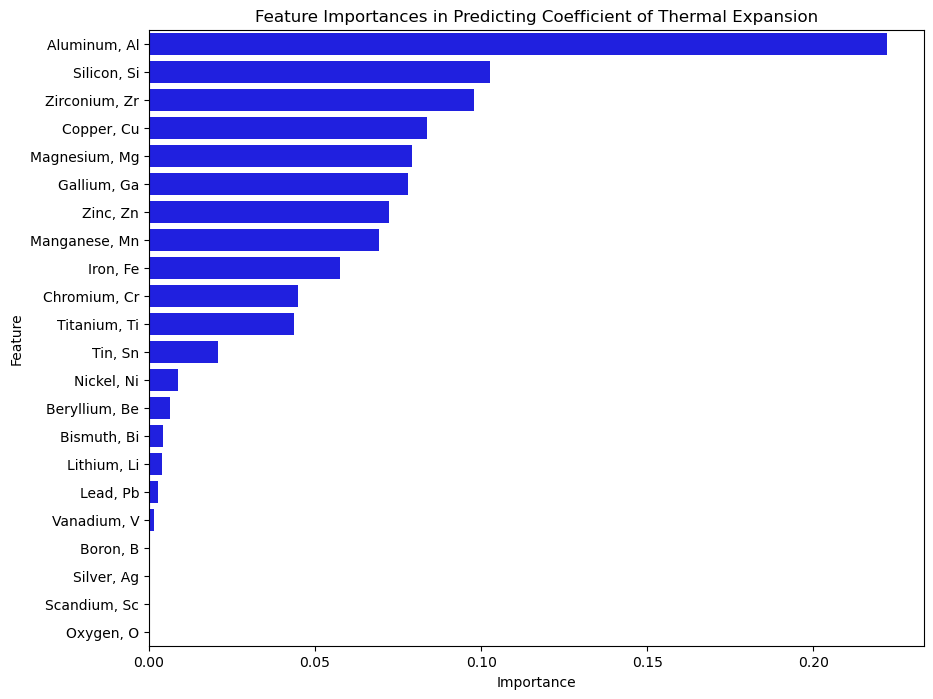

(0.5055254553319185,
           Feature  Importance
 0    Aluminum, Al    0.222158
 6     Silicon, Si    0.102779
 9   Zirconium, Zr    0.097744
 2      Copper, Cu    0.083727
 4   Magnesium, Mg    0.079273
 13    Gallium, Ga    0.078042
 8        Zinc, Zn    0.072309
 5   Manganese, Mn    0.069175
 3        Iron, Fe    0.057646
 1    Chromium, Cr    0.044840
 7    Titanium, Ti    0.043774
 18        Tin, Sn    0.020680
 12     Nickel, Ni    0.008673
 15  Beryllium, Be    0.006317
 16    Bismuth, Bi    0.004175
 20    Lithium, Li    0.003911
 17       Lead, Pb    0.002684
 10    Vanadium, V    0.001529
 11       Boron, B    0.000391
 21     Silver, Ag    0.000174
 19   Scandium, Sc    0.000000
 14      Oxygen, O    0.000000)

In [81]:
output_dir = "Images/Aluminum/COTE"
train_and_evaluate_simple_rf(X_train, y_train, X_test, y_test, output_dir, "Coefficient of Thermal Expansion")

#### Combination Neural Network Feature Combination Importance

Loading existing results...
4/4 [==============================] - 0s 1ms/step


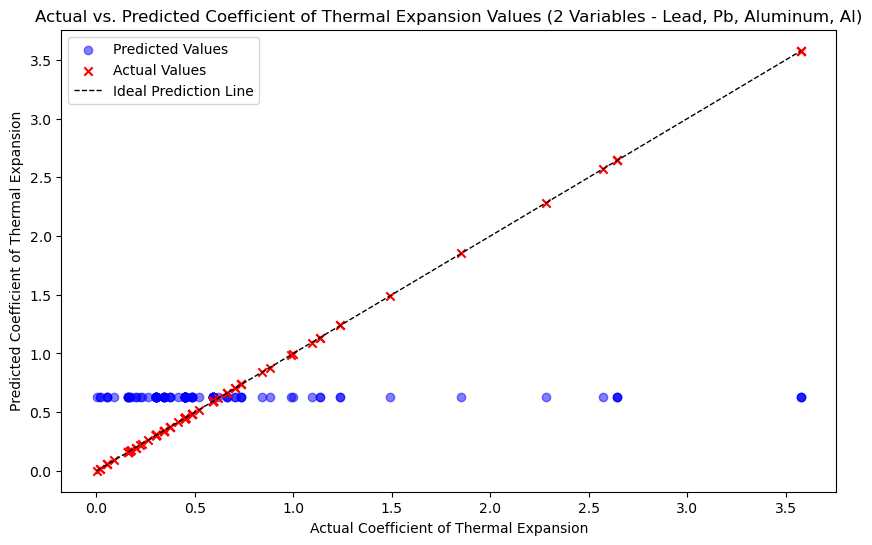

Best combination including Aluminum, Al: ('Lead, Pb', 'Aluminum, Al'), MSE: 0.5672246217727661
Graph and LaTeX file saved with element pair in names: Images/Aluminum/COTE/Aluminum_Coefficient_of_Thermal_Expansion_2VariableMLP.png and Images/Aluminum/COTE/Aluminum_Coefficient_of_Thermal_Expansion_2VariableMLP.tex


In [82]:
top_features = ['Silicon, Si', 'Copper, Cu', 'Iron, Fe', 
                'Magnesium, Mg', 'Zinc, Zn', 'Manganese, Mn', 'Bismuth, Bi', 'Titanium, Ti', 
                'Lithium, Li', 'Nickel, Ni', 'Chromium, Cr', 'Zirconium, Zr', 'Vanadium, V', 
                'Tin, Sn', 'Lead, Pb', 'Scandium, Sc', 'Beryllium, Be', 'Gallium, Ga', 
                'Boron, B', 'Silver, Ag']
fixed_feature = 'Aluminum, Al'
file_path = 'Al_model_data/mse_scores_with_aluminum_2_features_COTE.csv'
plotdir = 'Images/Aluminum/COTE'
process2VariableMLP(metals_and_thermalE, top_features, fixed_feature, "Coefficient of Thermal Expansion", file_path, plotdir)

Loading existing results...
4/4 [==============================] - 0s 1ms/step


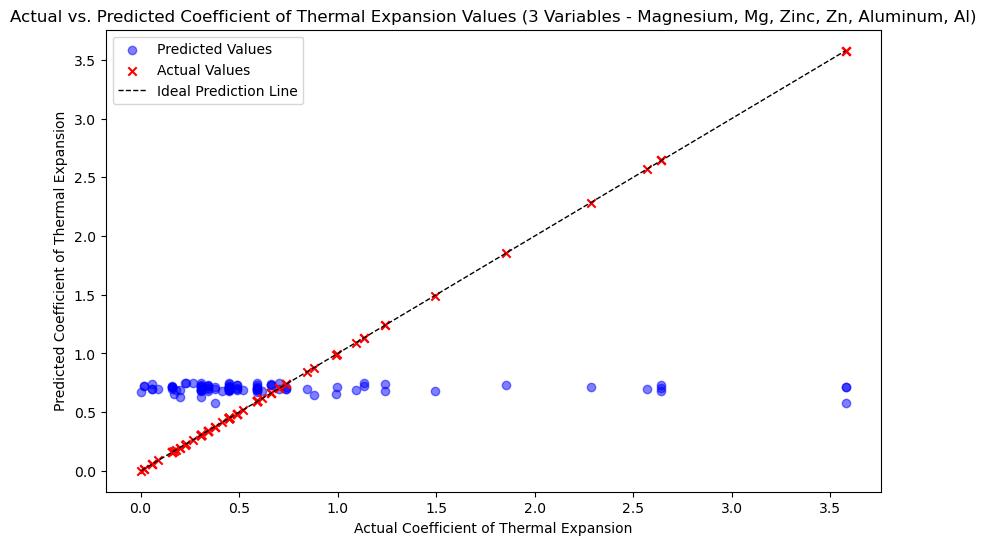

Best combination including Aluminum, Al: ('Magnesium, Mg', 'Zinc, Zn', 'Aluminum, Al'), MSE: 0.5662409067153931
Graph and LaTeX file saved with element pair in names: Images/Aluminum/COTE/Aluminum_Coefficient_of_Thermal_Expansion_3VariableMLP.png and Images/Aluminum/COTE/Aluminum_Coefficient_of_Thermal_Expansion_3VariableMLP.tex


In [83]:
top_features = ['Silicon, Si', 'Zirconium, Zr', 'Copper, Cu', 'Magnesium, Mg', 'Gallium, Ga', 'Zinc, Zn', 'Iron, Fe', 'Chromium, Cr', 'Titanium, Ti']
fixed_feature = 'Aluminum, Al'
file_path = 'Al_model_data/mse_scores_with_aluminum_3_features_COTE.csv'
plotdir = 'Images/Aluminum/COTE'
process3VariableMLP(metals_and_thermalE, top_features, fixed_feature, "Coefficient of Thermal Expansion", file_path, plotdir)

#### Correlation Matrix 

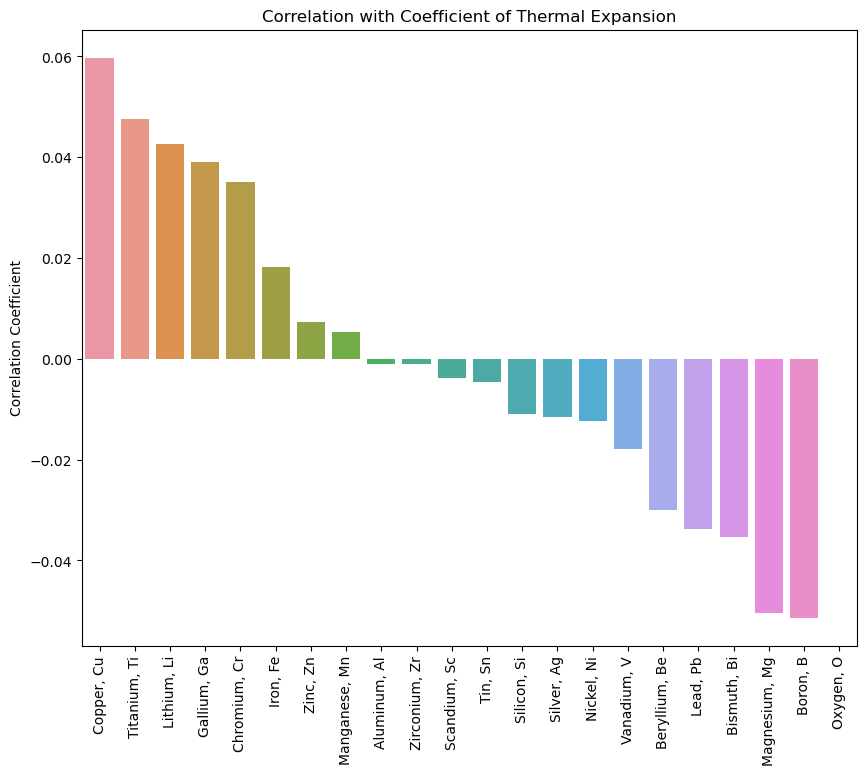

Copper, Cu       0.059749
Titanium, Ti     0.047647
Lithium, Li      0.042611
Gallium, Ga      0.039113
Chromium, Cr     0.035090
Iron, Fe         0.018229
Zinc, Zn         0.007383
Manganese, Mn    0.005267
Aluminum, Al    -0.000968
Zirconium, Zr   -0.001105
Scandium, Sc    -0.003808
Tin, Sn         -0.004659
Silicon, Si     -0.010930
Silver, Ag      -0.011572
Nickel, Ni      -0.012362
Vanadium, V     -0.017904
Beryllium, Be   -0.030042
Lead, Pb        -0.033771
Bismuth, Bi     -0.035305
Magnesium, Mg   -0.050447
Boron, B        -0.051368
Oxygen, O             NaN
Name: Coefficient of Thermal Expansion, dtype: float64

In [84]:
target_feature = "Coefficient of Thermal Expansion"
output_dir = "Images/Aluminum/COTE"
visualize_correlation(metals_and_thermalE, target_feature, output_dir)

#### Regression

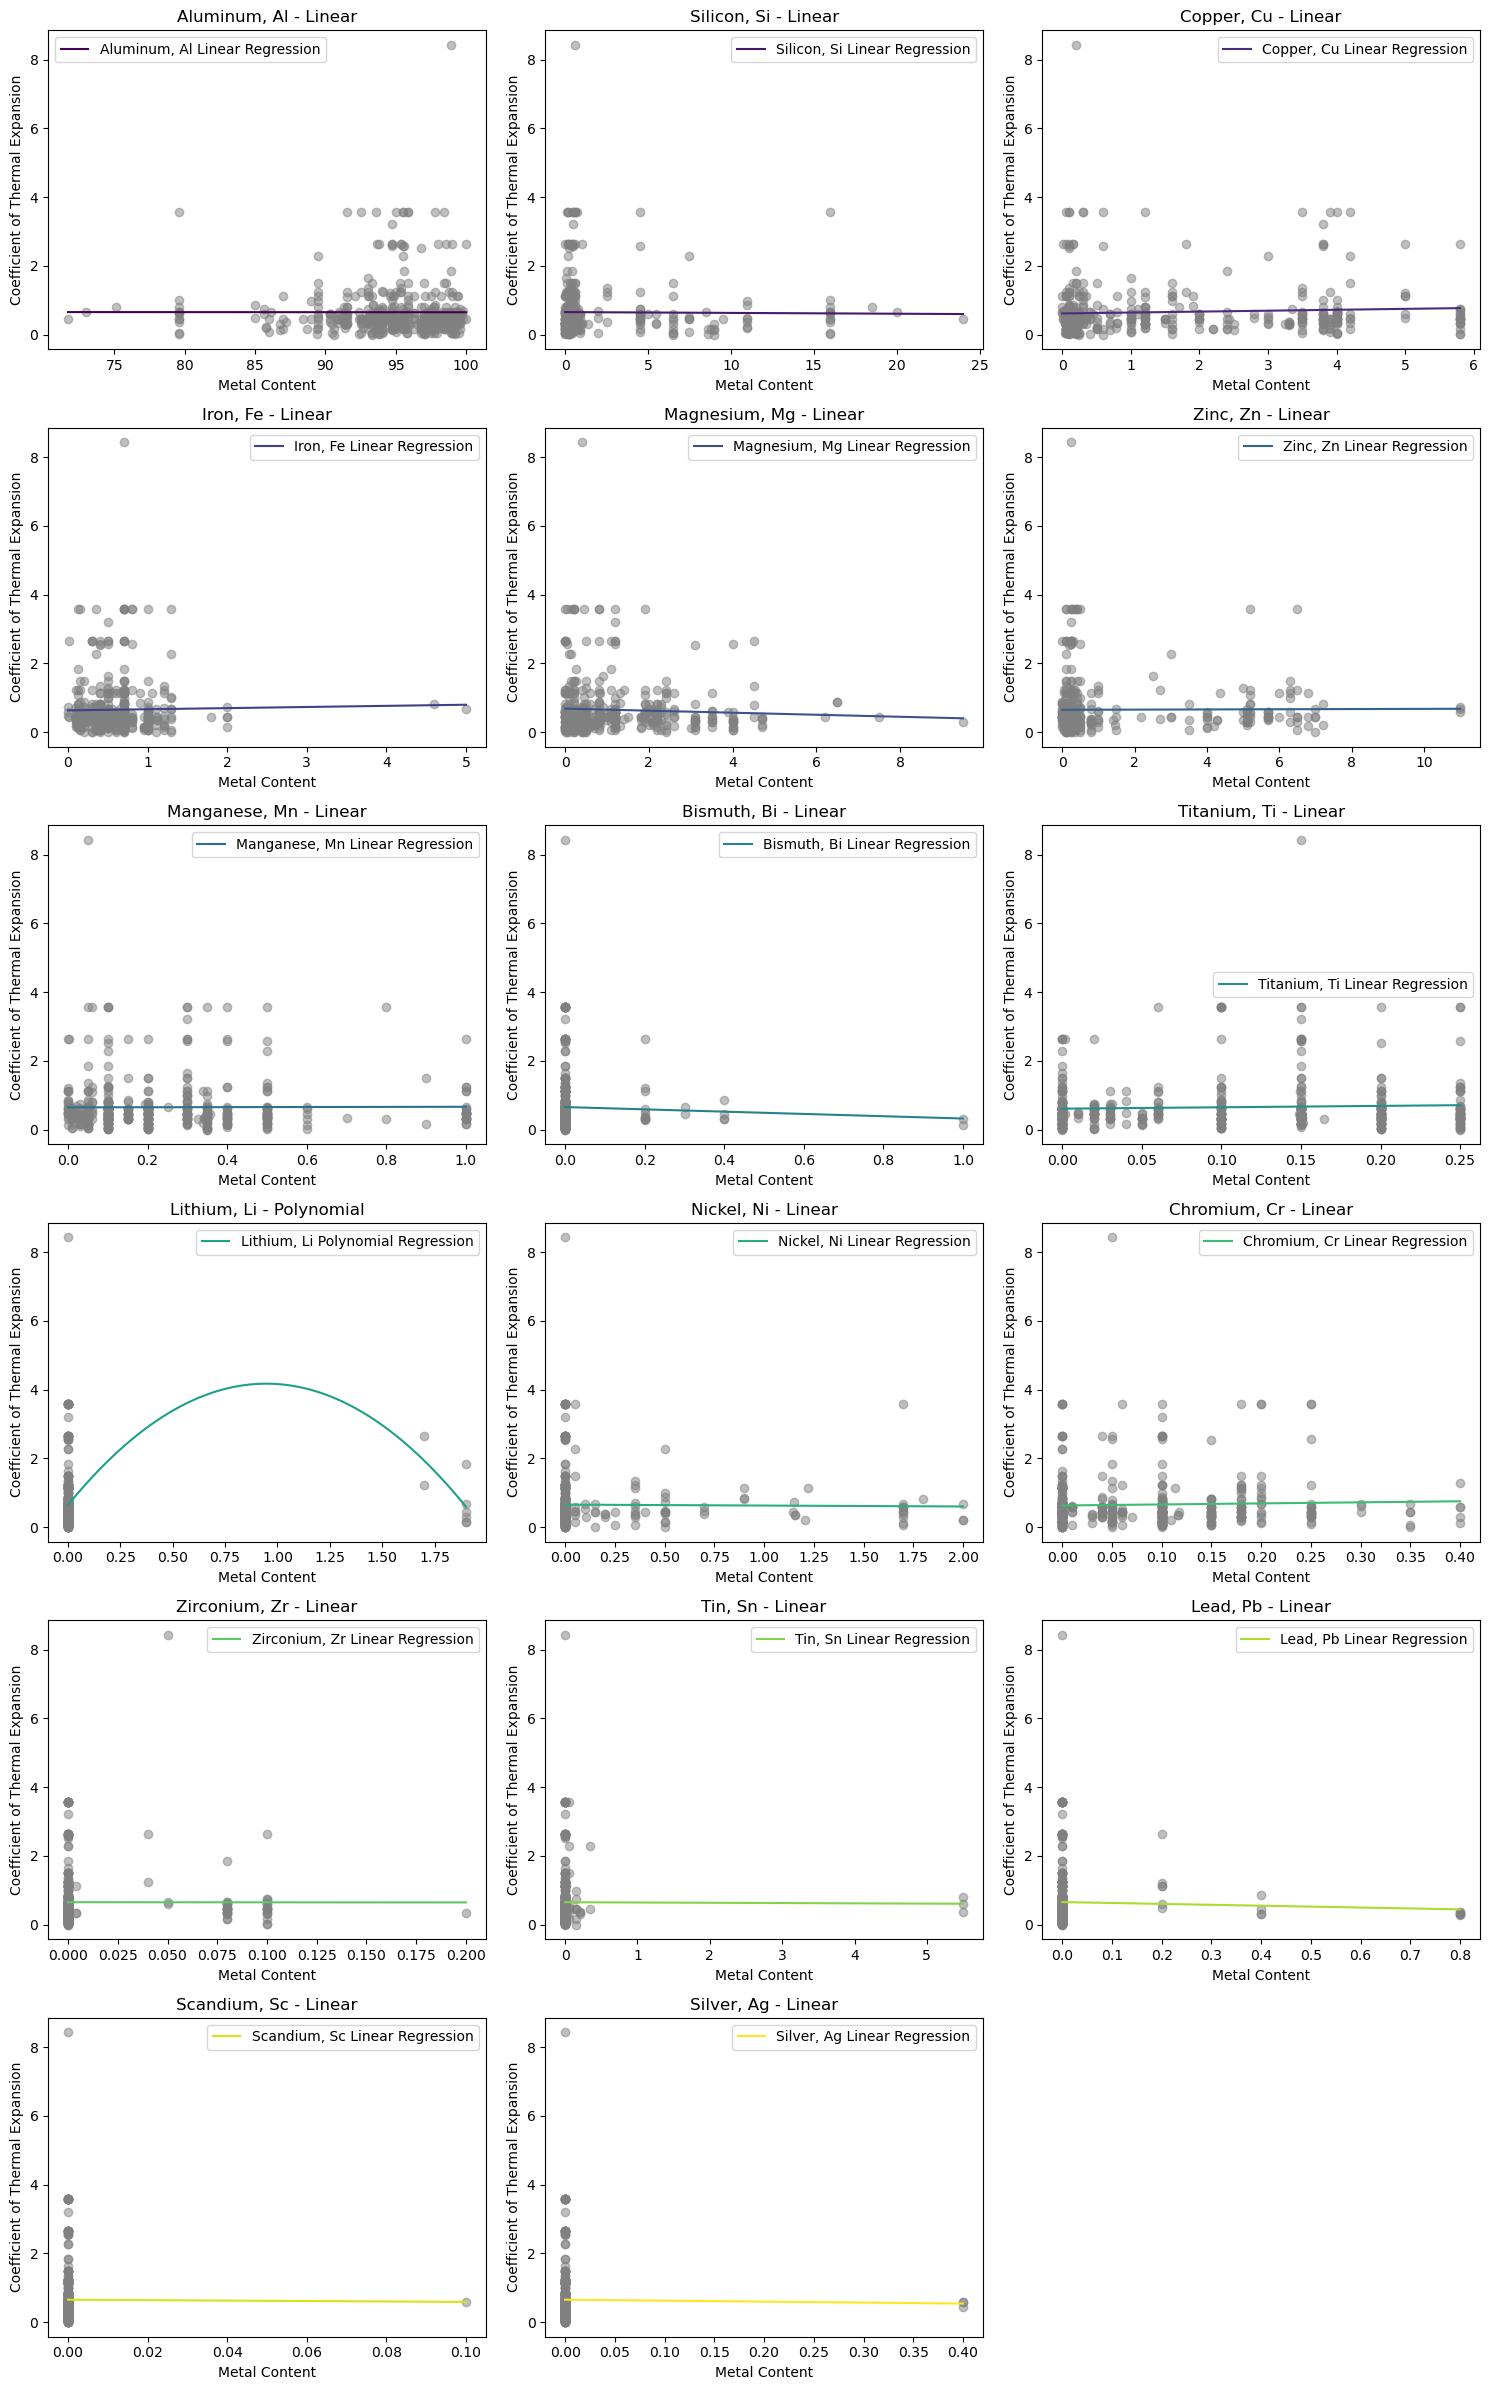

(            Metal  Coefficient     Effect
 0    Aluminum, Al    -0.000171  Decreases
 1     Silicon, Si    -0.002360  Decreases
 2      Copper, Cu     0.026641  Increases
 3        Iron, Fe     0.032767  Increases
 4   Magnesium, Mg    -0.029552  Decreases
 5        Zinc, Zn     0.002761  Increases
 6   Manganese, Mn     0.016623  Increases
 7     Bismuth, Bi    -0.332349  Decreases
 8    Titanium, Ti     0.405001  Increases
 9     Lithium, Li    -3.932891  Decreases
 10     Nickel, Ni    -0.027060  Decreases
 11   Chromium, Cr     0.305099  Increases
 12  Zirconium, Zr    -0.032080  Decreases
 13        Tin, Sn    -0.008216  Decreases
 14       Lead, Pb    -0.264112  Decreases
 15   Scandium, Sc    -0.639626  Decreases
 16     Silver, Ag    -0.281111  Decreases,
 'Images/Aluminum/COTE/Aluminum_Coefficient_of_Thermal_Expansion_IndividualElementRegression.png')

In [85]:
metals = ['Aluminum, Al', 'Silicon, Si', 'Copper, Cu', 'Iron, Fe', 
          'Magnesium, Mg', 'Zinc, Zn', 'Manganese, Mn', 'Bismuth, Bi', 'Titanium, Ti', 
          'Lithium, Li', 'Nickel, Ni', 'Chromium, Cr', 'Zirconium, Zr', 'Vanadium, V', 
          'Tin, Sn', 'Lead, Pb', 'Scandium, Sc', 'Beryllium, Be', 'Gallium, Ga', 
          'Boron, B', 'Silver, Ag']
target_feature = "Coefficient of Thermal Expansion"
plot_dir = "Images/Aluminum/COTE"
evaluate_and_visualize_impact(metals_and_thermalE, metals, target_feature, plot_dir)

In [86]:
## Splitting the DataFrame into positive and negative subsets
#positive_df = impact_summary[impact_summary['Coefficient'] > 0].copy()
#negative_df = impact_summary[impact_summary['Coefficient'] < 0].copy()
#
## Sorting each subset
#positive_df.sort_values(by='Coefficient', ascending=False, inplace=True)
#negative_df.sort_values(by='Coefficient', ascending=False, inplace=True)  # Sort negatives in descending order by value
#
## Concatenating back into a single DataFrame
#sorted_impact_summary = pd.concat([positive_df, negative_df], axis=0)
#
## Define colors based on coefficient sign and set edge colors for better visibility
#colors = ['green' if x > 0 else 'red' for x in sorted_impact_summary['Coefficient']]
#edge_colors = ['darkgreen' if x > 0 else 'darkred' for x in sorted_impact_summary['Coefficient']]
#
## Set up the plot
#plt.figure(figsize=(10, 8))
#bars = plt.barh(sorted_impact_summary['Metal'], sorted_impact_summary['Coefficient'], color=colors, edgecolor=edge_colors)
#plt.xlabel('Coefficient Value')
#plt.title('Impact of Each Metal on Coefficient of Thermal Expansion')
#
## Invert y-axis to have the largest impact at the top
#plt.gca().invert_yaxis()
#
## Add text labels to bars for exact coefficient values
#for bar, value in zip(bars, sorted_impact_summary['Coefficient']):
#    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{value:.2f}', va='center', 
#             ha='right' if value < 0 else 'left')
#
## Show the plot
#plt.savefig('Images/Aluminum/COTE/IndividualElementImpact.png')
#plt.show()
#
#latex_code = r"""
#\begin{figure}[h]
#    \centering
#    \includegraphics[width=0.8\textwidth]{Images/Aluminum/COTE/IndividualElementImpact.png}
#    \caption{Individual Element Impact of Aluminum based alloys predicting the COTE}
#    \label{fig:IndividualElementImpact_Al_COTE}
#\end{figure}
#"""
#
## Write the LaTeX code to a .tex file
#with open('Images/Aluminum/COTE/IndividualElementImpact.tex', 'w') as f:
#    f.write(latex_code)
#
## Optionally, print the DataFrame for a tabular view
#print(sorted_impact_summary[['Metal', 'Coefficient', 'Effect']])

### <span style="color:lime">Optimizing Thermal Expansion</span>

#### <span style="color:red">Random Forest</span>

In [87]:
selected_features = ['Aluminum, Al', 'Silicon, Si', 'Zirconium, Zr', 'Copper, Cu', 'Magnesium, Mg', 'Gallium, Ga', 'Zinc, Zn', 'Iron, Fe', 'Chromium, Cr', 'Titanium, Ti']
target_variable = 'Coefficient of Thermal Expansion'
results = analyze_alloy_strength(metals_and_thermalE, selected_features, target_variable)
print(results)
model = results['model']

{'mse': 1.1065243781505405, 'rmse': 1.0519146249342388, 'max_youngs_modulus': 1.9939060419062662, 'strongest_composition': Aluminum, Al     95.40
Silicon, Si       0.20
Zirconium, Zr     0.04
Copper, Cu        1.80
Magnesium, Mg     1.10
Gallium, Ga       0.00
Zinc, Zn          0.25
Iron, Fe          0.30
Chromium, Cr      0.10
Titanium, Ti      0.10
Name: 223, dtype: float64, 'model': RandomForestRegressor(random_state=42)}


In [88]:
output_path = "Al_model_data/all_hypothetical_combinations_with_predictions_aluminum_COTE.csv"
metals = ['Silicon, Si', 'Zirconium, Zr', 'Copper, Cu', 'Magnesium, Mg', 'Gallium, Ga', 'Zinc, Zn', 'Iron, Fe', 'Chromium, Cr', 'Titanium, Ti']
al_increments = np.arange(75, 101, 5)
other_increments = np.arange(0, 26, 5)

top_combinations = generate_and_predict_alloy_strength(model, output_path, metals, al_increments, other_increments, 'Coefficient of Thermal Expansion')
print("Top 10 Coefficient of Thermal Expansion Combinations:")
print(top_combinations.head(10))  # Print only the top 10

Loaded results from existing file.
Top 10 Coefficient of Thermal Expansion Combinations:
      Aluminum, Al  Silicon, Si  Zirconium, Zr  Copper, Cu  Magnesium, Mg  \
945             75            5              0           5              0   
841             75            5              0           0              0   
509             75            0              5           0              0   
524             75            0              5           0              0   
699             75            0             10           0              0   
1524            80            0              5           0              0   
1026            75            5              5           0              0   
74              75            0              0           0              0   
103             75            0              0           0              0   
118             75            0              0           0              0   

      Gallium, Ga  Zinc, Zn  Iron, Fe  Chromium, Cr  Titanium, 

#### <span style="color:red">MLP</span>

In [89]:
# Assuming metals_and_thermalE is preloaded with the relevant data
selected_features = ['Aluminum, Al', 'Silicon, Si', 'Zirconium, Zr', 'Copper, Cu', 'Magnesium, Mg', 'Gallium, Ga', 'Zinc, Zn', 'Iron, Fe', 'Chromium, Cr', 'Titanium, Ti']
target_variable = "Coefficient of Thermal Expansion"

layer_configurations = [
    (30, 3, 1), (40, 2), (10, 10), (3, 10, 2),
    (10,), (20,), (30,), (40,), (50,),
    (8,), (8, 8), (8, 5, 2),
    (5, 5), (10, 10), (20, 5), (5, 20),
    (15, 6), (6, 6), (6, 6, 2),
    (5,), (5, 10, 2), (10, 10), (5, 10),
    (2,), (2,2), (2,2,2), (2,2,2,2)
]
max_iter_options = [4000]
results_path = 'Al_model_data/grid_search_aluminium_COTE_results.csv'

# Call the grid search function
result = perform_grid_search_nn(metals_and_thermalE, selected_features, target_variable, layer_configurations, max_iter_options, results_path)
X_train, X_test, y_train, y_test = result['X_train'], result['X_test'], result['y_train'], result['y_test']
grid_search_results = result['results_df']
print("Grid search results DataFrame:")
print(grid_search_results)

# Sort the results DataFrame by the 'MSE' column in ascending order
sorted_results = grid_search_results.sort_values(by='MSE', ascending=True)

# Print the sorted results
print("Sorted Grid Search Results by MSE:")
print(sorted_results)

Loaded existing results from file.
Grid search results DataFrame:
          Layers  Max_iter       MSE
0     (30, 3, 1)      4000  0.565586
1        (40, 2)      4000  0.581686
2       (10, 10)      4000  0.573205
3     (3, 10, 2)      4000  0.586224
4          (10,)      4000  0.588830
5          (20,)      4000  0.660052
6          (30,)      4000  0.611079
7          (40,)      4000  0.677379
8          (50,)      4000  0.742158
9           (8,)      4000  0.597809
10        (8, 8)      4000  0.565570
11     (8, 5, 2)      4000  0.581566
12        (5, 5)      4000  0.584520
13      (10, 10)      4000  0.573205
14       (20, 5)      4000  0.588879
15       (5, 20)      4000  0.590860
16       (15, 6)      4000  0.590473
17        (6, 6)      4000  0.574616
18     (6, 6, 2)      4000  0.574505
19          (5,)      4000  0.584611
20    (5, 10, 2)      4000  0.581162
21      (10, 10)      4000  0.573205
22       (5, 10)      4000  0.583810
23          (2,)      4000  0.578578
24       

/Users/lukerickard/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Mean Squared Error - Huber Regressor: 0.6075294305398717


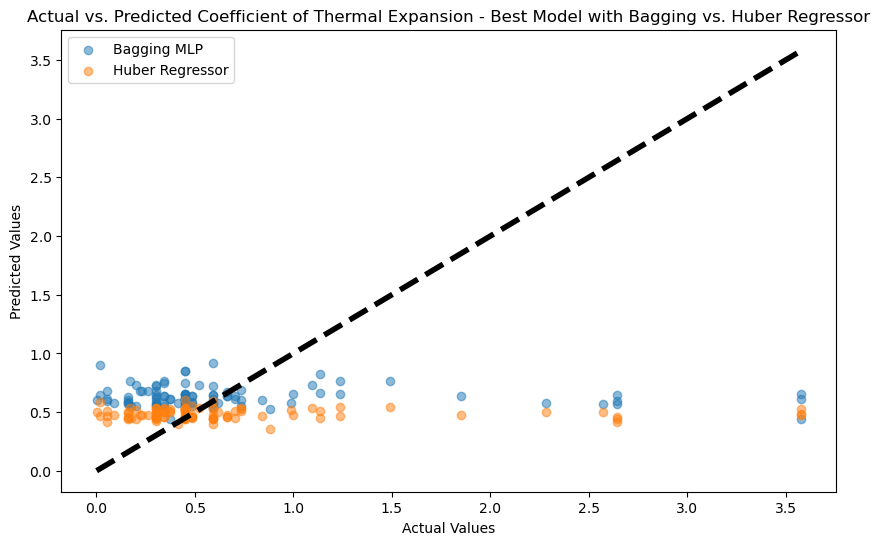

MSE for Huber Regressor: 0.6075294305398717


In [90]:
best_layers = (20, 5)
best_max_iter = 4000
output_dir = 'Images/Aluminum/COTE'
target_variable = "Coefficient of Thermal Expansion"
results = compare_bagging_huber(X_train, y_train, X_test, y_test, best_layers, best_max_iter, output_dir, target_variable)
mse_huber = results['mse_huber']
actual = results['actual']
predbag = results['predbag']
predhuber = results['predhuber']
best_model = results['model']
print("MSE for Huber Regressor:", mse_huber)

Spearman's rank correlation coefficient: 0.009999341442870636
P-value of the correlation coefficient: 0.9217488185436727
Plot saved to Images/Aluminum/COTE/Aluminum_Coefficient_of_Thermal_Expansion_BaggingMLP.png


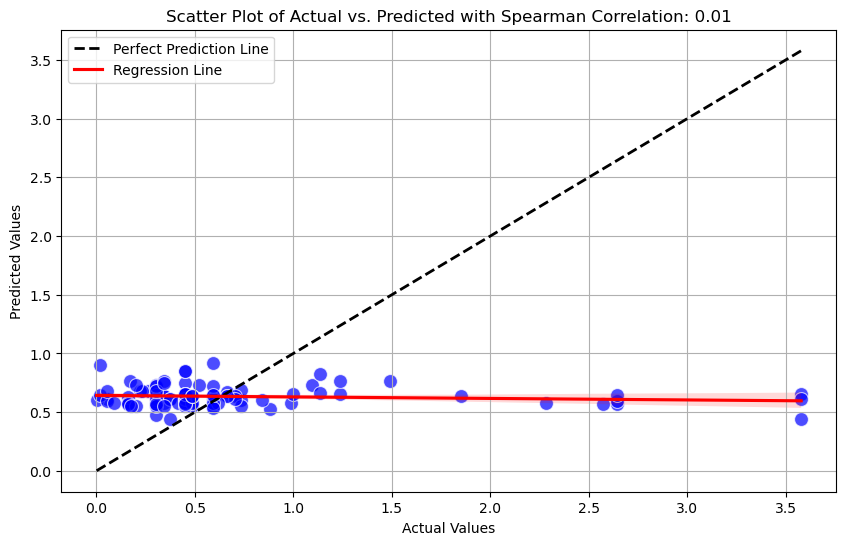

Spearman's rank correlation coefficient: 0.035267804978877125
P-value of the correlation coefficient: 0.7289208219591354
Plot saved to Images/Aluminum/COTE/Aluminum_Coefficient_of_Thermal_Expansion_HuberMLP.png


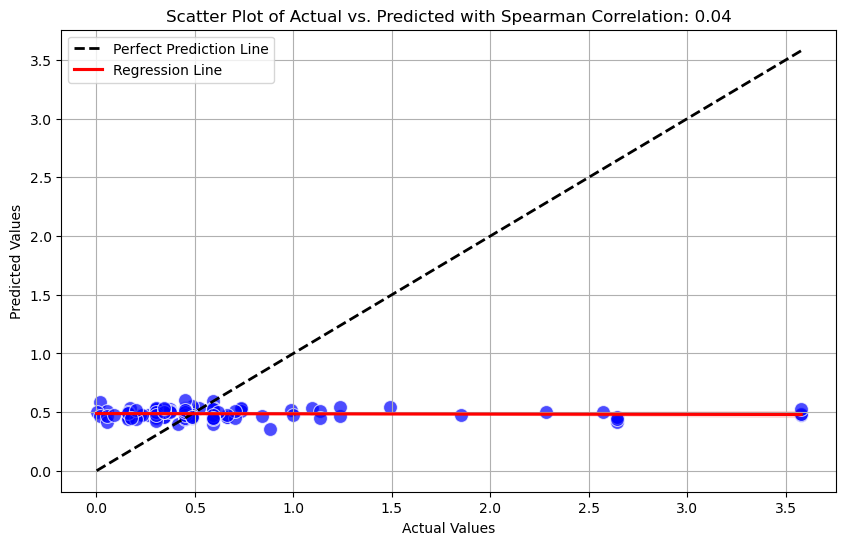

Bagging Model Spearman Correlation: 0.009999341442870636
Huber Model Spearman Correlation: 0.035267804978877125


In [91]:
# Example usage of the generalized function
output_dir = 'Images/Aluminum/COTE'
actuals = actual  # Example actual values from your test set
preds_bagging = predbag  # Example prediction values from the Bagging model
preds_huber = predhuber  # Example prediction values from the Huber model

# For Bagging MLP
correlation_bagging = show_correlation("Bagging", output_dir, actuals, preds_bagging, "Coefficient of Thermal Expansion")

# For Huber MLP
correlation_huber = show_correlation("Huber", output_dir, actuals, preds_huber, "Coefficient of Thermal Expansion")

print("Bagging Model Spearman Correlation:", correlation_bagging)
print("Huber Model Spearman Correlation:", correlation_huber)

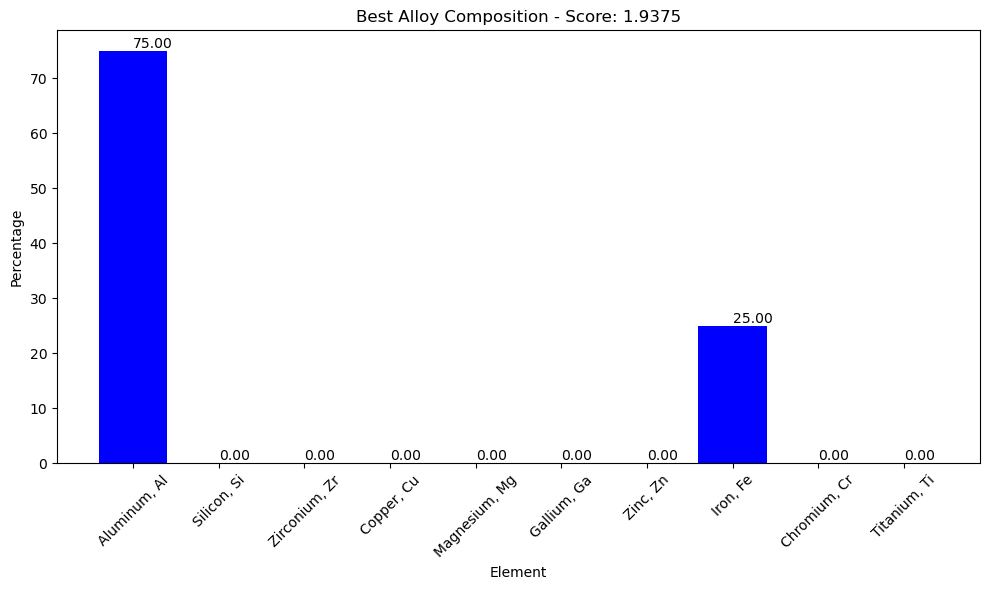

Best Composition: [7.50000000e+01 0.00000000e+00 1.99856024e-14 0.00000000e+00
 7.65968664e-11 0.00000000e+00 0.00000000e+00 2.50000000e+01
 1.99621816e-09 2.77947888e-13]
Best Score: 1.937475708824802


In [92]:
output_dir = 'Images/Aluminum/COTE'
target_property = "Coefficient of Thermal Expansion"
best_composition, best_score = optimize_alloy_composition(X_train, output_dir, target_property, metal)
print("Best Composition:", best_composition)
print("Best Score:", best_score)

## Overall Best Aluminium

In [200]:
df_filtered = df[df['Specific Heat'] <= 3]

In [201]:
# Define target columns
target_columns = ['Young\'s Modulus', 'Yield Strength', 'Tensile Strength', 'Specific Heat', 'Coefficient of Thermal Expansion']

# Define input features
input_features = ['Aluminum, Al', 'Silicon, Si', 'Magnesium, Mg', 'Gallium, Ga', 'Lithium, Li', 'Zinc, Zn' ,'Titanium, Ti', 'Nickel, Ni', 'Copper, Cu', 'Iron, Fe', 'Manganese, Mn']  # List of input feature columns

# Select input features and targets from the DataFrame
input_data = df_filtered[input_features]
targets = df_filtered[target_columns]

# Split the data into training, validation, and test sets
train_data, test_data, train_targets, test_targets = train_test_split(input_data, targets, test_size=0.3, random_state=42)
train_data, val_data, train_targets, val_targets = train_test_split(train_data, train_targets, test_size=0.2, random_state=42)

# Output the shapes of each set to confirm the sizes
train_data.shape, val_data.shape, test_data.shape

((272, 11), (69, 11), (147, 11))

In [202]:
# Number of input features
input_dim = train_data.shape[1]

# Create the MLP model
model = Sequential([
    Dense(20, input_dim=input_dim, activation='relu'),  # First hidden layer
    Dense(5, activation='linear'),                       # Second hidden layer
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

No existing model found. Training a new model.
Epoch 1/350
9/9 [==============================] - 1s 27ms/step - loss: 314.9113 - val_loss: 278.5408
Epoch 2/350
9/9 [==============================] - 0s 6ms/step - loss: 262.0556 - val_loss: 231.6945
Epoch 3/350
9/9 [==============================] - 0s 6ms/step - loss: 218.2536 - val_loss: 192.9473
Epoch 4/350
9/9 [==============================] - 0s 6ms/step - loss: 182.0690 - val_loss: 161.3987
Epoch 5/350
9/9 [==============================] - 0s 6ms/step - loss: 153.2086 - val_loss: 136.4753
Epoch 6/350
9/9 [==============================] - 0s 6ms/step - loss: 130.1934 - val_loss: 116.5155
Epoch 7/350
9/9 [==============================] - 0s 6ms/step - loss: 111.5532 - val_loss: 100.1178
Epoch 8/350
9/9 [==============================] - 0s 6ms/step - loss: 96.0242 - val_loss: 86.2985
Epoch 9/350
9/9 [==============================] - 0s 6ms/step - loss: 82.8732 - val_loss: 74.5416
Epoch 10/350
9/9 [=============================

/Users/lukerickard/opt/anaconda3/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


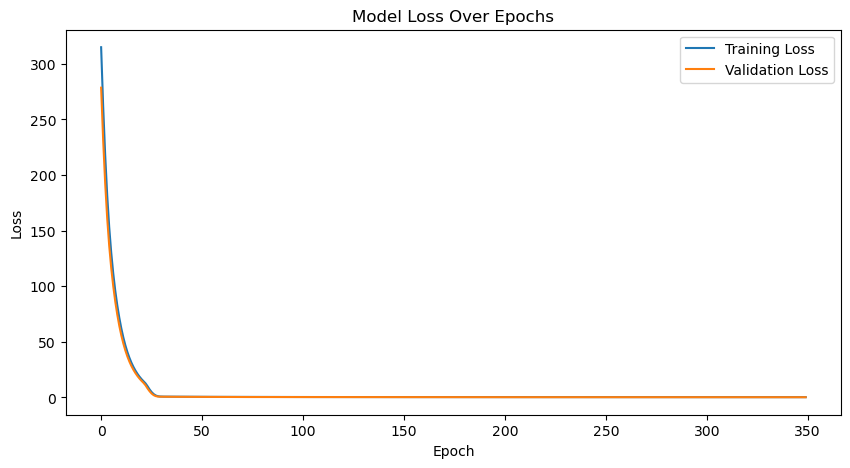

In [203]:
model_path = 'Al_model_data/Finalmodel.h5'  # Path where the model is saved

# Check if the model file exists
if os.path.exists(model_path):
    print("Model exists. Loading the model...")
    model = load_model(model_path)
    # Optional: Evaluate the model or continue training
else:
    print("No existing model found. Training a new model.")
    # Model training code
    history = model.fit(train_data, train_targets, epochs=350, validation_data=(val_data, val_targets))

    # Save the model after training
    model.save(model_path)
    print("Model saved at:", model_path)

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [204]:
# Assuming df is already defined and includes the necessary properties
min_values = np.array([df_filtered['Young\'s Modulus'].min(), df_filtered['Yield Strength'].min(), 
                       df_filtered['Tensile Strength'].min(), df_filtered['Specific Heat'].min(), 
                       df_filtered['Coefficient of Thermal Expansion'].min()])
max_values = np.array([df_filtered['Young\'s Modulus'].max(), df_filtered['Yield Strength'].max(), 
                       df_filtered['Tensile Strength'].max(), df_filtered['Specific Heat'].max(), 
                       df_filtered['Coefficient of Thermal Expansion'].max()])
# Print the minimum and maximum values
print("Minimum Values:", min_values)
print("Maximum Values:", max_values)

def objective_function(composition):
    composition = np.array(composition).reshape(1, -1)
    properties = model.predict(composition, verbose=0).flatten()

    # Normalize each property to the range [0, 1] based on its min and max values
    #normalized_properties = (properties - min_values) / (max_values - min_values)

    # Apply weights to the normalized properties
    # Assuming properties are now correctly scaled between 0 and 1
    weighted_score = (properties[0] +
                      properties[1] * 0 +
                      properties[2] * 0 +
                      properties[3] * 0 +
                      properties[4] * 0)

    # Calculate the diversity penalty to encourage a diverse composition
    #diversity_penalty = -np.sum((composition[1:] - np.mean(composition[1:]))**2)

    # The function aims to maximize the score (thus the negative sign for minimization)
    return -(weighted_score)

Minimum Values: [0.02969016 0.00756036 0.01771238 0.01432898 0.00149629]
Maximum Values: [6.3977567  3.87010516 3.43213052 1.27997274 8.428249  ]


In [205]:
bounds = [(75, 100)] + [(0, 100) for _ in range(1, 11)]
cons = {'type': 'eq', 'fun': lambda x: 100 - np.sum(x)}

results = []
initial_compositions = []
final_compositions = []

for i in range(100):
    initial_composition_random = [75] + [rand()*25 for _ in range(1, 11)]
    initial_composition_random = np.array(initial_composition_random)
    initial_composition_random /= np.sum(initial_composition_random) / 100

    initial_compositions.append(initial_composition_random.copy())

    result_random = minimize(
        objective_function, 
        initial_composition_random, 
        method='SLSQP', 
        bounds=bounds, 
        constraints=cons, 
        options={'disp': True, 'maxiter': 1000}
    )

    if result_random.success:
        final_compositions.append(result_random.x)
        best_score_random = -result_random.fun
        results.append((result_random.x, best_score_random))
    else:
        final_compositions.append(None)

# Save results to a text file
with open('Al_model_data/alloy_optimization_results.txt', 'w') as f:
    for idx, (composition, score) in enumerate(results):
        f.write(f"Alloy {idx+1}: Composition = {composition}, Score = {score}\n")

# Find the best alloy
best_alloy_index = np.argmax([score for _, score in results])
best_alloy, best_score = results[best_alloy_index]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.321683645248413
            Iterations: 2
            Function evaluations: 24
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.5113484859466553
            Iterations: 2
            Function evaluations: 24
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6514904499053955
            Iterations: 2
            Function evaluations: 24
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.949646234512329
            Iterations: 2
            Function evaluations: 24
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.8476301431655884
            Iterations: 2
            Function evaluatio

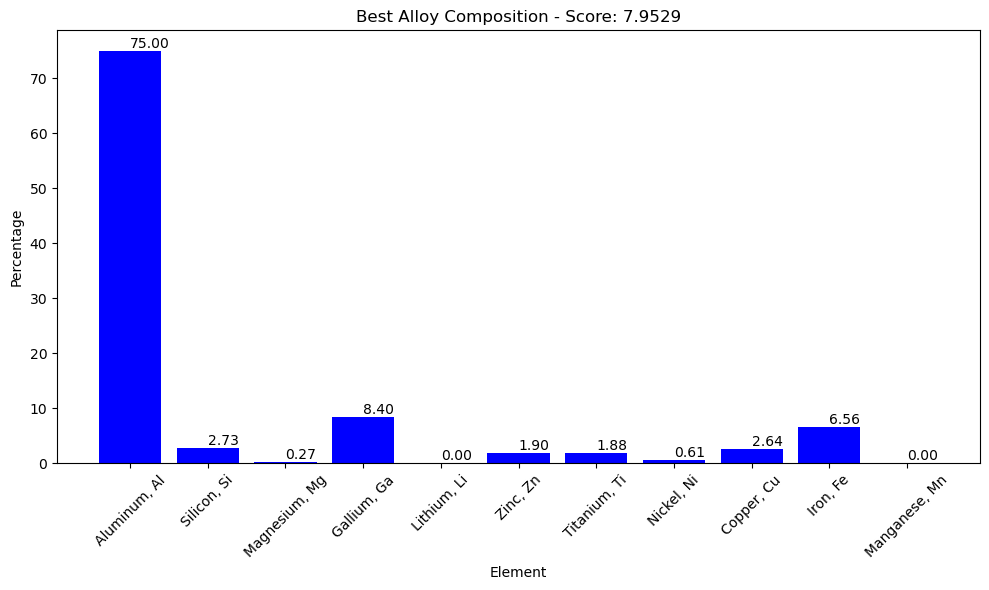

In [206]:
# Assuming we already have the best alloy and its score from the earlier setup
best_alloy_index = np.argmax([score for _, score in results])
best_alloy, best_score = results[best_alloy_index]

# Plot the best alloy composition along with its score
plt.figure(figsize=(10, 6))
bars = plt.bar(input_features, best_alloy, color='blue')
plt.xlabel('Element')
plt.ylabel('Percentage')
plt.title(f'Best Alloy Composition - Score: {best_score:.4f}')
plt.xticks(rotation=45)

# Add the score to each bar in the graph
for bar, percentage in zip(bars, best_alloy):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{percentage:.2f}', va='bottom')  # for composition percentage

plt.tight_layout()
plt.savefig('Images/Aluminum/Prediction/BestAlloyCompYM.png')
plt.show()

latex_code = r"""
\begin{figure}[h]
    \centering
    \includegraphics[width=0.8\textwidth]{Images/Aluminum/Prediction/BestAlloyCompYM.png}
    \caption{Best Alloy Composition of Aluminum based alloys but weighted to predict only Youngs Modulus}
    \label{fig:BestAlloyComp_Al}
\end{figure}
"""

# Write the LaTeX code to a .tex file
with open('Images/Aluminum/Prediction/BestAlloyCompYM.tex', 'w') as f:
    f.write(latex_code)


Normalized Predictions: [ 7.9529324   0.66327083  1.9683185  -7.081659   -6.580214  ]
Min Values Used for Scaling: [0.02969016 0.00756036 0.01771238 0.01432898 0.00149629]
Max Values Used for Scaling: [6.3977567  3.87010516 3.43213052 1.27997274 8.428249  ]


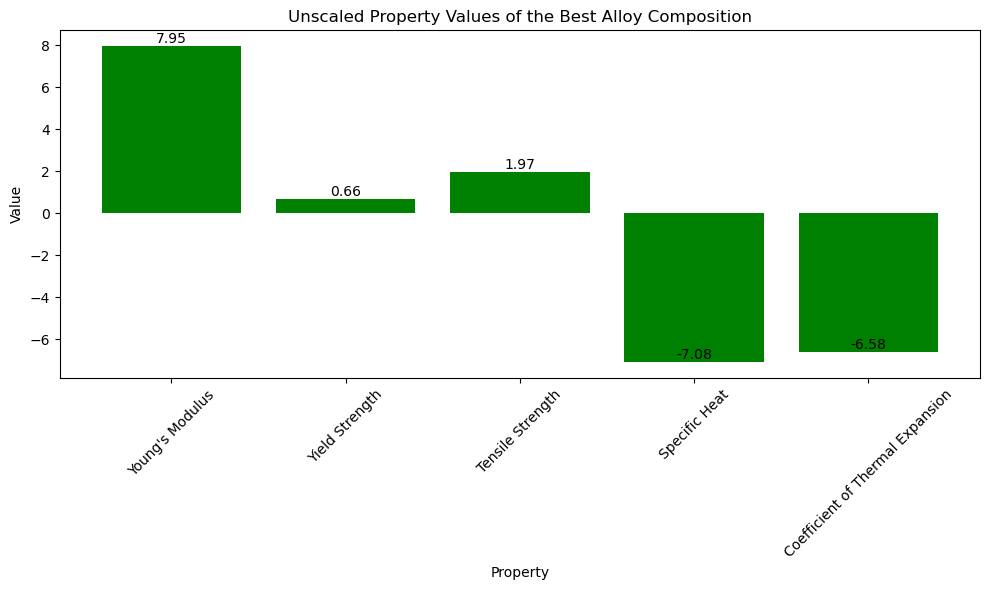

In [207]:
properties_normalized = model.predict(np.array([best_alloy]), verbose=0).flatten()
print("Normalized Predictions:", properties_normalized)  # Check the range of these values

# Print both normalized and actual values for verification
print("Min Values Used for Scaling:", min_values)
print("Max Values Used for Scaling:", max_values)


# Property names corresponding to min_values and max_values
property_names = ['Young\'s Modulus', 'Yield Strength', 'Tensile Strength', 'Specific Heat', 'Coefficient of Thermal Expansion']

# Plot the properties
plt.figure(figsize=(10, 6))
bars = plt.bar(property_names, properties_normalized, color='green')
plt.xlabel('Property')
plt.ylabel('Value')
plt.title('Unscaled Property Values of the Best Alloy Composition')

# Add the actual values to each bar in the graph
for bar, value in zip(bars, properties_normalized):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.2f}', va='bottom', ha='center')

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Images/Aluminum/Prediction/BestAlloyPropYM.png')
plt.show()

latex_code = r"""
\begin{figure}[h]
    \centering
    \includegraphics[width=0.8\textwidth]{Images/Aluminum/Prediction/BestAlloyPropYM.png}
    \caption{Best Alloy Properties of Aluminum based alloys but weighted to predict only Youngs Modulus}
    \label{fig:BestAlloyProp_Al}
\end{figure}
"""

# Write the LaTeX code to a .tex file
with open('Images/Aluminum/Prediction/BestAlloyPropYM.tex', 'w') as f:
    f.write(latex_code)

In [212]:
def objective_function(composition):
    composition = np.array(composition).reshape(1, -1)
    properties = model.predict(composition, verbose=0).flatten()

    # Normalize each property to the range [0, 1] based on its min and max values
    normalized_properties = (properties - min_values) / (max_values - min_values)

    # Apply weights to the normalized properties
    # Assuming properties are now correctly scaled between 0 and 1
    weighted_score = (normalized_properties[0] +
                      normalized_properties[1] +
                      normalized_properties[2] +
                      normalized_properties[3] * 0.3 +
                      normalized_properties[4] * 0.3)

    # Calculate the diversity penalty to encourage a diverse composition
    #diversity_penalty = -np.sum((composition[1:] - np.mean(composition[1:]))**2)

    # The function aims to maximize the score (thus the negative sign for minimization)
    return -(weighted_score)

In [213]:
bounds = [(75, 100)] + [(0, 100) for _ in range(1, 11)]
cons = {'type': 'eq', 'fun': lambda x: 100 - np.sum(x)}

results = []
initial_compositions = []
final_compositions = []

for i in range(100):
    initial_composition_random = [75] + [rand()*25 for _ in range(1, 11)]
    initial_composition_random = np.array(initial_composition_random)
    initial_composition_random /= np.sum(initial_composition_random) / 100

    initial_compositions.append(initial_composition_random.copy())

    result_random = minimize(
        objective_function, 
        initial_composition_random, 
        method='SLSQP', 
        bounds=bounds, 
        constraints=cons, 
        options={'disp': True, 'maxiter': 1000}
    )

    if result_random.success:
        final_compositions.append(result_random.x)
        best_score_random = -result_random.fun
        results.append((result_random.x, best_score_random))
    else:
        final_compositions.append(None)

# Save results to a text file
with open('Al_model_data/alloy_optimization_results.txt', 'w') as f:
    for idx, (composition, score) in enumerate(results):
        f.write(f"Alloy {idx+1}: Composition = {composition}, Score = {score}\n")

# Find the best alloy
best_alloy_index = np.argmax([score for _, score in results])
best_alloy, best_score = results[best_alloy_index]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.8381200715400025
            Iterations: 2
            Function evaluations: 24
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.6816033696975273
            Iterations: 2
            Function evaluations: 24
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7337043074798457
            Iterations: 3
            Function evaluations: 46
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0190947283319092
            Iterations: 3
            Function evaluations: 46
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7959384903256763
            Iterations: 2
            Function evaluat

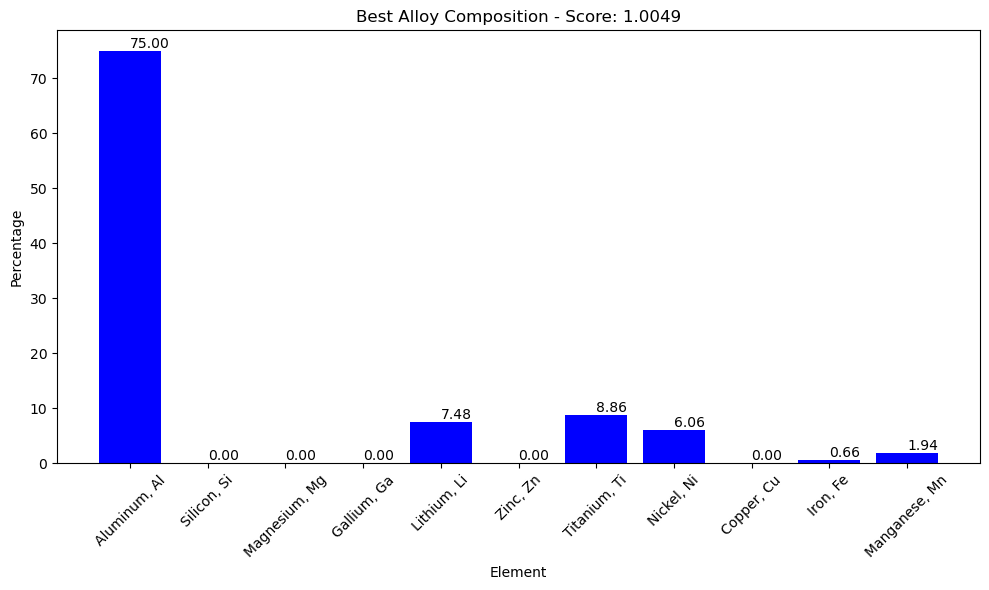

In [214]:
# Assuming we already have the best alloy and its score from the earlier setup
best_alloy_index = np.argmax([score for _, score in results])
best_alloy, best_score = results[best_alloy_index]

# Plot the best alloy composition along with its score
plt.figure(figsize=(10, 6))
bars = plt.bar(input_features, best_alloy, color='blue')
plt.xlabel('Element')
plt.ylabel('Percentage')
plt.title(f'Best Alloy Composition - Score: {best_score:.4f}')
plt.xticks(rotation=45)

# Add the score to each bar in the graph
for bar, percentage in zip(bars, best_alloy):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{percentage:.2f}', va='bottom')  # for composition percentage

plt.tight_layout()
plt.savefig('Images/Aluminum/Prediction/BestAlloyComp.png')
plt.show()

latex_code = r"""
\begin{figure}[h]
    \centering
    \includegraphics[width=0.8\textwidth]{Images/Aluminum/Prediction/BestAlloyComp.png}
    \caption{Best Alloy Composition of Aluminum}
    \label{fig:BestAlloyComp_Al}
\end{figure}
"""

# Write the LaTeX code to a .tex file
with open('Images/Aluminum/Prediction/BestAlloyComp.tex', 'w') as f:
    f.write(latex_code)

Normalized Predictions: [-1.272188   -0.68215287 -0.1519945   5.465317    4.0909376 ]
Min Values Used for Scaling: [0.02969016 0.00756036 0.01771238 0.01432898 0.00149629]
Max Values Used for Scaling: [6.3977567  3.87010516 3.43213052 1.27997274 8.428249  ]


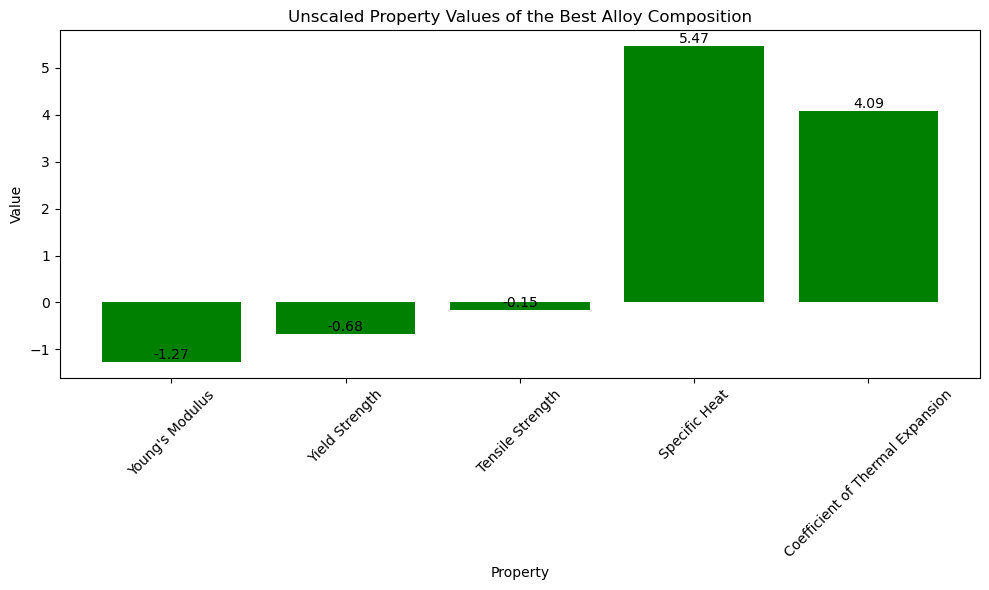

In [215]:
properties_normalized = model.predict(np.array([best_alloy]), verbose=0).flatten()
print("Normalized Predictions:", properties_normalized)  # Check the range of these values

# Print both normalized and actual values for verification
print("Min Values Used for Scaling:", min_values)
print("Max Values Used for Scaling:", max_values)


# Property names corresponding to min_values and max_values
property_names = ['Young\'s Modulus', 'Yield Strength', 'Tensile Strength', 'Specific Heat', 'Coefficient of Thermal Expansion']

# Plot the properties
plt.figure(figsize=(10, 6))
bars = plt.bar(property_names, properties_normalized, color='green')
plt.xlabel('Property')
plt.ylabel('Value')
plt.title('Unscaled Property Values of the Best Alloy Composition')

# Add the actual values to each bar in the graph
for bar, value in zip(bars, properties_normalized):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.2f}', va='bottom', ha='center')

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Images/Aluminum/Prediction/BestAlloyProp.png')
plt.show()

latex_code = r"""
\begin{figure}[h]
    \centering
    \includegraphics[width=0.8\textwidth]{Images/Aluminum/Prediction/BestAlloyProp.png}
    \caption{Best Alloy Properties of Aluminum}
    \label{fig:BestAlloyProp_Al}
\end{figure}
"""

# Write the LaTeX code to a .tex file
with open('Images/Aluminum/Prediction/BestAlloyProp.tex', 'w') as f:
    f.write(latex_code)

In [216]:
bounds = [(0, 100) for _ in range(11)]  # This assumes you have 10 elements total

# Constraint to ensure the total percentage is 100%
constraint = {'type': 'eq', 'fun': lambda x: 100 - np.sum(x)}

results = []
initial_compositions = []
final_compositions = []

# Perform the optimization 200 times with random initial compositions
for i in range(200):
    # Generate random values for each element
    initial_composition_random = np.random.rand(11) * 100
    # Normalize to ensure they sum to 100
    initial_composition_random /= np.sum(initial_composition_random) / 100

    initial_compositions.append(initial_composition_random.copy())

    # Minimize the objective function
    result_random = minimize(
        objective_function, 
        initial_composition_random, 
        method='SLSQP', 
        bounds=bounds, 
        constraints=constraint, 
        options={'disp': True, 'maxiter': 1000}
    )

    # Store the results
    if result_random.success:
        final_compositions.append(result_random.x)
        best_score_random = -result_random.fun
        results.append((result_random.x, best_score_random))
    else:
        final_compositions.append(None)

# Save results to a text file
with open('Al_model_data/random_alloy_optimization_results2.txt', 'w') as f:
    for idx, (composition, score) in enumerate(results):
        f.write(f"Alloy {idx+1}: Composition = {composition}, Score = {score}\n")

# Find the best performing alloy
best_alloy_index = np.argmax([score for _, score in results])
best_alloy, best_score = results[best_alloy_index]

print(f"Best Alloy Composition: {best_alloy}")
print(f"Best Alloy Score: {best_score}")

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.3869194343978184
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.2450401128149904
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.7751957716411114
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.1467005393459258
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.5164842898635651
            Iterations: 1
            Function evaluations

In [19]:
#file_path = 'Aldf.csv'
file_path = 'Combodf.csv'
output_dir = None # if output dir is None, no plot is generated or saved

metals = ['Aluminum', 'Nickel', 'Titanium']
# Property names corresponding to min_values and max_values
property_names = ['Young\'s Modulus', 'Yield Strength', 'Tensile Strength', 'Specific Heat', 'Coefficient of Thermal Expansion']
count = 0
rf_mse = []
#rf_mse2 = []
features_importance_df = []
s_metal = []
s_prop =[]
for metal in metals:
    for p_name in property_names:
        df = pd.read_csv(file_path)
        df = df.rename(columns={"Niobium, Nb (Columbium, Cb)": "Niobium, Nb"}) # make this element name shorter to match length of others
        # Filter the DataFrame where 'type' is 'a'
        df = df[df['Metal Type'] == metal]
        df = df.drop('Metal Type', axis=1)
        
        # Assuming df1 is your DataFrame and it contains the columns 'Tensile Strength'
        df[p_name] = df[p_name].apply(extract_numeric)

        # List all columns to keep (metal percentages and Tensile Strength)
        columns_to_keep = [p_name] + [col for col in df.columns if ',' in col]

        # Create a new dataframe with only these columns
        metals_and_tensile = df[columns_to_keep]

        # Check for missing values in the new dataset
        missing_values_metals = metals_and_tensile.isnull().sum()
        missing_values_metals[missing_values_metals > 0], metals_and_tensile.head()
        # Splitting the dataset into features and target variable
        X = metals_and_tensile.drop(p_name, axis=1)
        y = metals_and_tensile[p_name]

        # Splitting data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        X_train.head(), y_train.head()


        print("X_train shape:", X_train.shape)
        print("y_train shape:", y_train.shape)
        print("X_test shape:", X_test.shape)
        print("y_test shape:", y_test.shape)

        mse, feature_df = train_and_evaluate_simple_rf(X_train, y_train, X_test, y_test, output_dir, p_name, metal=metal,no_sort=True)


        #rf_mse2.append(np.sqrt(mse)/np.std(y_test))
        rf_mse.append(np.sqrt(mse)/np.sqrt(np.sum((y_test-np.mean(y_train))**2)/len(y_test)))
        features_importance_df.append(feature_df)
        s_metal.append(metal)
        s_prop.append(p_name)

        print(feature_df)


# Normalize and concatenate all feature importance DataFrames
# Create a dictionary to hold normalized DataFrames
normalized_dfs = {}
for i, fi_df in enumerate(features_importance_df):
    column_name = f"{s_metal[i]}_{s_prop[i]}"
    normalized_dfs[column_name] = fi_df['Importance']

# Concatenate all normalized DataFrames along the columns
final_df = pd.concat(normalized_dfs, axis=1)

X_train shape: (395, 34)
y_train shape: (395,)
X_test shape: (99, 34)
y_test shape: (99,)
           Feature    Importance
0     Aluminum, Al  6.402052e-01
1     Chromium, Cr  5.300683e-03
2       Copper, Cu  2.884079e-02
3         Iron, Fe  1.323620e-02
4    Magnesium, Mg  4.728964e-02
5    Manganese, Mn  9.934670e-03
6      Silicon, Si  1.353793e-01
7     Titanium, Ti  1.442784e-02
8         Zinc, Zn  4.746069e-02
9    Zirconium, Zr  1.442303e-03
10     Vanadium, V  7.908834e-04
11        Boron, B  2.226348e-06
12      Nickel, Ni  1.147280e-02
13     Gallium, Ga  3.976887e-07
14       Oxygen, O  0.000000e+00
15   Beryllium, Be  1.369232e-05
16     Bismuth, Bi  5.584677e-03
17        Lead, Pb  9.237655e-04
18         Tin, Sn  3.810935e-03
19    Scandium, Sc  0.000000e+00
20     Lithium, Li  3.288616e-02
21      Silver, Ag  9.970845e-04
22       Carbon, C  0.000000e+00
23      Cobalt, Co  0.000000e+00
24  Molybdenum, Mo  0.000000e+00
25     Niobium, Nb  0.000000e+00
26   Phosphorus, P 

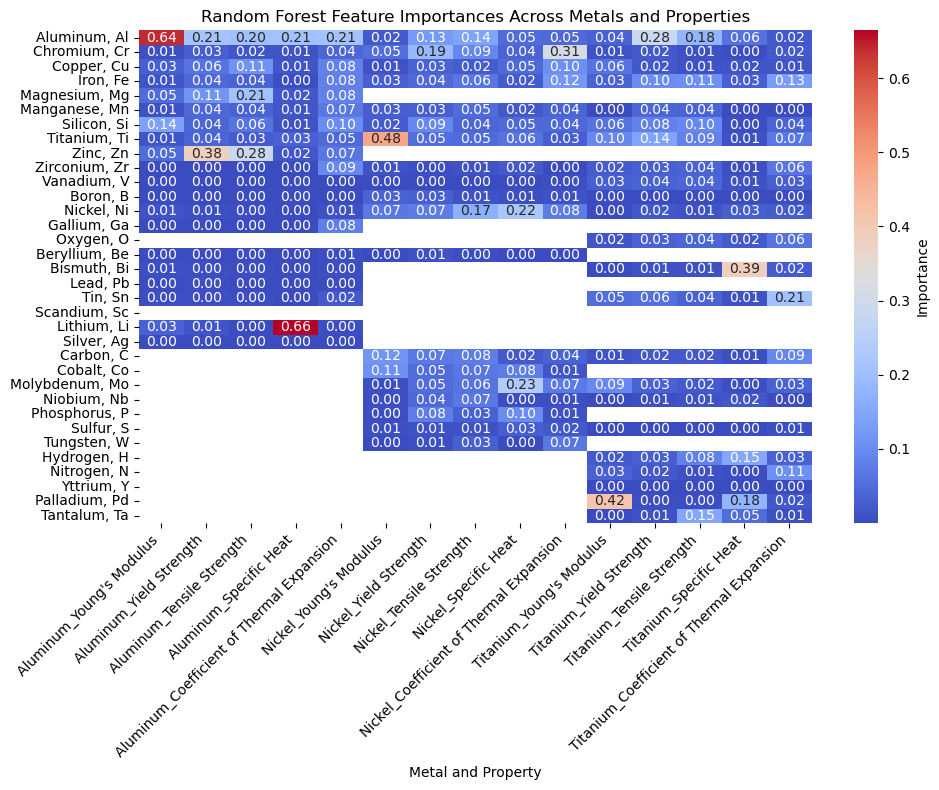

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'final_df' is the DataFrame from the previous code snippet
final_df[final_df==0]=np.NaN # true zeros are actual because the feature had no data, convert to NaN
# Create a heatmap
plt.figure(figsize=(10, 8))  # Set the figure size for better readability
sns.heatmap(final_df, annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={'label': 'Importance'})
plt.title('Random Forest Feature Importances Across Metals and Properties')
plt.xlabel('Metal and Property')
ytick_positions = np.arange(len(fi_df['Feature'])) + 0.5  # Shift positions slightly downwards
plt.yticks(ytick_positions, fi_df['Feature'])

plt.xticks(rotation=45, ha='right')  # Rotate x-labels for better readability
plt.yticks(rotation=0)  # Keep y-labels horizontal
plt.tight_layout()  # Adjust subplot parameters for a better fit into the figure area
plt.savefig("Images/Meta/MetalsandProperties")
# Show the plot
plt.show()

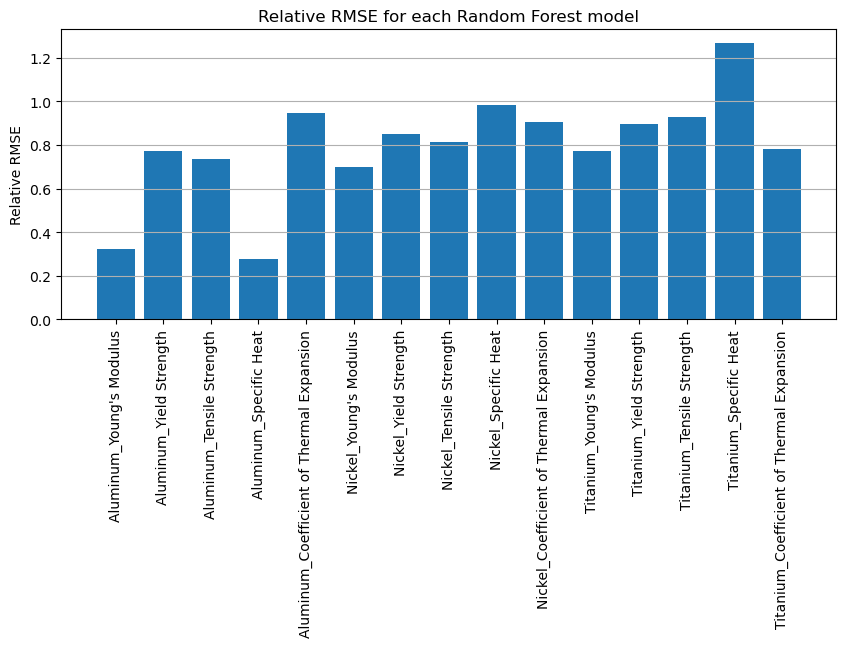

In [49]:
features = final_df.columns
plt.figure(figsize=(10, 5))
plt.bar(features, rf_mse)
plt.ylabel('Relative RMSE')
plt.xticks(rotation='vertical')  # Rotate x-axis labels for better readability
plt.title('Relative RMSE for each Random Forest model')
plt.grid(axis='y') 

# Adjust the bottom margin to make room for vertical x-axis labels
plt.subplots_adjust(bottom=0.3)  # Increase this value if labels are still cut off

# Save the figure with enough margin to include all elements, especially the labels
plt.savefig("Images/Meta/RandomForestModels.png", bbox_inches='tight')

# Display the plot
plt.show()

In [50]:
df.describe()

Young's Modulus  Yield Strength  Tensile Strength  Specific Heat  \
count       201.000000      201.000000        201.000000   2.010000e+02   
mean          0.092125       -0.102158         -0.063506   4.418798e-17   
std           0.868875        0.874612          0.853089   1.002497e+00   
min          -5.181945       -2.459420         -2.484536  -5.771853e+00   
25%          -0.101843       -0.273891         -0.221990  -2.321944e-01   
50%           0.222419        0.062025          0.102942   5.431620e-02   
75%           0.605216        0.357418          0.356129   1.999704e-01   
max           1.033073        1.860532          1.643757   4.423943e+00   

       Coefficient of Thermal Expansion  Aluminum, Al  Chromium, Cr  \
count                      2.010000e+02    201.000000    201.000000   
mean                       3.031296e-15      4.835625      2.363627   
std                        1.002497e+00      2.126965      2.958976   
min                       -3.285554e+00      0.000000      0.000000   
25%                       -6.824139e-01      3.000000      0.000000   
50%                       -2.322536e-01      5.931800      0.100000   
75%                        5.186173e-01      6.339500      5.748900   
max                        4.866242e+00      8.350000     11.000000   

       Copper, Cu    Iron, Fe  Magnesium, Mg  ...  Molybdenum, Mo  \
count  201.000000  201.000000          201.0  ...      201.000000   
mean     0.085436    0.401771            0.0  ...        2.064401   
std      0.213253    0.390165            0.0  ...        2.333874   
min      0.000000    0.000000            0.0  ...        0.000000   
25%      0.000000    0.250000            0.0  ...        0.355500   
50%      0.005000    0.336500            0.0  ...        1.854000   
75%      0.153095    0.379338            0.0  ...        2.683015   
max      2.000000    2.000000            0.0  ...       15.000000   

       Niobium, Nb  Phosphorus, P   Sulfur, S  Tungsten, W  Hydrogen, H  \
count   201.000000          201.0  201.000000        201.0   201.000000   
mean      0.067861            0.0    0.000358          0.0     0.010864   
std       0.344366            0.0    0.001699          0.0     0.012147   
min       0.000000            0.0    0.000000          0.0     0.000000   
25%       0.000000            0.0    0.000000          0.0     0.005037   
50%       0.000000            0.0    0.000000          0.0     0.013000   
75%       0.000000            0.0    0.000066          0.0     0.014955   
max       2.000000            0.0    0.010000          0.0     0.100000   

       Nitrogen, N  Yttrium, Y  Palladium, Pd  Tantalum, Ta  
count   201.000000  201.000000     201.000000    201.000000  
mean      0.070067    0.000249       0.003812      0.190927  
std       0.058856    0.001090       0.022568      2.123710  
min       0.000000    0.000000       0.000000      0.000000  
25%       0.040000    0.000000       0.000000      0.000000  
50%       0.050000    0.000000       0.000000      0.000000  
75%       0.146197    0.000000       0.000000      0.000100  
max       0.400000    0.005000       0.150000     30.000000  

[8 rows x 39 columns]

In [51]:
file_path = 'Combodf.csv'
corr_dict = {}
prev=None
metals = ['Aluminum', 'Nickel', 'Titanium']
# Property names corresponding to min_values and max_values
property_names = ['Young\'s Modulus', 'Yield Strength', 'Tensile Strength', 'Specific Heat', 'Coefficient of Thermal Expansion']
for metal in metals:
    df = pd.read_csv(file_path)
    df = df.rename(columns={"Niobium, Nb (Columbium, Cb)": "Niobium, Nb"}) # make this element name shorter to match length of others
    df = df[df['Metal Type'] == metal] # keep only this metal
    df = df.drop('Metal Type', axis=1)
    df = df.drop('Density', axis=1)
    # Calculate the correlation matrix
    corr_matrix = df.corr()

    for p_name in property_names:
        # Isolate the correlation of the target feature with other features
        target_corr = corr_matrix[p_name]
        for drop_p_name in property_names:
            target_corr = target_corr.drop(drop_p_name)
        corr_dict[metal+" "+target_corr.name] = target_corr.values
        if prev is not None: # double check that the elements are in the same order
            if target_corr.index != prev:
                print('error')
            prev = target_corr.index


In [52]:
corr_dict

{"Aluminum Young's Modulus": array([-0.76058763, -0.09339064,  0.44322277,  0.35321731, -0.07206661,
        -0.15033833,  0.70307309,  0.14744414,  0.0045561 ,  0.18078988,
        -0.10021596, -0.11586391,  0.27754625, -0.15365141,         nan,
         0.02288574,  0.05930997,  0.02944882, -0.00337447,  0.01299488,
         0.21966729, -0.0040151 ,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan]),
 'Aluminum Yield Strength': array([-0.37596637,  0.13149194,  0.3060069 , -0.18814191,  0.20387055,
        -0.16491044, -0.00455084,  0.01625744,  0.44774163,  0.26621226,
        -0.11776818, -0.12939474,  0.00167309, -0.17115318,         nan,
         0.00183546,  0.1096094 ,  0.03984346, -0.08555966,  0.02660237,
         0.14956809,  0.06224203,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
       

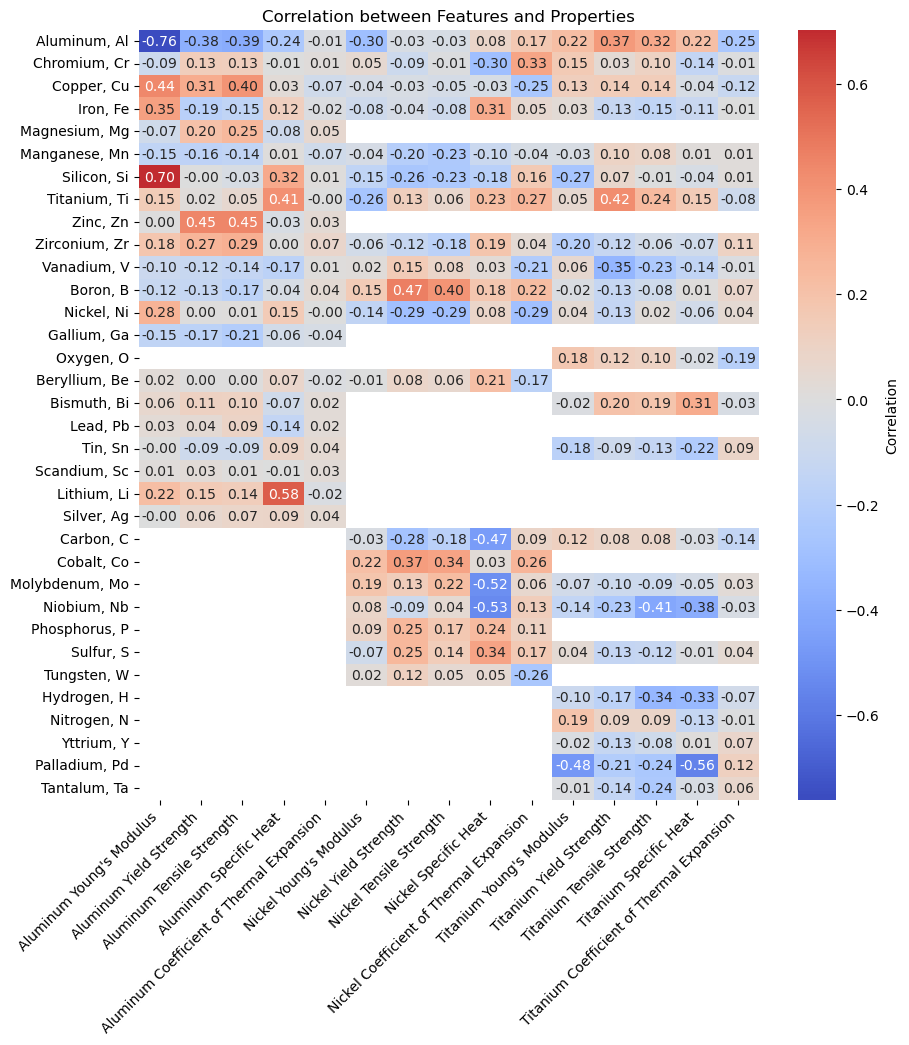

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


plt.figure(figsize=(10, 10))
plt.title('Correlation between Features and Properties')
sns.heatmap(corr_df, annot=True, cmap='coolwarm', center=0, fmt=".2f", cbar_kws={'label': 'Correlation'})
plt.yticks( np.arange(0.5,len(target_corr.index)+.5),target_corr.index)
plt.yticks(rotation=0)  # Keep y-labels horizontal
plt.xticks(rotation=45, ha='right')  # Rotate x-labels for better readability
plt.savefig("Images/Meta/CorrelationFeaturesProperties")
plt.show()

In [161]:
# Paths to all uploaded files
file_paths_2v = {
    'Aluminum_modulus': 'Al_model_data/mse_scores_with_aluminum_2_features_modulus.csv',
    'Aluminum_yield': 'Al_model_data/mse_scores_with_aluminum_2_features_yield.csv',
    'Aluminum_tensile': 'Al_model_data/mse_scores_with_aluminum_2_features_tensile.csv',
    'Aluminum_heat': 'Al_model_data/mse_scores_with_aluminum_2_features_heat.csv',
    'Aluminum_COTE': 'Al_model_data/mse_scores_with_aluminum_2_features_COTE.csv',
    'Nickel_modulus': 'Ni_model_data/mse_scores_with_nickel_2_features_modulus.csv',
    'Nickel_yield': 'Ni_model_data/mse_scores_with_nickel_2_features_yield.csv',
    'Nickel_tensile': 'Ni_model_data/mse_scores_with_nickel_2_features_tensile.csv',
    'Nickel_heat': 'Ni_model_data/mse_scores_with_nickel_2_features_heat.csv',
    'Nickel_COTE': 'Ni_model_data/mse_scores_with_nickel_2_features_COTE.csv',
    'Titanium_modulus': 'Ti_model_data/mse_scores_with_titanium_2_features_modulus.csv',
    'Titanium_yield': 'Ti_model_data/mse_scores_with_titanium_2_features_yield.csv',
    'Titanium_tensile': 'Ti_model_data/mse_scores_with_titanium_2_features_tensile.csv',
    'Titanium_heat': 'Ti_model_data/mse_scores_with_titanium_2_features_heat.csv',
    'Titanium_COTE': 'Ti_model_data/mse_scores_with_titanium_2_features_thermalE.csv'
}

file_paths_3v = {
    'Aluminum_modulus': 'Al_model_data/mse_scores_with_aluminum_3_features_modulus.csv',
    'Aluminum_yield': 'Al_model_data/mse_scores_with_aluminum_3_features_yield.csv',
    'Aluminum_tensile': 'Al_model_data/mse_scores_with_aluminum_3_features_tensile.csv',
    'Aluminum_heat': 'Al_model_data/mse_scores_with_aluminum_3_features_heat.csv',
    'Aluminum_COTE': 'Al_model_data/mse_scores_with_aluminum_3_features_COTE.csv',
    'Nickel_modulus': 'Ni_model_data/mse_scores_with_nickel_3_features_modulus.csv',
    'Nickel_yield': 'Ni_model_data/mse_scores_with_nickel_3_features_yield.csv',
    'Nickel_tensile': 'Ni_model_data/mse_scores_with_nickel_3_features_tensile.csv',
    'Nickel_heat': 'Ni_model_data/mse_scores_with_nickel_3_features_heat.csv',
    'Nickel_COTE': 'Ni_model_data/mse_scores_with_nickel_3_features_COTE.csv',
    'Titanium_modulus': 'Ti_model_data/mse_scores_with_titanium_3_features_modulus.csv',
    'Titanium_yield': 'Ti_model_data/mse_scores_with_titanium_3_features_yield.csv',
    'Titanium_tensile': 'Ti_model_data/mse_scores_with_titanium_3_features_tensile.csv',
    'Titanium_heat': 'Ti_model_data/mse_scores_with_titanium_3_features_heat.csv',
    'Titanium_COTE': 'Ti_model_data/mse_scores_with_titanium_3_features_thermalE.csv'
}


# Function to find the best-performing combinations
def find_best_combinations(file_paths):
    best_combinations = {}
    for key, path in file_paths.items():
        data = pd.read_csv(path)
        best_combinations[key] = data.loc[data['MSE'].idxmin()]
    return best_combinations

# Get best combinations for 2-variable and 3-variable models
best_combinations_2v = find_best_combinations(file_paths_2v)
best_combinations_3v = find_best_combinations(file_paths_3v)

best_combinations_2v, best_combinations_3v


({'Aluminum_modulus': Combination    ('Silicon, Si', 'Aluminum, Al')
  MSE                                    0.36651
  Name: 0, dtype: object,
  'Aluminum_yield': Combination    ('Titanium, Ti', 'Aluminum, Al')
  MSE                                    0.408951
  Name: 7, dtype: object,
  'Aluminum_tensile': Combination    ('Iron, Fe', 'Aluminum, Al')
  MSE                                0.368956
  Name: 2, dtype: object,
  'Aluminum_heat': Combination    ('Lead, Pb', 'Aluminum, Al')
  MSE                                0.719781
  Name: 14, dtype: object,
  'Aluminum_COTE': Combination    ('Lead, Pb', 'Aluminum, Al')
  MSE                                0.567225
  Name: 14, dtype: object,
  'Nickel_modulus': Combination    ('Molybdenum, Mo', 'Nickel, Ni')
  MSE                                     0.33895
  Name: 4, dtype: object,
  'Nickel_yield': Combination    ('Niobium, Nb (Columbium, Cb)', 'Nickel, Ni')
  MSE                                                 0.522221
  Name: 5, dtype

In [162]:
# Extract features from combinations
from itertools import chain

# Helper function to parse combinations from string
def parse_combinations(combination_series):
    return [tuple(eval(comb)) for comb in combination_series]

# Gather all feature combinations
features_2v = chain.from_iterable(parse_combinations(pd.Series({k: v['Combination'] for k, v in best_combinations_2v.items()})))
features_3v = chain.from_iterable(parse_combinations(pd.Series({k: v['Combination'] for k, v in best_combinations_3v.items()})))

# Count occurrences of each feature in 2V and 3V models
from collections import Counter

counter_2v = Counter(features_2v)
counter_3v = Counter(features_3v)

# Create matrix of selections
all_features = set(counter_2v.keys()).union(set(counter_3v.keys()))
feature_matrix = {feature: [counter_2v.get(feature, 0), counter_3v.get(feature, 0)] for feature in all_features}

# Convert counts to the encoding (0, 1, 2, 3)
for feature, counts in feature_matrix.items():
    encode = (1 if counts[0] > 0 else 0) + (2 if counts[1] > 0 else 0)
    feature_matrix[feature] = encode

# Create a DataFrame from the matrix
import numpy as np
features_df = pd.DataFrame(list(feature_matrix.items()), columns=['Feature', 'Selection Code']).sort_values('Feature')
features_df.set_index('Feature', inplace=True)
features_df.T # Transpose for desired format


Feature         Aluminum, Al  Boron, B  Chromium, Cr  Cobalt, Co  Iron, Fe  \
Selection Code             3         2             3           3         3   

Feature         Lead, Pb  Lithium, Li  Magnesium, Mg  Manganese, Mn  \
Selection Code         1            2              2              2   

Feature         Molybdenum, Mo  Nickel, Ni  Niobium, Nb (Columbium, Cb)  \
Selection Code               3           3                            1   

Feature         Palladium, Pd  Phosphorus, P  Silicon, Si  Tin, Sn  \
Selection Code              2              2            3        1   

Feature         Titanium, Ti  Zinc, Zn  Zirconium, Zr  
Selection Code             3         2              2

/var/folders/23/prfh1l6n7pxb55snfqs3862m0000gn/T/ipykernel_50208/2174556882.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(properties, rotation=45)
/var/folders/23/prfh1l6n7pxb55snfqs3862m0000gn/T/ipykernel_50208/2174556882.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(properties, rotation=45)


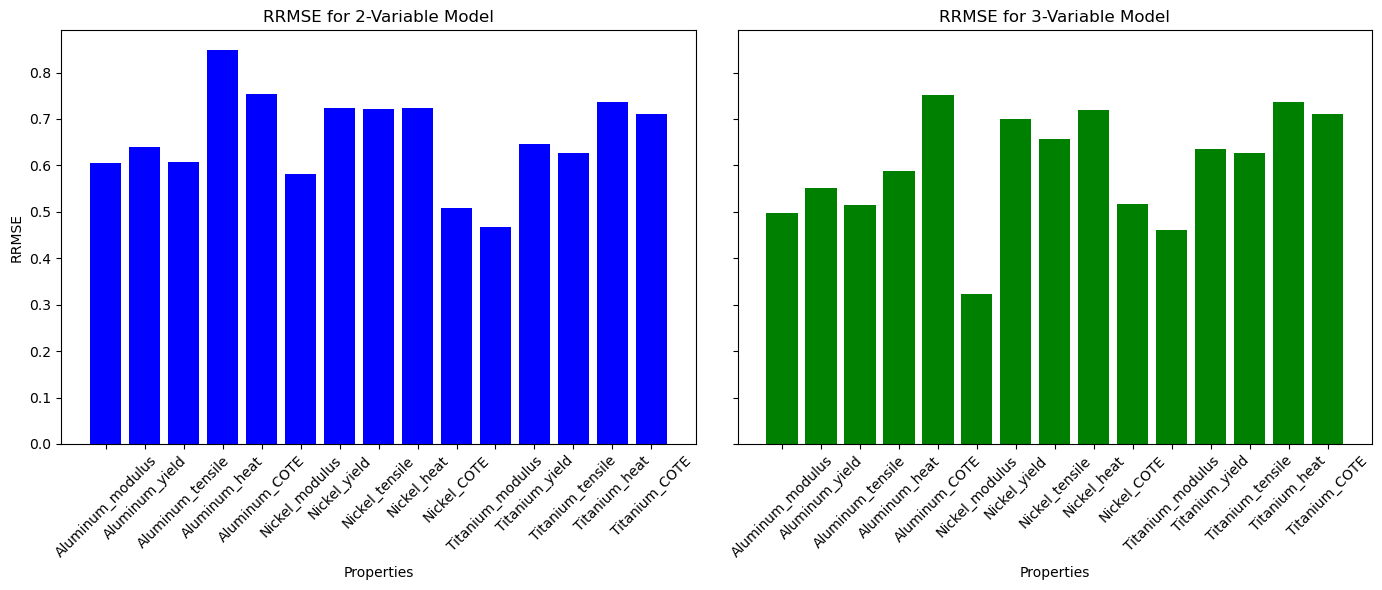

/var/folders/23/prfh1l6n7pxb55snfqs3862m0000gn/T/ipykernel_50208/2174556882.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(properties, rotation=45, ha='right')
/var/folders/23/prfh1l6n7pxb55snfqs3862m0000gn/T/ipykernel_50208/2174556882.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(properties, rotation=45, ha='right')


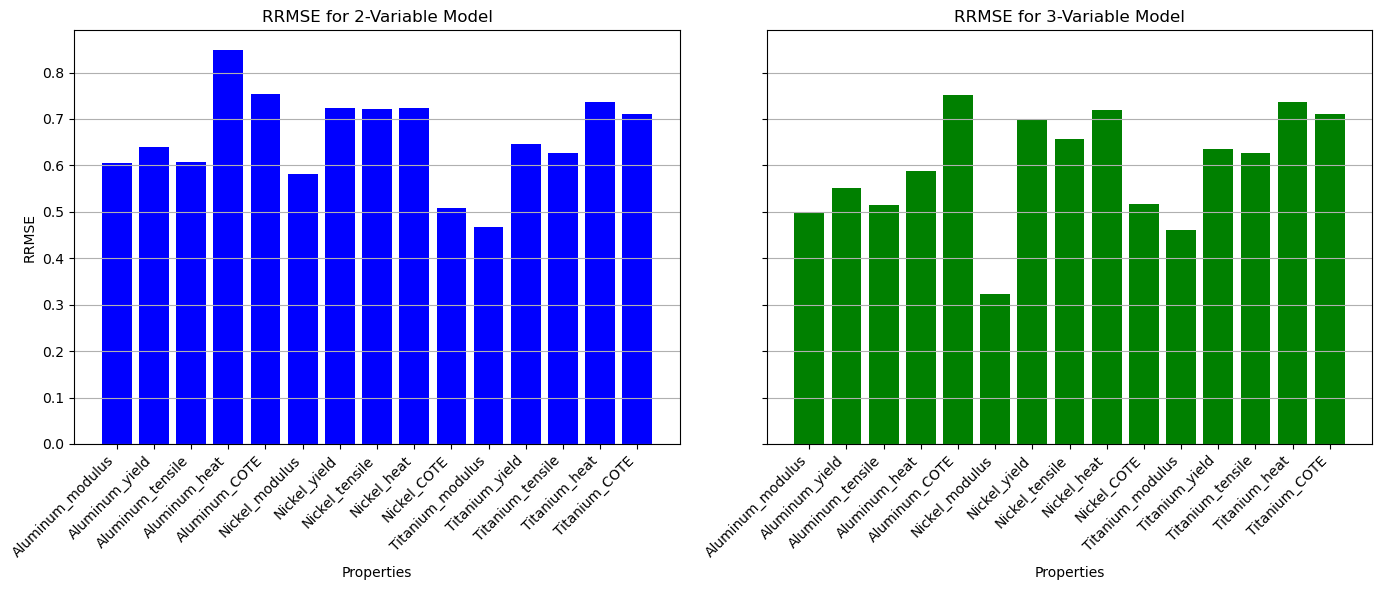

In [163]:
import matplotlib.pyplot as plt

# Compute RRMSE from MSE by taking the square root (as a simple approach to demonstrate)
# Typically RRMSE is relative to some benchmark which isn't provided, so we'll assume RRMSE = sqrt(MSE) for visualization
properties = list(best_combinations_2v.keys())
rrmse_2v = [best_combinations_2v[prop]['MSE']**0.5 for prop in properties]
rrmse_3v = [best_combinations_3v[prop]['MSE']**0.5 for prop in properties]

# Plotting the RRMSE for 2-variable and 3-variable models
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

ax[0].bar(properties, rrmse_2v, color='blue')
ax[0].set_title('RRMSE for 2-Variable Model')
ax[0].set_ylabel('RRMSE')
ax[0].set_xlabel('Properties')
ax[0].set_xticklabels(properties, rotation=45)

ax[1].bar(properties, rrmse_3v, color='green')
ax[1].set_title('RRMSE for 3-Variable Model')
ax[1].set_xlabel('Properties')
ax[1].set_xticklabels(properties, rotation=45)

plt.tight_layout()
plt.show()
import matplotlib.pyplot as plt

# Compute RRMSE from MSE by taking the square root (as a simple approach to demonstrate)
# Typically RRMSE is relative to some benchmark which isn't provided, so we'll assume RRMSE = sqrt(MSE) for visualization
properties = list(best_combinations_2v.keys())
rrmse_2v = [best_combinations_2v[prop]['MSE']**0.5 for prop in properties]
rrmse_3v = [best_combinations_3v[prop]['MSE']**0.5 for prop in properties]

# Plotting the RRMSE for 2-variable and 3-variable models
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)


# Plot for the first subplot
ax[0].bar(properties, rrmse_2v, color='blue')
ax[0].set_title('RRMSE for 2-Variable Model')
ax[0].set_ylabel('RRMSE')
ax[0].set_xlabel('Properties')
ax[0].set_xticklabels(properties, rotation=45, ha='right')
ax[0].grid(axis='y')  # Add gridlines along the y-axis

# Plot for the second subplot
ax[1].bar(properties, rrmse_3v, color='green')
ax[1].set_title('RRMSE for 3-Variable Model')
ax[1].set_xlabel('Properties')
ax[1].set_xticklabels(properties, rotation=45, ha='right')
ax[1].grid(axis='y')  # Add gridlines along the y-axis

plt.tight_layout()
plt.show()



In [165]:
# Creating a table that includes all elements as rows and properties as columns
# Initialize an empty DataFrame with all features as index and properties as columns
property_matrix = pd.DataFrame(index=list(all_features), columns=properties, data=0)

# Update the DataFrame with encoded values
for prop in properties:
    combination_2v = set(parse_combinations([best_combinations_2v[prop]['Combination']])[0])
    combination_3v = set(parse_combinations([best_combinations_3v[prop]['Combination']])[0])
    for feature in combination_2v:
        property_matrix.at[feature, prop] = 1  # Mark feature selected by 2V
    for feature in combination_3v:
        property_matrix.at[feature, prop] += 2  # Add 2 if selected by 3V, making it 3 if already selected by 2V

property_matrix.T  # Transpose for the requested format (features as rows)


Silicon, Si  Magnesium, Mg  Boron, B  Manganese, Mn  \
Aluminum_modulus            3              0         0              0   
Aluminum_yield              0              0         0              2   
Aluminum_tensile            0              2         0              0   
Aluminum_heat               0              2         0              0   
Aluminum_COTE               0              2         0              0   
Nickel_modulus              0              0         2              0   
Nickel_yield                0              0         0              0   
Nickel_tensile              0              0         0              2   
Nickel_heat                 0              0         0              0   
Nickel_COTE                 2              0         0              0   
Titanium_modulus            2              0         0              0   
Titanium_yield              0              0         0              0   
Titanium_tensile            2              0         0              0   
Titanium_heat               0              0         0              0   
Titanium_COTE               0              0         0              0   

                  Phosphorus, P  Chromium, Cr  Molybdenum, Mo  Tin, Sn  \
Aluminum_modulus              0             0               0        0   
Aluminum_yield                0             0               0        0   
Aluminum_tensile              0             0               0        0   
Aluminum_heat                 0             0               0        0   
Aluminum_COTE                 0             0               0        0   
Nickel_modulus                0             0               1        0   
Nickel_yield                  0             0               0        0   
Nickel_tensile                0             0               0        0   
Nickel_heat                   2             1               0        0   
Nickel_COTE                   0             2               0        0   
Titanium_modulus              0             0               1        0   
Titanium_yield                0             1               0        0   
Titanium_tensile              0             0               1        0   
Titanium_heat                 0             3               0        0   
Titanium_COTE                 0             2               2        1   

                  Zinc, Zn  Palladium, Pd  Cobalt, Co  Nickel, Ni  Lead, Pb  \
Aluminum_modulus         2              0           0           0         0   
Aluminum_yield           2              0           0           0         0   
Aluminum_tensile         2              0           0           0         0   
Aluminum_heat            0              0           0           0         1   
Aluminum_COTE            2              0           0           0         1   
Nickel_modulus           0              0           2           3         0   
Nickel_yield             0              0           2           3         0   
Nickel_tensile           0              0           2           3         0   
Nickel_heat              0              0           2           3         0   
Nickel_COTE              0              0           1           3         0   
Titanium_modulus         0              0           0           0         0   
Titanium_yield           0              0           0           0         0   
Titanium_tensile         0              2           0           0         0   
Titanium_heat            0              0           0           0         0   
Titanium_COTE            0              0           0           0         0   

                  Aluminum, Al  Niobium, Nb (Columbium, Cb)  Iron, Fe  \
Aluminum_modulus             3                            0         0   
Aluminum_yield               3                            0         0   
Aluminum_tensile             3                            0         1   
Aluminum_heat                3                            0         0   
Aluminum_COTE                3    

In [166]:
# List of all elements provided
all_elements = [
    "Aluminum, Al", "Chromium, Cr", "Copper, Cu", "Iron, Fe", "Magnesium, Mg",
    "Manganese, Mn", "Silicon, Si", "Titanium, Ti", "Zinc, Zn", "Zirconium, Zr",
    "Vanadium, V", "Boron, B", "Nickel, Ni", "Gallium, Ga", "Oxygen, O",
    "Beryllium, Be", "Bismuth, Bi", "Lead, Pb", "Tin, Sn", "Scandium, Sc",
    "Lithium, Li", "Silver, Ag", "Carbon, C", "Cobalt, Co", "Molybdenum, Mo",
    "Niobium, Nb", "Phosphorus, P", "Sulfur, S", "Tungsten, W", "Hydrogen, H",
    "Nitrogen, N", "Yttrium, Y", "Palladium, Pd", "Tantalum, Ta"
]

# Create a new DataFrame initialized with zeros
full_property_matrix = pd.DataFrame(index=all_elements, columns=properties, data=0)

# Update the DataFrame using the previously created property_matrix
for feature in property_matrix.index:
    if feature in full_property_matrix.index:
        full_property_matrix.loc[feature] = property_matrix.loc[feature]

full_property_matrix.T  # Transpose for the requested format (features as rows)


Aluminum, Al  Chromium, Cr  Copper, Cu  Iron, Fe  \
Aluminum_modulus             3             0           0         0   
Aluminum_yield               3             0           0         0   
Aluminum_tensile             3             0           0         1   
Aluminum_heat                3             0           0         0   
Aluminum_COTE                3             0           0         0   
Nickel_modulus               0             0           0         0   
Nickel_yield                 0             0           0         0   
Nickel_tensile               0             0           0         0   
Nickel_heat                  0             1           0         0   
Nickel_COTE                  0             2           0         0   
Titanium_modulus             2             0           0         0   
Titanium_yield               0             1           0         2   
Titanium_tensile             0             0           0         0   
Titanium_heat                0             3           0         0   
Titanium_COTE                0             2           0         0   

                  Magnesium, Mg  Manganese, Mn  Silicon, Si  Titanium, Ti  \
Aluminum_modulus              0              0            3             0   
Aluminum_yield                0              2            0             1   
Aluminum_tensile              2              0            0             0   
Aluminum_heat                 2              0            0             0   
Aluminum_COTE                 2              0            0             0   
Nickel_modulus                0              0            0             0   
Nickel_yield                  0              0            0             2   
Nickel_tensile                0              2            0             0   
Nickel_heat                   0              0            0             0   
Nickel_COTE                   0              0            2             0   
Titanium_modulus              0              0            2             3   
Titanium_yield                0              0            0             3   
Titanium_tensile              0              0            2             3   
Titanium_heat                 0              0            0             3   
Titanium_COTE                 0              0            0             3   

                  Zinc, Zn  Zirconium, Zr  ...  Molybdenum, Mo  Niobium, Nb  \
Aluminum_modulus         2              0  ...               0            0   
Aluminum_yield           2              0  ...               0            0   
Aluminum_tensile         2              0  ...               0            0   
Aluminum_heat            0              0  ...               0            0   
Aluminum_COTE            2              0  ...               0            0   
Nickel_modulus           0              0  ...               1            0   
Nickel_yield             0              0  ...               0            0   
Nickel_tensile           0              0  ...               0            0   
Nickel_heat              0              0  ...               0            0   
Nickel_COTE              0              0  ...               0            0   
Titanium_modulus         0              0  ...               1            0   
Titanium_yield           0              2  ...               0            0   
Titanium_tensile         0              0  ...               1            0   
Titanium_heat            0              2  ...               0            0   
Titanium_COTE            0              0  ...               2            0   

                  Phosphorus, P  Sulfur, S  Tungsten, W  Hydrogen, H  \
Aluminum_modulus              0          0            0            0   
Aluminum_yield                0          0            0            0   
Aluminum_tensile              0          0            0            0   
Aluminum_heat                 0          0            0            0   
Aluminum_COTE                 0        

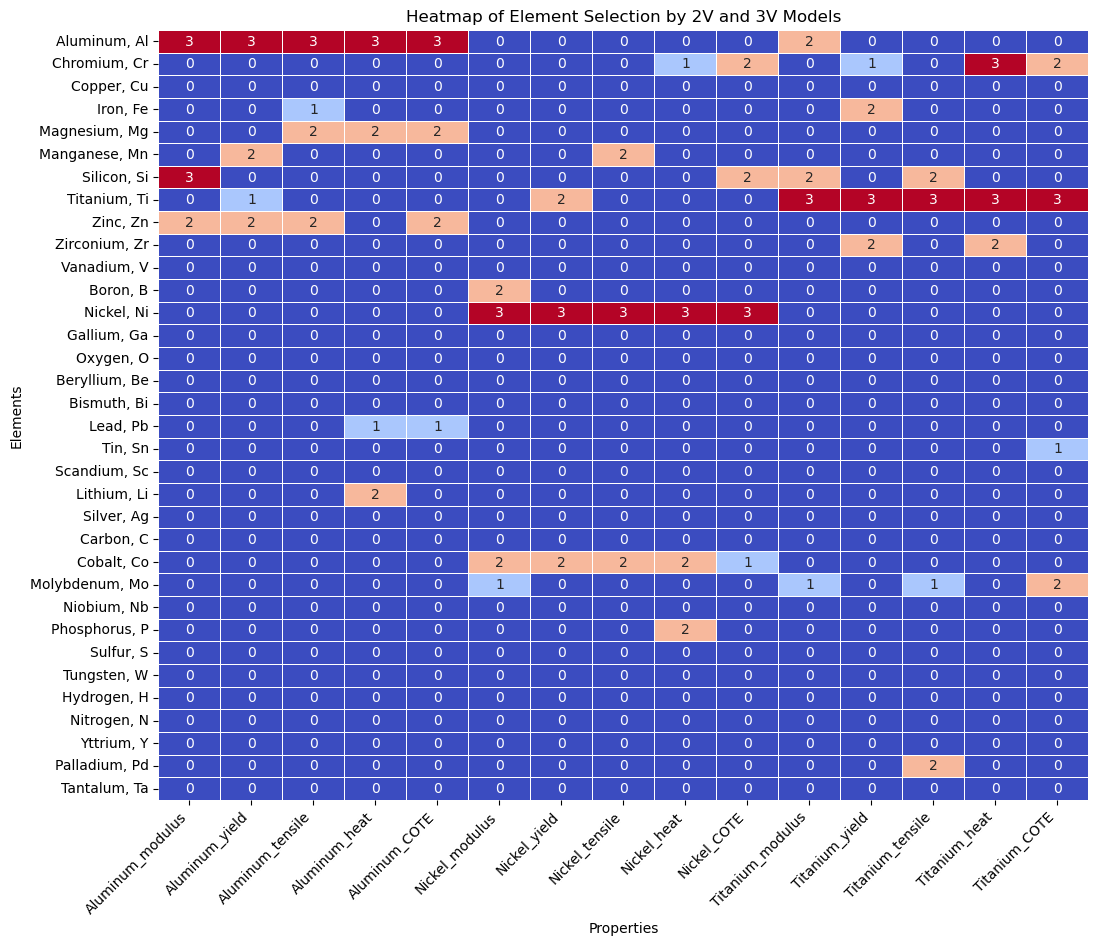

In [170]:
plt.figure(figsize=(12, 10))
sns.heatmap(full_property_matrix, annot=True, cmap="coolwarm", fmt="d", linewidths=.5, cbar=False)
plt.title('Heatmap of Element Selection by 2V and 3V Models')
plt.xlabel('Properties')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Elements')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Compute RRMSE from MSE by taking the square root (as a simple approach to demonstrate)
# Typically RRMSE is relative to some benchmark which isn't provided, so we'll assume RRMSE = sqrt(MSE) for visualization
properties = list(best_combinations_2v.keys())
rrmse_2v = [best_combinations_2v[prop]['MSE']**0.5 for prop in properties]
rrmse_3v = [best_combinations_3v[prop]['MSE']**0.5 for prop in properties]

# Plotting the RRMSE for 2-variable and 3-variable models
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

ax[0].bar(properties, rrmse_2v, color='blue')
ax[0].set_title('RRMSE for 2-Variable Model')
ax[0].set_ylabel('RRMSE')
ax[0].set_xlabel('Properties')
ax[0].set_xticklabels(properties, rotation=45)

ax[1].bar(properties, rrmse_3v, color='green')
ax[1].set_title('RRMSE for 3-Variable Model')
ax[1].set_xlabel('Properties')
ax[1].set_xticklabels(properties, rotation=45)

plt.tight_layout()
plt.show()

In [94]:
# Function to extract numeric values (assuming the function needs to handle string or mixed data types)
def extract_numeric(x):
    try:
        return pd.to_numeric(x)
    except ValueError:
        return np.nan

# Update column name for consistency
df = df.rename(columns={"Niobium, Nb (Columbium, Cb)": "Niobium, Nb"})

# Apply extract_numeric to the specified property columns
property_columns = ['Young\'s Modulus', 'Yield Strength', 'Tensile Strength', 'Specific Heat', 'Coefficient of Thermal Expansion']
for col in property_columns:
    df[col] = df[col].apply(extract_numeric)

df.head()

Young's Modulus  Yield Strength  Tensile Strength  Specific Heat  \
654         0.222419       -0.003330         -0.011765       0.199970   
655        -0.642280        0.237168          0.303573       0.199970   
656         0.438593       -0.075479         -0.024904       0.507010   
657        -0.966541       -0.228797         -0.300824      -0.091338   
658         0.492637        0.718165          0.553215       0.199970   

     Coefficient of Thermal Expansion  Aluminum, Al  Chromium, Cr  Copper, Cu  \
654                          2.420703           3.4           0.0         0.0   
655                         -0.840015           3.0           0.0         0.0   
656                         -0.840015           0.0           0.0         0.0   
657                          0.693337           2.7           0.0         0.0   
658                          1.605523           3.0           0.0         0.0   

     Iron, Fe  Magnesium, Mg  ...  Molybdenum, Mo  Niobium, Nb  Phosphorus, P  \
654      1.60            0.0  ...             0.0          0.0            0.0   
655      2.00            0.0  ...             8.0          0.0            0.0   
656      0.35            0.0  ...            15.0          0.0            0.0   
657      0.20            0.0  ...             0.0          0.0            0.0   
658      0.00            0.0  ...             0.0          0.0            0.0   

     Sulfur, S  Tungsten, W  Hydrogen, H  Nitrogen, N  Yttrium, Y  \
654       0.00          0.0        0.015         0.05       0.000   
655       0.01          0.0        0.015         0.00       0.000   
656       0.00          0.0        0.020         0.05       0.000   
657       0.00          0.0        0.015         0.05       0.005   
658       0.00          0.0        0.000         0.00       0.000   

     Palladium, Pd  Tantalum, Ta  
654            0.0           0.0  
655            0.0           0.0  
656            0.0           0.0  
657            0.0           0.0  
658            0.0           0.0  

[5 rows x 39 columns]

In [144]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.neural_network import MLPRegressor  # Make sure to import MLPRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Load the data
file_path = 'Combodf.csv'  # ensure this path is correct
df = pd.read_csv(file_path)
df = df.rename(columns={"Niobium, Nb (Columbium, Cb)": "Niobium, Nb"})  # Rename for consistency

# Define the metals and property names
metals = ['Aluminum', 'Nickel', 'Titanium']
property_names = ['Young\'s Modulus', 'Yield Strength', 'Tensile Strength', 'Specific Heat', 'Coefficient of Thermal Expansion']

# Placeholder for storing results
feature_importance_dfs = []
rrmse_results = []
selected_features_summary = []

# Configuration for the MLPRegressor
best_layers = (3, 3, 3)
best_max_iter = 4000

# Loop over each metal and property to train models and extract features
for metal in metals:
    for p_name in property_names:
        # Filter by metal type and drop the 'Density' column
        metal_df = df[df['Metal Type'] == metal].drop(['Metal Type', 'Density'], axis=1)

        # Ensure data is clean for model input
        metal_df = metal_df.dropna(subset=[p_name])

        # Features and target
        X = metal_df.drop(property_names, axis=1)
        y = metal_df[p_name]

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Random Forest Model for feature selection
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)
        
        # Calculate feature importance and select top features
        feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf.feature_importances_})
        sorted_features = feature_importances.sort_values(by='Importance', ascending=False).head(10)
        
        # Include metal specific feature if not in top features
        metal_column = metal + ', ' + metal[:2]
        if metal_column not in sorted_features['Feature'].values:
            metal_feature = feature_importances[feature_importances['Feature'] == metal_column]
            sorted_features = pd.concat([sorted_features.head(9), metal_feature])
        
        # Keep the features for the bagging model
        selected_features = sorted_features['Feature'].values
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]
        
        # Bagging MLP model training
        huber = HuberRegressor()
        best_bagging_model = BaggingRegressor(base_estimator=huber, n_estimators=10, random_state=42)
        best_bagging_model.fit(X_train_selected, y_train)
        best_preds = best_bagging_model.predict(X_test_selected)

# Calculate RRMSE as before
        rrmse = np.sqrt(mean_squared_error(y_test, best_preds)) / np.sqrt(np.mean((y_test - np.mean(y_train)) ** 2))

# Storing results remains the same
rrmse_results.append({'Metal': metal, 'Property': p_name, 'RRMSE': rrmse})

        # Calculate RRMSE
        rrmse = np.sqrt(mean_squared_error(y_test, best_preds)) / np.sqrt(np.mean((y_test - np.mean(y_train)) ** 2))
        
        # Store results
        rrmse_results.append({'Metal': metal, 'Property': p_name, 'RRMSE': rrmse})
        feature_importance_dfs.append(sorted_features)
        selected_features_summary.append({'Metal': metal, 'Property': p_name, 'Features': ', '.join(selected_features)})
        

# Display RRMSE results
print(rrmse_results)

InvalidParameterError: The 'base_estimator' parameter of BaggingRegressor must be an object implementing 'fit' and 'predict', a str among {'deprecated'} or None. Got (5, 5) instead.

In [145]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.neural_network import MLPRegressor  # Make sure to import MLPRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Load the data
file_path = 'Combodf.csv'  # ensure this path is correct
df = pd.read_csv(file_path)
df = df.rename(columns={"Niobium, Nb (Columbium, Cb)": "Niobium, Nb"})  # Rename for consistency

# Define the metals and property names
metals = ['Aluminum', 'Nickel', 'Titanium']
property_names = ['Young\'s Modulus', 'Yield Strength', 'Tensile Strength', 'Specific Heat', 'Coefficient of Thermal Expansion']

# Placeholder for storing results
feature_importance_dfs = []
rrmse_results = []
selected_features_summary = []

# Configuration for the MLPRegressor
best_layers = (8, 8)
best_max_iter = 4000

# Loop over each metal and property to train models and extract features
for metal in metals:
    for p_name in property_names:
        # Filter by metal type and drop the 'Density' column
        metal_df = df[df['Metal Type'] == metal].drop(['Metal Type', 'Density'], axis=1)

        # Ensure data is clean for model input
        metal_df = metal_df.dropna(subset=[p_name])

        # Features and target
        X = metal_df.drop(property_names, axis=1)
        y = metal_df[p_name]

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Random Forest Model for feature selection
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)
        
        # Calculate feature importance and select top features
        feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf.feature_importances_})
        sorted_features = feature_importances.sort_values(by='Importance', ascending=False).head(10)
        
        # Include metal specific feature if not in top features
        metal_column = metal + ', ' + metal[:2]
        if metal_column not in sorted_features['Feature'].values:
            metal_feature = feature_importances[feature_importances['Feature'] == metal_column]
            sorted_features = pd.concat([sorted_features.head(9), metal_feature])
        
        # Keep the features for the bagging model
        selected_features = sorted_features['Feature'].values
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]
        
        # Bagging MLP model training
        best_base_nn = MLPRegressor(hidden_layer_sizes=best_layers, activation='relu', solver='adam', max_iter=best_max_iter)
        best_bagging_model = BaggingRegressor(estimator=best_base_nn, n_estimators=10, random_state=42)
        best_bagging_model.fit(X_train_selected, y_train)
        best_preds = best_bagging_model.predict(X_test_selected)

        # Calculate RRMSE
        rrmse = np.sqrt(mean_squared_error(y_test, best_preds)) / np.sqrt(np.mean((y_test - np.mean(y_train)) ** 2))
        
        # Store results
        rrmse_results.append({'Metal': metal, 'Property': p_name, 'RRMSE': rrmse})
        feature_importance_dfs.append(sorted_features)
        selected_features_summary.append({'Metal': metal, 'Property': p_name, 'Features': ', '.join(selected_features)})
        

# Display RRMSE results
print(rrmse_results)

[{'Metal': 'Aluminum', 'Property': "Young's Modulus", 'RRMSE': 0.688257018109313}, {'Metal': 'Aluminum', 'Property': 'Yield Strength', 'RRMSE': 0.7887840065660696}, {'Metal': 'Aluminum', 'Property': 'Tensile Strength', 'RRMSE': 0.7198301997238513}, {'Metal': 'Aluminum', 'Property': 'Specific Heat', 'RRMSE': 0.7849058841231714}, {'Metal': 'Aluminum', 'Property': 'Coefficient of Thermal Expansion', 'RRMSE': 1.005051820616094}, {'Metal': 'Nickel', 'Property': "Young's Modulus", 'RRMSE': 0.867102200023852}, {'Metal': 'Nickel', 'Property': 'Yield Strength', 'RRMSE': 1.0851634729299375}, {'Metal': 'Nickel', 'Property': 'Tensile Strength', 'RRMSE': 0.7832196657770482}, {'Metal': 'Nickel', 'Property': 'Specific Heat', 'RRMSE': 0.7657573402338508}, {'Metal': 'Nickel', 'Property': 'Coefficient of Thermal Expansion', 'RRMSE': 0.8060672092754948}, {'Metal': 'Titanium', 'Property': "Young's Modulus", 'RRMSE': 0.9926526577834397}, {'Metal': 'Titanium', 'Property': 'Yield Strength', 'RRMSE': 0.937972

In [139]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Load the data
file_path = 'Combodf.csv'  # ensure this path is correct
df = pd.read_csv(file_path)
df = df.rename(columns={"Niobium, Nb (Columbium, Cb)": "Niobium, Nb"})  # Rename for consistency

# Define the metals and property names
metals = ['Aluminum', 'Nickel', 'Titanium']
property_names = ['Young\'s Modulus', 'Yield Strength', 'Tensile Strength', 'Specific Heat', 'Coefficient of Thermal Expansion']

# Configuration for the MLPRegressor
best_layers = [(20, 5), (20, 5), (20, 5), (20, 5), (20, 5), (20, 5), (8,), (20, 5), (20, 5), (5, 5), (8, 8), (5, 5), (8,), (10,10), (8,8)]
best_max_iter = 4000

# Placeholder for storing results
feature_importance_dfs = []
rrmse_results = []
selected_features_summary = []

# Ensure the length of best_layers matches the number of iterations
assert len(best_layers) == len(metals) * len(property_names)

# Counter for iterating through best_layers
layer_idx = 0

# Loop over each metal and property to train models and extract features
for metal in metals:
    for p_name in property_names:
        # Filter by metal type and drop the 'Density' column
        metal_df = df[df['Metal Type'] == metal].drop(['Metal Type', 'Density'], axis=1)

        # Ensure data is clean for model input
        metal_df = metal_df.dropna(subset=[p_name])

        # Features and target
        X = metal_df.drop(property_names, axis=1)
        y = metal_df[p_name]

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Random Forest Model for feature selection
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)
        
        # Calculate feature importance and select top features
        feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf.feature_importances_})
        sorted_features = feature_importances.sort_values(by='Importance', ascending=False).head(10)
        
        # Include metal specific feature if not in top features
        metal_column = metal + ', ' + metal[:2]
        if metal_column not in sorted_features['Feature'].values:
            metal_feature = feature_importances[feature_importances['Feature'] == metal_column]
            sorted_features = pd.concat([sorted_features.head(9), metal_feature])
        
        # Keep the features for the bagging model
        selected_features = sorted_features['Feature'].values
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]
        
        # Use the corresponding MLP configuration
        current_layers = best_layers[layer_idx]
        layer_idx += 1

        # Bagging MLP model training
        best_base_nn = MLPRegressor(hidden_layer_sizes=current_layers, activation='relu', solver='adam', max_iter=best_max_iter)
        best_bagging_model = BaggingRegressor(estimator=best_base_nn, n_estimators=10, random_state=42)
        best_bagging_model.fit(X_train_selected, y_train)
        best_preds = best_bagging_model.predict(X_test_selected)

        # Calculate RRMSE
        rrmse = np.sqrt(mean_squared_error(y_test, best_preds)) / np.sqrt(np.mean((y_test - np.mean(y_train)) ** 2))
        
        # Store results
        rrmse_results.append({'Metal': metal, 'Property': p_name, 'RRMSE': rrmse})
        feature_importance_dfs.append(sorted_features)
        selected_features_summary.append({'Metal': metal, 'Property': p_name, 'Features': ', '.join(selected_features)})
        

# Display RRMSE results
print(rrmse_results)


[{'Metal': 'Aluminum', 'Property': "Young's Modulus", 'RRMSE': 0.6474237304632238}, {'Metal': 'Aluminum', 'Property': 'Yield Strength', 'RRMSE': 0.8090816222489287}, {'Metal': 'Aluminum', 'Property': 'Tensile Strength', 'RRMSE': 0.7367756921291937}, {'Metal': 'Aluminum', 'Property': 'Specific Heat', 'RRMSE': 0.8187012522935198}, {'Metal': 'Aluminum', 'Property': 'Coefficient of Thermal Expansion', 'RRMSE': 1.009345270610996}, {'Metal': 'Nickel', 'Property': "Young's Modulus", 'RRMSE': 0.7975982004439552}, {'Metal': 'Nickel', 'Property': 'Yield Strength', 'RRMSE': 1.0696539203292563}, {'Metal': 'Nickel', 'Property': 'Tensile Strength', 'RRMSE': 1.2378425375604094}, {'Metal': 'Nickel', 'Property': 'Specific Heat', 'RRMSE': 0.89393024527502}, {'Metal': 'Nickel', 'Property': 'Coefficient of Thermal Expansion', 'RRMSE': 1.0492198908418469}, {'Metal': 'Titanium', 'Property': "Young's Modulus", 'RRMSE': 0.9926526577834397}, {'Metal': 'Titanium', 'Property': 'Yield Strength', 'RRMSE': 0.998113

In [130]:
# Display selected features for each property
print(selected_features_summary)

[{'Metal': 'Aluminum', 'Property': "Young's Modulus", 'Features': 'Aluminum, Al, Silicon, Si, Zinc, Zn, Copper, Cu, Magnesium, Mg, Lithium, Li, Iron, Fe, Manganese, Mn, Titanium, Ti, Nickel, Ni'}, {'Metal': 'Aluminum', 'Property': 'Yield Strength', 'Features': 'Copper, Cu, Zinc, Zn, Magnesium, Mg, Aluminum, Al, Iron, Fe, Titanium, Ti, Manganese, Mn, Silicon, Si, Chromium, Cr, Bismuth, Bi'}, {'Metal': 'Aluminum', 'Property': 'Tensile Strength', 'Features': 'Copper, Cu, Magnesium, Mg, Aluminum, Al, Zinc, Zn, Titanium, Ti, Silicon, Si, Iron, Fe, Manganese, Mn, Chromium, Cr, Nickel, Ni'}, {'Metal': 'Aluminum', 'Property': 'Specific Heat', 'Features': 'Lithium, Li, Titanium, Ti, Silicon, Si, Zinc, Zn, Copper, Cu, Aluminum, Al, Tin, Sn, Manganese, Mn, Magnesium, Mg, Silver, Ag'}, {'Metal': 'Aluminum', 'Property': 'Coefficient of Thermal Expansion', 'Features': 'Aluminum, Al, Copper, Cu, Magnesium, Mg, Silicon, Si, Iron, Fe, Manganese, Mn, Zirconium, Zr, Gallium, Ga, Zinc, Zn, Titanium, Ti'},

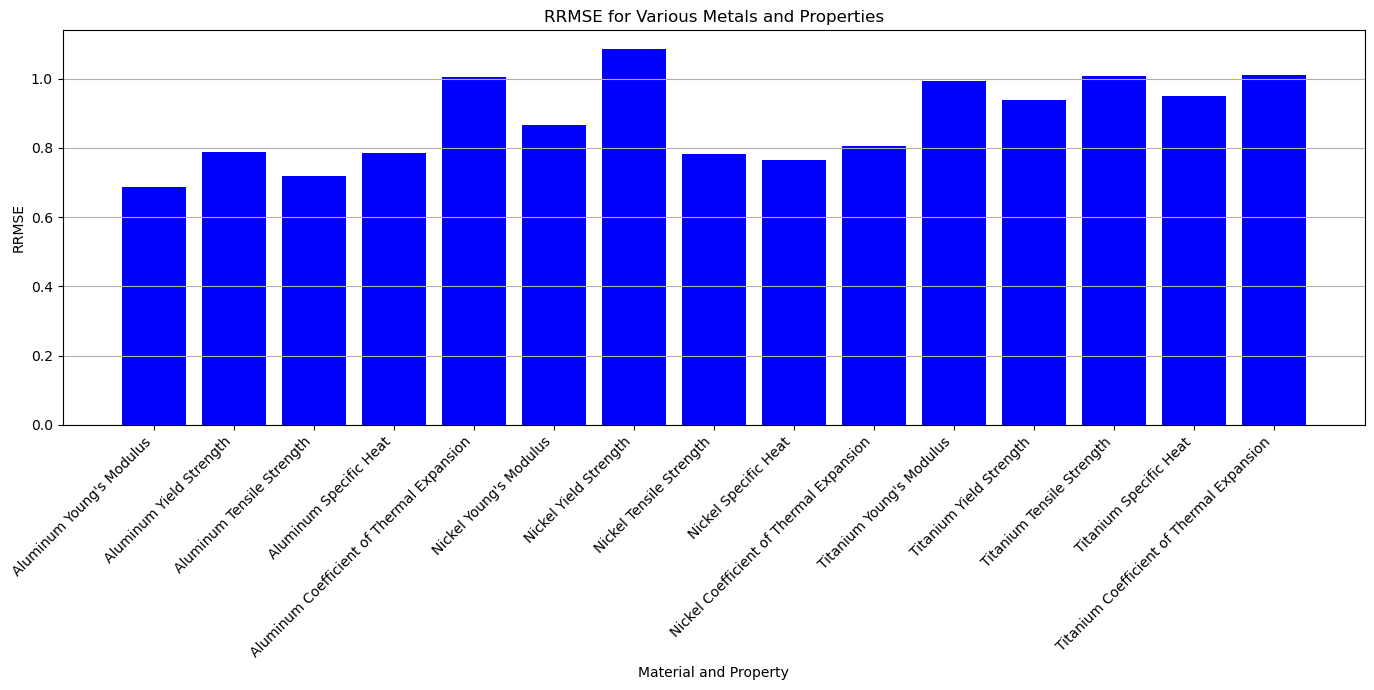

In [146]:
import matplotlib.pyplot as plt

# Create a DataFrame from the RRMSE results
rrmse_df = pd.DataFrame(rrmse_results)

# Prepare plot data
rrmse_df['Label'] = rrmse_df['Metal'] + ' ' + rrmse_df['Property']
rrmse_values = rrmse_df['RRMSE']
labels = rrmse_df['Label']

# Creating the bar chart
plt.figure(figsize=(14, 7))
plt.bar(labels, rrmse_values, color='blue')
plt.xlabel('Material and Property')
plt.ylabel('RRMSE')
plt.title('RRMSE for Various Metals and Properties')
plt.xticks(rotation=45, ha='right')  # Rotate labels to avoid overlap
plt.grid(axis='y') 
plt.tight_layout()  # Adjust layout to make room for label rotation

# Show the plot
plt.show()


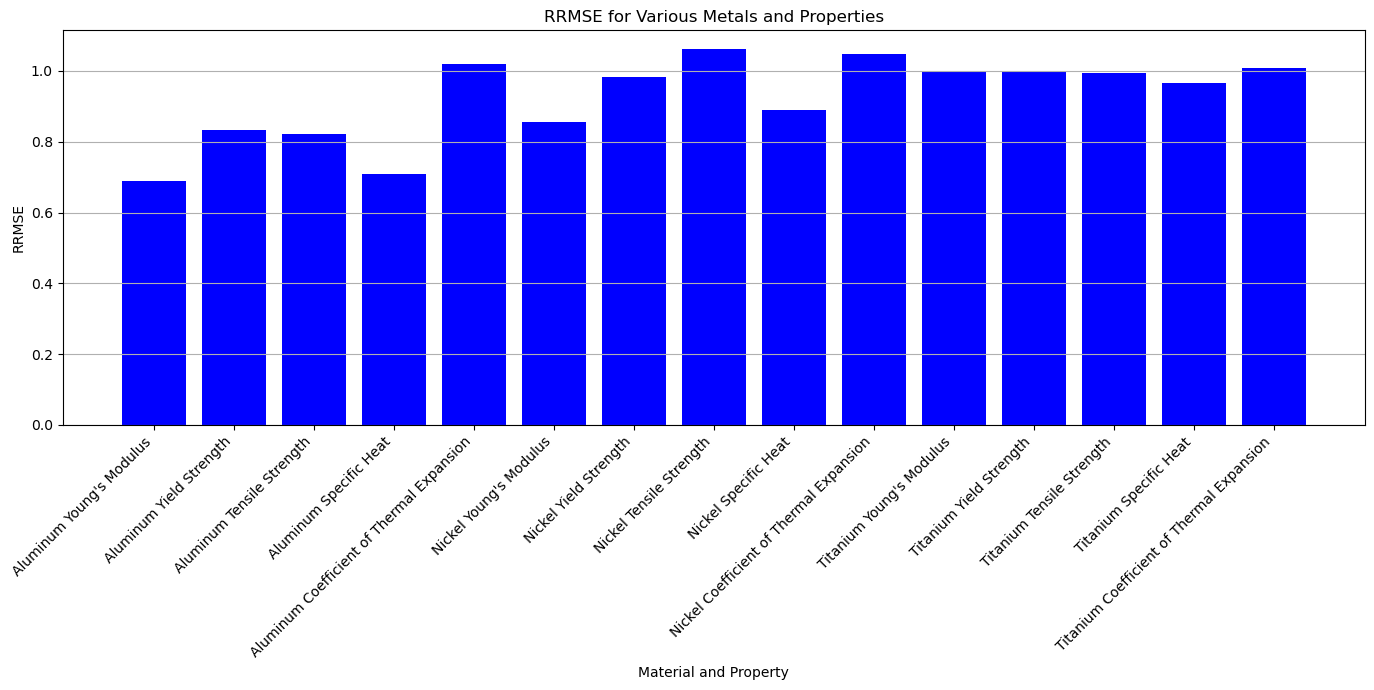

In [132]:
import matplotlib.pyplot as plt

# Create a DataFrame from the RRMSE results
rrmse_df = pd.DataFrame(rrmse_results)

# Prepare plot data
rrmse_df['Label'] = rrmse_df['Metal'] + ' ' + rrmse_df['Property']
rrmse_values = rrmse_df['RRMSE']
labels = rrmse_df['Label']

# Creating the bar chart
plt.figure(figsize=(14, 7))
plt.bar(labels, rrmse_values, color='blue')
plt.xlabel('Material and Property')
plt.ylabel('RRMSE')
plt.title('RRMSE for Various Metals and Properties')
plt.xticks(rotation=45, ha='right')  # Rotate labels to avoid overlap
plt.grid(axis='y') 
plt.tight_layout()  # Adjust layout to make room for label rotation

# Show the plot
plt.show()


In [128]:
import pandas as pd


# Extract unique elements and properties
elements = set()
properties = set()

for summary in selected_features_summary:
    properties.add(summary['Property'])
    elements.update(summary['Features'].split(', '))

# Create a DataFrame initialized with zeros
matrix = pd.DataFrame(0, index=elements, columns=properties)

# Populate the DataFrame with 1 where element is a top feature
for summary in selected_features_summary:
    for element in summary['Features'].split(', '):
        matrix.loc[element, summary['Property']] = 1

print(matrix)


ValueError: index cannot be a set

In [150]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import joblib 
import os

# Load the data
file_path = 'Combodf.csv'  # ensure this path is correct
df = pd.read_csv(file_path)
df = df.rename(columns={"Niobium, Nb (Columbium, Cb)": "Niobium, Nb"})  # Rename for consistency

# Define the metals and property names
metals = ['Aluminum', 'Nickel', 'Titanium']
property_names = ['Young\'s Modulus', 'Yield Strength', 'Tensile Strength', 'Specific Heat', 'Coefficient of Thermal Expansion']

# Placeholder for storing results and models
feature_importance_dfs = []
rrmse_results = []
selected_features_summary = []
models = {}  # Dictionary to store models

# Configuration for the MLPRegressor
best_layers = (8, 8)
best_max_iter = 4000

# Loop over each metal and property to train models and extract features
for metal in metals:
    for p_name in property_names:
        # Filter by metal type and drop the 'Density' column
        metal_df = df[df['Metal Type'] == metal].drop(['Metal Type', 'Density'], axis=1)

        # Ensure data is clean for model input
        metal_df = metal_df.dropna(subset=[p_name])

        # Features and target
        X = metal_df.drop(property_names, axis=1)
        y = metal_df[p_name]

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Random Forest Model for feature selection
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)
        
        # Calculate feature importance and select top features
        feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf.feature_importances_})
        sorted_features = feature_importances.sort_values(by='Importance', ascending=False).head(10)
        
        # Include metal specific feature if not in top features
        metal_column = metal + ', ' + metal[:2]
        if metal_column not in sorted_features['Feature'].values:
            metal_feature = feature_importances[feature_importances['Feature'] == metal_column]
            sorted_features = pd.concat([sorted_features.head(9), metal_feature])
        
        # Keep the features for the bagging model
        selected_features = sorted_features['Feature'].values
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]
        
        # Bagging MLP model training
        best_base_nn = MLPRegressor(hidden_layer_sizes=best_layers, activation='relu', solver='adam', max_iter=best_max_iter)
        best_bagging_model = BaggingRegressor(estimator=best_base_nn, n_estimators=10, random_state=42)
        best_bagging_model.fit(X_train_selected, y_train)
        models[(metal, p_name)] = best_bagging_model  # Store the trained model
        
        # Calculate RRMSE
        best_preds = best_bagging_model.predict(X_test_selected)
        rrmse = np.sqrt(mean_squared_error(y_test, best_preds)) / np.sqrt(np.mean((y_test - np.mean(y_train)) ** 2))
        
        # Store results
        rrmse_results.append({'Metal': metal, 'Property': p_name, 'RRMSE': rrmse})
        feature_importance_dfs.append(sorted_features)
        selected_features_summary.append({'Metal': metal, 'Property': p_name, 'Features': ', '.join(selected_features)})
        
# Optionally save models to disk
for key, model in models.items():
    # Define the directory and filename
    directory = "models"
    filename = f"{key[0]}_{key[1].replace(' ', '_')}_model.pkl"
    model_path = os.path.join(directory, filename)
    
    # Ensure the directory exists
    os.makedirs(directory, exist_ok=True)
    
    # Save the model
    joblib.dump(model, model_path)

# Display RRMSE results
print(rrmse_results)

[{'Metal': 'Aluminum', 'Property': "Young's Modulus", 'RRMSE': 0.688257018109313}, {'Metal': 'Aluminum', 'Property': 'Yield Strength', 'RRMSE': 0.7887840065660696}, {'Metal': 'Aluminum', 'Property': 'Tensile Strength', 'RRMSE': 0.7198301997238513}, {'Metal': 'Aluminum', 'Property': 'Specific Heat', 'RRMSE': 0.7849058841231714}, {'Metal': 'Aluminum', 'Property': 'Coefficient of Thermal Expansion', 'RRMSE': 1.005051820616094}, {'Metal': 'Nickel', 'Property': "Young's Modulus", 'RRMSE': 0.867102200023852}, {'Metal': 'Nickel', 'Property': 'Yield Strength', 'RRMSE': 1.0851634729299375}, {'Metal': 'Nickel', 'Property': 'Tensile Strength', 'RRMSE': 0.7832196657770482}, {'Metal': 'Nickel', 'Property': 'Specific Heat', 'RRMSE': 0.7657573402338508}, {'Metal': 'Nickel', 'Property': 'Coefficient of Thermal Expansion', 'RRMSE': 0.8060672092754948}, {'Metal': 'Titanium', 'Property': "Young's Modulus", 'RRMSE': 0.9926526577834397}, {'Metal': 'Titanium', 'Property': 'Yield Strength', 'RRMSE': 0.937972

In [153]:
def objective_function(composition, model, X_columns):
    """
    Objective function to optimize.
    Predicts the property value based on the given model and composition,
    and adjusts the score by considering the diversity of the components.

    Parameters:
        composition (list): Current guess for the metal composition percentages.
        model (sklearn model): Trained model to predict the property.
        X_columns (list): Names of the elements or components used in the model.

    Returns:
        float: Negated adjusted score to be minimized.
    """
    # Convert the composition list to a DataFrame with appropriate column names
    composition_df = pd.DataFrame([composition], columns=X_columns)
    
    # Predict the property value for the given composition
    predicted_value = model.predict(composition_df).flatten()[0]
    
    # Calculate the diversity penalty as the variance of component proportions, excluding the first
    diversity_penalty = np.var(composition[1:])  # Simplified to just the variance

    # Calculate the final adjusted score (negative for maximization in minimize function)
    adjusted_score = predicted_value - diversity_penalty

    # Return the negated adjusted score (because scipy.optimize.minimize seeks to minimize the function)
    return -adjusted_score


In [182]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from sklearn.ensemble import RandomForestRegressor

# Assuming 'models' dictionary is properly defined with (metal, property) keys
# Assuming 'metals', 'property_names', and 'df' variables are properly set up

def objective_function(composition, model, X_columns):
    composition_df = pd.DataFrame([composition], columns=X_columns)
    predicted_value = model.predict(composition_df).flatten()[0]
    return -predicted_value

def optimize_alloy_composition(X_train, target_property, metal="Aluminum"):
    model = models[(metal, target_property)]
    X_columns = X_train.columns

    bounds = []
    initial_composition = []

    # Determine initial percentages
    for col in X_columns:
        if col.startswith(metal):
            bounds.append((75, 100))  # Primary metal between 75% and 100%
            initial_composition.append(90)  # Start from 90% for primary metal
        else:
            bounds.append((0, 25))  # Up to 25% for secondary elements
            initial_composition.append(1)  # Initialize with small but non-zero

    # Normalize secondary elements so their total is exactly the difference to 100%
    primary_metal_index = next(i for i, col in enumerate(X_columns) if col.startswith(metal))
    primary_metal_percentage = initial_composition[primary_metal_index]
    total_other_needed = 100 - primary_metal_percentage

    total_other_current = sum(initial_composition) - primary_metal_percentage
    if total_other_current == 0:  # Avoid division by zero if all are zero initially
        initial_composition = [primary_metal_percentage] + [total_other_needed / (len(X_columns) - 1)] * (len(X_columns) - 1)
    else:
        scaling_factor = total_other_needed / total_other_current
        for i in range(len(initial_composition)):
            if i != primary_metal_index:
                initial_composition[i] *= scaling_factor

    # Constraint for sum to 100%
    cons = [{'type': 'eq', 'fun': lambda x: 100 - np.sum(x)}]

    best_score = float('-inf')
    best_composition = None

    for _ in range(25):  # Run optimization multiple times
        result = minimize(
            objective_function,
            initial_composition,
            args=(model, X_columns),
            method='SLSQP',
            bounds=bounds,
            constraints=cons
        )

        if result.success and -result.fun > best_score:
            best_score = -result.fun
            best_composition = result.x

    # Map back the composition percentages to metal names
    metal_composition = dict(zip(X_columns, best_composition))

    return metal_composition, best_score


# Collecting and processing results
results = []
for metal in metals:
    for p_name in property_names:
        feature_df = feature_importance_dfs[metals.index(metal) * len(property_names) + property_names.index(p_name)]
        important_features = feature_df.sort_values(by='Importance', ascending=False)['Feature'].tolist()
        X_train = df[important_features].dropna(axis=1)  # Simulated train data

        try:
            composition, score = optimize_alloy_composition(X_train, p_name, metal)
            results.append({'Metal': metal, 'Property': p_name, 'Score': score, 'Composition': composition})
            print(f"Optimized composition for {metal} {p_name}: Score = {score}, Composition = {composition}")
        except Exception as e:
            print(f"Error optimizing composition for {metal} {p_name}: {e}")

# Convert results to DataFrame for visualization
results_df = pd.DataFrame(results)

Optimized composition for Aluminum Young's Modulus: Score = 9.57204497850072, Composition = {'Aluminum, Al': 75.0, 'Silicon, Si': 1.2212453270876722e-15, 'Zinc, Zn': 0.0, 'Copper, Cu': 0.0, 'Magnesium, Mg': 6.217248937900877e-15, 'Lithium, Li': 25.0, 'Iron, Fe': 0.0, 'Manganese, Mn': 0.0, 'Titanium, Ti': 0.0, 'Nickel, Ni': 0.0}
Optimized composition for Aluminum Yield Strength: Score = 8.518386378651993, Composition = {'Copper, Cu': 1.8346435481930712e-14, 'Zinc, Zn': 3.760880495917718e-15, 'Magnesium, Mg': 0.0, 'Aluminum, Al': 75.0, 'Iron, Fe': 7.181755190543981e-16, 'Titanium, Ti': 8.222589276130066e-16, 'Manganese, Mn': 7.840950111415168e-16, 'Silicon, Si': 7.494005416219807e-16, 'Chromium, Cr': 0.0, 'Bismuth, Bi': 24.99999999999998}
Optimized composition for Aluminum Tensile Strength: Score = 3.015459735910489, Composition = {'Copper, Cu': 0.7209123292328213, 'Magnesium, Mg': 10.701896122988192, 'Aluminum, Al': 75.00000000000016, 'Zinc, Zn': 13.577191547799671, 'Titanium, Ti': 1.09

In [183]:
results_df

Metal                          Property      Score  \
0   Aluminum                   Young's Modulus   9.572045   
1   Aluminum                    Yield Strength   8.518386   
2   Aluminum                  Tensile Strength   3.015460   
3   Aluminum                     Specific Heat   6.742148   
4   Aluminum  Coefficient of Thermal Expansion   1.651099   
5     Nickel                   Young's Modulus   2.456301   
6     Nickel                    Yield Strength   2.021268   
7     Nickel                  Tensile Strength   1.814711   
8     Nickel                     Specific Heat   1.730179   
9     Nickel  Coefficient of Thermal Expansion   2.245085   
10  Titanium                   Young's Modulus   1.867729   
11  Titanium                    Yield Strength   1.771514   
12  Titanium                  Tensile Strength   0.874626   
13  Titanium                     Specific Heat  22.267846   
14  Titanium  Coefficient of Thermal Expansion   1.633688   

                                          Composition  
0   {'Aluminum, Al': 75.0, 'Silicon, Si': 1.221245...  
1   {'Copper, Cu': 1.8346435481930712e-14, 'Zinc, ...  
2   {'Copper, Cu': 0.7209123292328213, 'Magnesium,...  
3   {'Lithium, Li': 2.222387471865648, 'Titanium, ...  
4   {'Aluminum, Al': 75.0, 'Copper, Cu': 1.7289101...  
5   {'Titanium, Ti': 5.804818434224768e-16, 'Carbo...  
6   {'Nickel, Ni': 75.0, 'Boron, B': 23.6361474282...  
7   {'Nickel, Ni': 75.00000000000003, 'Molybdenum,...  
8   {'Molybdenum, Mo': 1.333378650914685e-16, 'Nic...  
9   {'Chromium, Cr': 4.500280322167009e-16, 'Titan...  
10  {'Palladium, Pd': 0.0, 'Copper, Cu': 4.0138112...  
11  {'Titanium, Ti': 75.0000000000003, 'Aluminum, ...  
12  {'Titanium, Ti': 75.0, 'Tantalum, Ta': 3.46951...  
13  {'Bismuth, Bi': 25.0, 'Palladium, Pd': 0.0, 'H...  
14  {'Aluminum, Al': 7.294336108602643e-16, 'Tin, ...

In [184]:
# Extracting and expanding the composition into separate columns
composition_df = results_df['Composition'].apply(pd.Series)

# Merge the expanded composition dataframe with the metal and property
expanded_df = results_df[['Metal', 'Property']].join(composition_df).fillna(0)

# Creating a MultiIndex for columns combining Metal and Property
expanded_df.set_index(['Metal', 'Property'], inplace=True)

# Transposing the dataframe to have metals and properties as columns and elements as rows
matrix_composition_df = expanded_df.T

matrix_composition_df

Metal                 Aluminum                                                \
Property       Young's Modulus Yield Strength Tensile Strength Specific Heat   
Aluminum, Al      7.500000e+01   7.500000e+01     7.500000e+01  7.500000e+01   
Silicon, Si       1.221245e-15   7.494005e-16     4.487880e-13  8.283412e-15   
Zinc, Zn          0.000000e+00   3.760880e-15     1.357719e+01  1.178861e-14   
Copper, Cu        0.000000e+00   1.834644e-14     7.209123e-01  8.926032e-15   
Magnesium, Mg     6.217249e-15   0.000000e+00     1.070190e+01  2.487503e-16   
Lithium, Li       2.500000e+01   0.000000e+00     0.000000e+00  2.222387e+00   
Iron, Fe          0.000000e+00   7.181755e-16     5.718202e-14  0.000000e+00   
Manganese, Mn     0.000000e+00   7.840950e-16     2.094729e-12  1.583112e-14   
Titanium, Ti      0.000000e+00   8.222589e-16     1.097228e-13  2.277761e+01   
Nickel, Ni        0.000000e+00   0.000000e+00     3.140492e-12  0.000000e+00   
Chromium, Cr      0.000000e+00   0.000000e+00     2.519669e-12  0.000000e+00   
Bismuth, Bi       0.000000e+00   2.500000e+01     0.000000e+00  0.000000e+00   
Tin, Sn           0.000000e+00   0.000000e+00     0.000000e+00  9.037650e-15   
Silver, Ag        0.000000e+00   0.000000e+00     0.000000e+00  1.193549e-07   
Zirconium, Zr     0.000000e+00   0.000000e+00     0.000000e+00  0.000000e+00   
Gallium, Ga       0.000000e+00   0.000000e+00     0.000000e+00  0.000000e+00   
Carbon, C         0.000000e+00   0.000000e+00     0.000000e+00  0.000000e+00   
Boron, B          0.000000e+00   0.000000e+00     0.000000e+00  0.000000e+00   
Cobalt, Co        0.000000e+00   0.000000e+00     0.000000e+00  0.000000e+00   
Sulfur, S         0.000000e+00   0.000000e+00     0.000000e+00  0.000000e+00   
Molybdenum, Mo    0.000000e+00   0.000000e+00     0.000000e+00  0.000000e+00   
Phosphorus, P     0.000000e+00   0.000000e+00     0.000000e+00  0.000000e+00   
Niobium, Nb       0.000000e+00   0.000000e+00     0.000000e+00  0.000000e+00   
Palladium, Pd     0.000000e+00   0.000000e+00     0.000000e+00  0.000000e+00   
Vanadium, V       0.000000e+00   0.000000e+00     0.000000e+00  0.000000e+00   
Oxygen, O         0.000000e+00   0.000000e+00     0.000000e+00  0.000000e+00   
Hydrogen, H       0.000000e+00   0.000000e+00     0.000000e+00  0.000000e+00   
Tantalum, Ta      0.000000e+00   0.000000e+00     0.000000e+00  0.000000e+00   

Metal                                                    Nickel  \
Property       Coefficient of Thermal Expansion Young's Modulus   
Aluminum, Al                       7.500000e+01    8.042047e-17   
Silicon, Si                        1.538456e-16    1.702986e+00   
Zinc, Zn                           1.107636e+01    0.000000e+00   
Copper, Cu                         1.728910e-16    0.000000e+00   
Magnesium, Mg                      4.834405e-16    0.000000e+00   
Lithium, Li                        0.000000e+00    0.000000e+00   
Iron, Fe                           5.051488e+00    8.958009e-17   
Manganese, Mn                      2.097555e-17    0.000000e+00   
Titanium, Ti                       0.000000e+00    5.804818e-16   
Nickel, Ni                         0.000000e+00    7.500000e+01   
Chromium, Cr                       0.000000e+00    6.036324e-18   
Bismuth, Bi                        0.000000e+00    0.000000e+00   
Tin, Sn                            0.000000e+00    0.000000e+00   
Silver, Ag                         0.000000e+00    0.000000e+00   
Zirconium, Zr                      8.872156e+00    0.000000e+00   
Gallium, Ga                        0.000000e+00    0.000000e+00   
Carbon, C                          0.000000e+00    2.202361e-16   
Boron, B                           0.000000e+00    2.329701e+01   
Cobalt, Co                         0.000000e+00    4.411563e-16   
Sulfur, S                          0.000000e+00    1.762596e-16   
Molybdenum, Mo                     0.000000e+00    0.000000e+00   
Phosphorus, P                      0.000000e+00    0.00000

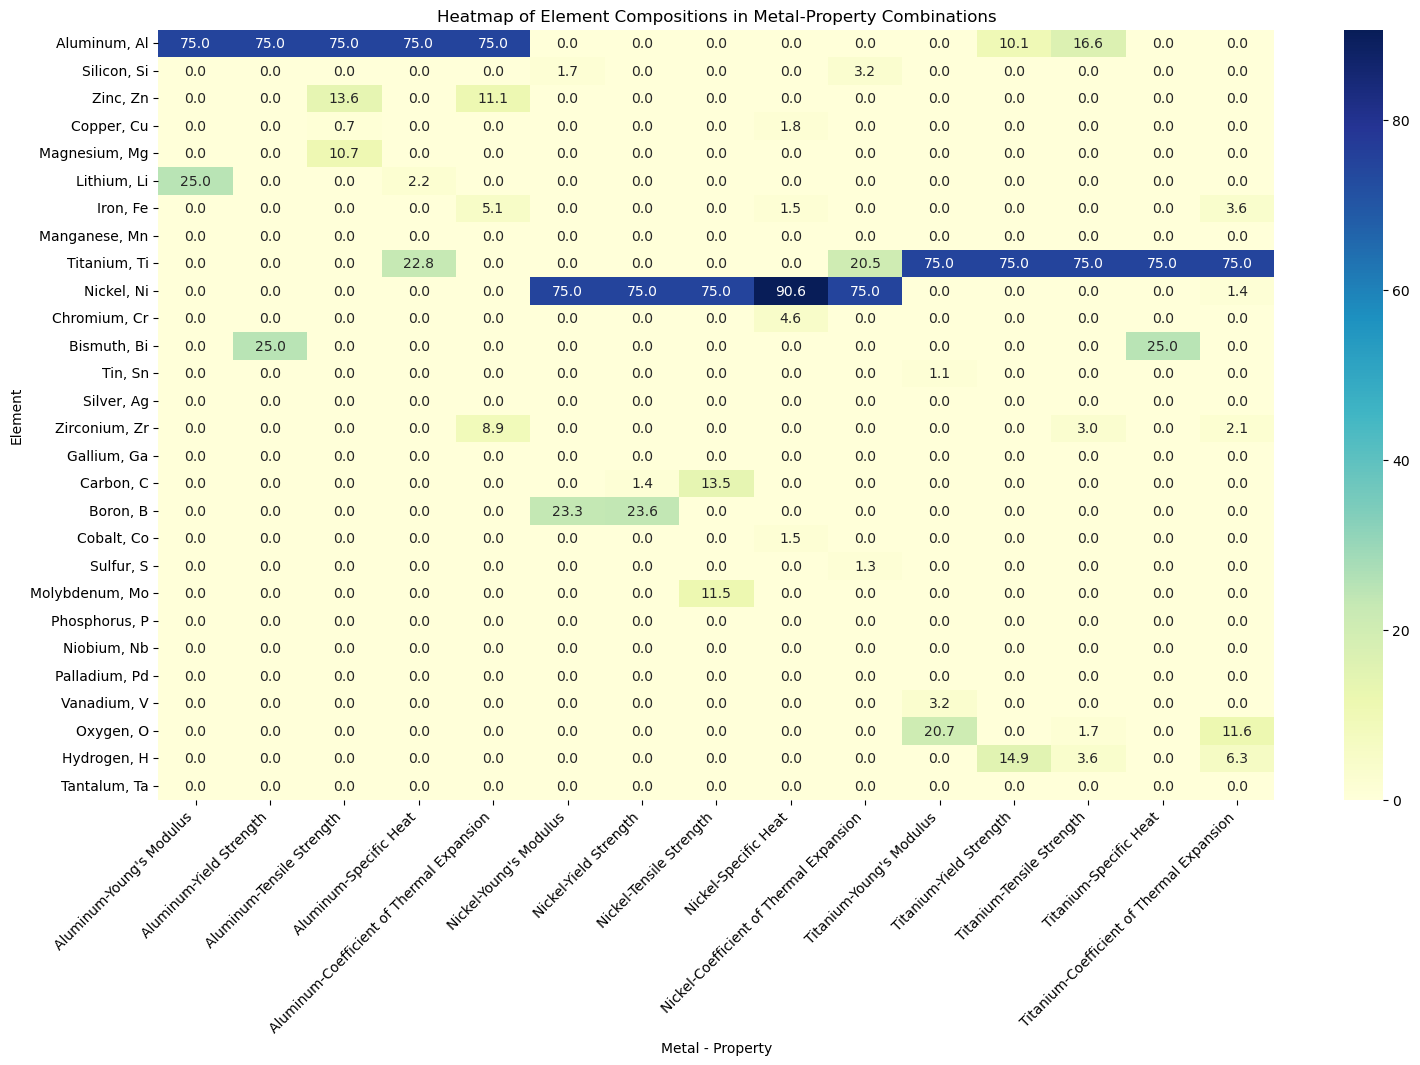

In [185]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate a heatmap of the composition matrix
plt.figure(figsize=(18, 10))
sns.heatmap(matrix_composition_df, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Heatmap of Element Compositions in Metal-Property Combinations")
plt.xlabel("Metal - Property")
plt.ylabel("Element")
plt.xticks(rotation=45, ha='right')
plt.show()


In [180]:
print(feature_importance_dfs)

[          Feature  Importance
0    Aluminum, Al    0.638778
6     Silicon, Si    0.158509
8        Zinc, Zn    0.053139
2      Copper, Cu    0.042156
4   Magnesium, Mg    0.033172
20    Lithium, Li    0.024946
3        Iron, Fe    0.013154
5   Manganese, Mn    0.009813
7    Titanium, Ti    0.007446
12     Nickel, Ni    0.006321,           Feature  Importance
2      Copper, Cu    0.276014
8        Zinc, Zn    0.220882
4   Magnesium, Mg    0.156801
0    Aluminum, Al    0.092477
3        Iron, Fe    0.074384
7    Titanium, Ti    0.047543
5   Manganese, Mn    0.042880
6     Silicon, Si    0.040860
1    Chromium, Cr    0.022855
16    Bismuth, Bi    0.007745,           Feature  Importance
2      Copper, Cu    0.378416
4   Magnesium, Mg    0.172605
0    Aluminum, Al    0.114631
8        Zinc, Zn    0.105708
7    Titanium, Ti    0.081312
6     Silicon, Si    0.045713
3        Iron, Fe    0.045647
5   Manganese, Mn    0.020829
1    Chromium, Cr    0.016997
12     Nickel, Ni    0.005514,       

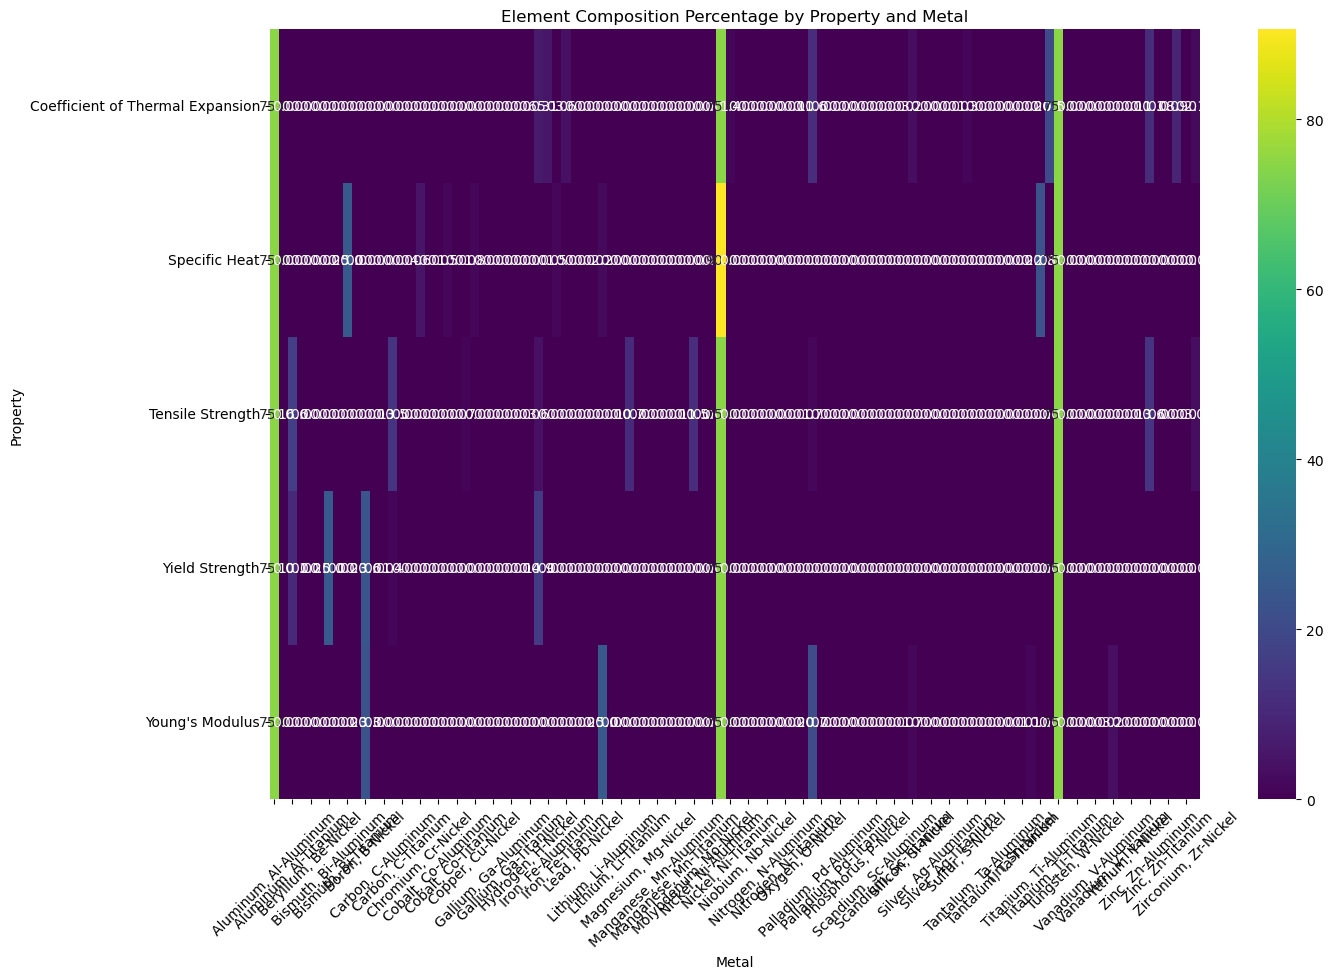

In [176]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assume results_df is already defined and includes columns ['Metal', 'Property', 'Composition']

# Expand the Composition dictionary into rows
rows = []
for idx, row in results_df.iterrows():
    for element, percentage in row['Composition'].items():
        rows.append({'Metal': row['Metal'], 'Property': row['Property'], element: percentage})

# Create a new DataFrame
expanded_df = pd.DataFrame(rows)

# Fill missing values with 0 (for elements that are not part of some compositions)
expanded_df.fillna(0, inplace=True)

# Now we need to make sure we have all elements in the columns
for element in all_elements:
    if element not in expanded_df.columns:
        expanded_df[element] = 0.0

# Reshape the DataFrame for easier plotting
reshaped_df = pd.pivot_table(expanded_df, index='Property', columns='Metal', values=all_elements, aggfunc=np.sum)

# Plot the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(reshaped_df, annot=True, cmap='viridis', fmt=".1f")
plt.title('Element Composition Percentage by Property and Metal')
plt.ylabel('Property')
plt.xlabel('Metal')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()
